In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from SymptomPreprocessing import *
from SpatialPreprocessing import *
import Preprocessing as P
import Cluster
import Metrics
import re
import RPorts
import Utils
from AucComp import delong
from warnings import simplefilter

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.metrics import accuracy_score,f1_score, auc, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score, recall_score, precision_score, roc_curve
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import chi2
import seaborn as sns
import joblib

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [2]:
def timestamp():
    return datetime.now().strftime('%Y%d%H%M%S%f')
for i in range(10):
    print(timestamp())

202228084041689522
202228084041689620
202228084041689689
202228084041689755
202228084041690132
202228084041690154
202228084041690167
202228084041690179
202228084041690191
202228084041690206


In [3]:
rds = RadDataset()
rds.get_value_array(rds.dvh_df.columns,as_df=True)

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms
176.0 91.77084266874341 406.1887464658043
264.0 109.22534647050192 407.1108350538819


Esophagus_D10  Esophagus_V80  Esophagus_D45  Esophagus_V75  \
id                                                                  
2.0        51.625000            0.0      38.437500            0.0   
6.0        44.968750            0.0      38.625000            0.0   
7.0        37.625000            0.0      30.843750            0.0   
8.0        32.156250            0.0      24.875000            0.0   
9.0        51.437500            0.0      35.125000            0.0   
10.0       44.218750            0.0      33.968750            0.0   
11.0       26.156250            0.0       9.101562            0.0   
12.0        3.279297            0.0       1.450195            0.0   
13.0       42.218750            0.0      39.437500            0.0   
15.0       44.906250            0.0      38.875000            0.0   
16.0       24.937500            0.0      19.375000            0.0   
18.0       51.437500            0.0      35.125000            0.0   
19.0       39.125000            0.0      27.500000            0.0   
21.0       44.593750            0.0      39.875000            0.0   
22.0       45.437500            0.0      40.937500            0.0   
23.0       42.875000            0.0      40.125000            0.0   
24.0       37.187500            0.0      26.109375            0.0   
25.0       25.875000            0.0      19.734375            0.0   
28.0       51.437500            0.0      35.125000            0.0   
29.0       40.218750            0.0      37.687500            0.0   
31.0       51.437500            0.0      35.125000            0.0   
32.0       19.359375            0.0       7.660156            0.0   
34.0       51.437500            0.0      35.125000            0.0   
35.0       51.437500            0.0      35.125000            0.0   
37.0       37.468750            0.0      23.578125            0.0   
38.0        7.199219            0.0       2.750000            0.0   
39.0       36.937500            0.0      34.625000            0.0   
40.0       39.500000            0.0      31.437500            0.0   
41.0       32.156250            0.0      23.390625            0.0   
42.0       36.500000            0.0      29.906250            0.0   
43.0       54.968750            0.0      37.187500            0.0   
44.0       25.421875            0.0      13.523438            0.0   
45.0       51.437500            0.0      35.125000            0.0   
46.0       51.437500            0.0      35.125000            0.0   
47.0       37.968750            0.0      24.484375            0.0   
48.0       48.187500            0.0      37.187500            0.0   
49.0       51.437500            0.0      35.125000            0.0   
50.0       51.437500            0.0      35.125000            0.0   
51.0       22.859375            0.0      20.265625            0.0   
52.0       36.750000            0.0      28.500000            0.0   
53.0       30.812500            0.0      21.703125            0.0   
54.0       20.937500            0.0      13.406250            0.0   
56.0       53.437500            0.0      26.203125            0.0   
57.0       23.234375            0.0      12.382812            0.0   
58.0       51.437500            0.0      35.125000            0.0   
59.0       40.656250            0.0      38.468750            0.0   
60.0       31.625000            0.0      24.875000            0.0   
61.0       48.937500            0.0      43.968750            0.0   
62.0       10.812500            0.0       5.609375            0.0   
65.0       29.734375            0.0      20.578125            0.0   
67.0       38.906250            0.0      26.656250            0.0   
68.0       34.687500            0.0      16.687500            0.0   
69.0       35.000000            0.0      18.687500            0.0   
71.0       38.312500            0.0      35.125000            0.0   
72.0       51.437500            0.0      35.125000            0.0   
73.0       51.437500            0.0      35.125000            0.0   
76.0 

In [4]:
def add_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    #using the 
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
    #symptomatic necrosis
    df['Brainstem_limit'] = (getval('Brainstem','D2') > 59) | (getval('Brainstem','D99') > 54)
    
    #myelopathy
    df['Spinal_Cord_limit'] = getval('Spinal_Cord',maxdose_var) > 50
    
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #alternative threshold
    df['Parotid_Gland_limit2'] = get_lr_val('Parotid_Gland','mean_dose') >= 35.7
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #ORN?
    df['Mandible_limit'] = getval('Mandible',maxdose_var) > 70
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Nerve damage
    df['Brachial_Plexus_limit'] = get_lr_val('Brachial_Plexus',maxdose_var) > 60
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    
#     print(df[[c for c in df.columns if  c not in original_cols]].sum())
    return df

def rds_to_df(rds,use_lstm=False,required=None,required_late=None):
    sd_df = P.get_merged_symp_dose_df(rds,roll_up=True,use_lstm=use_lstm,required_late=required_late,required=required)
#     sd_df = P.get_symptoms_max(sd_df)
    sd_df =  P.add_sd_dose_clusters(sd_df)
#     sd_df = P.add_sd_symptom_clusters(sd_df)
    sd_df = add_dose_limits(sd_df)
    return sd_df

#this version uses patients with a baselien drymouth
sddf = rds_to_df(rds)
sddf = P.add_sd_dose_clusters(sddf)
sddf[[c for c in sddf.columns if 'bmi' in c or 'weight' in c or 'height' in c] ].describe()

before drop count 823
after drop count 537
error (%) 0.7113381521638403
[('severe_6wk_symptoms', 0.00931098696461825), ('severe_late_symptoms', 0.0148975791433892), ('moderate_6wk_symptoms', 0.0521415270018622), ('moderate_late_symptoms', 0.04655493482309125), ('mild_6wk_symptoms', 0.19180633147113593), ('mild_late_symptoms', 0.16759776536312848)]
dose ids: 484 syptom ids: 537 merged ids: 350


end_of_treatment_weight  baseline_height  wk6_weight  baseline_weight  \
count               350.000000       350.000000  350.000000       350.000000   
mean                 85.437000       175.583429   83.060857        93.347143   
std                   9.945107         8.163379    7.515374        18.150805   
min                  54.300000       108.000000   49.300000        53.000000   
25%                  84.650000       171.000000   83.200000        82.825000   
50%                  84.650000       175.400000   83.200000        90.300000   
75%                  84.650000       181.000000   83.200000       103.000000   
max                 135.600000       196.500000  116.200000       186.800000   

       baseline_bmi     wk6_bmi  end_of_treatment_bmi  bmi_change  \
count    350.000000  350.000000            350.000000  350.000000   
mean      30.277159   27.100744             27.847664   -2.429495   
std        5.754643    3.779332              4.149146    4.739550   
min       19.711378   17.018756             18.744796  -29.211587   
25%       27.019337   24.980296             25.677966   -3.726801   
50%       29.351383   27.043578             27.514890   -1.836493   
75%       32.536478   28.645091             29.290657   -0.537583   
max       75.445816   71.330590             72.873800   12.840277   

       weight_loss_5kg  longterm_bmi_change  
count       350.000000           350.000000  
mean          0.105714            -3.176414  
std           0.307912             5.062238  
min           0.000000           -29.626240  
25%           0.000000            -5.244121  
50%           0.000000            -2.660971  
75%           0.000000            -0.597211  
max           1.000000            12.252018

In [5]:
#patients with drymout at either 6weeks or 6months
sddf2 = rds_to_df(rds,required=[],required_late=['drymouth'])
sddf2 = P.add_sd_dose_clusters(sddf2)
sddf2[[c for c in sddf2.columns if 'bmi' in c or 'weight' in c or 'height' in c] ].describe()

before drop count 823
after drop count 578
error (%) 0.617583184815022
[('severe_6wk_symptoms', 0.015570934256055362), ('severe_late_symptoms', 0.01730103806228374), ('moderate_6wk_symptoms', 0.06747404844290658), ('moderate_late_symptoms', 0.05536332179930796), ('mild_6wk_symptoms', 0.21972318339100347), ('mild_late_symptoms', 0.19377162629757785)]
dose ids: 484 syptom ids: 578 merged ids: 379


end_of_treatment_weight  baseline_height  wk6_weight  baseline_weight  \
count               379.000000       379.000000  379.000000       379.000000   
mean                 85.335884       175.593668   82.264908        93.124011   
std                   9.452492         8.115040    7.458127        18.455737   
min                  54.200000       108.000000   49.300000        53.000000   
25%                  85.100000       171.000000   82.300000        81.700000   
50%                  85.100000       175.750000   82.300000        90.400000   
75%                  85.100000       181.000000   82.300000       103.000000   
max                 125.700000       196.500000  116.200000       186.800000   

       baseline_bmi     wk6_bmi  end_of_treatment_bmi  bmi_change  \
count    379.000000  379.000000            379.000000  379.000000   
mean      30.191188   26.830482             27.811430   -2.379758   
std        5.793786    3.665851              4.043778    4.927218   
min       18.815075   17.018756             18.744796  -29.082902   
25%       26.925030   24.757887             25.622476   -3.725960   
50%       29.266970   26.644598             27.551097   -1.726181   
75%       32.577667   28.389640             29.446367   -0.416850   
max       75.445816   70.558985             72.873800   13.022841   

       weight_loss_5kg  longterm_bmi_change  
count       379.000000           379.000000  
mean          0.124011            -3.360706  
std           0.330029             5.166807  
min           0.000000           -29.883611  
25%           0.000000            -5.472708  
50%           0.000000            -2.692623  
75%           0.000000            -0.678206  
max           1.000000            11.886892

In [81]:
#patients with choke at either 6weeks or 6months
chokedf = rds_to_df(rds,required=[],required_late=['choke'])
chokedf

before drop count 823
after drop count 577
training failed
[Errno 2] No such file or directory: '../resources/pytorch_models/symptom_autoencoder_n=577_f=381'
model path ../resources/pytorch_models/symptom_autoencoder_n=577_f=381
training stopped on epoch 4993_fn=<MeanBackward0>)nsor(1.1880, grad_fn=<MeanBackward0>)tensor(0.2052, grad_fn=<MeanBackward0>)tensor(0.1796, grad_fn=<MeanBackward0>)tensor(0.1616, grad_fn=<MeanBackward0>)tensor(0.1494, grad_fn=<MeanBackward0>)tensor(0.1136, grad_fn=<MeanBackward0>)tensor(0.0653, grad_fn=<MeanBackward0>)tensor(0.0601, grad_fn=<MeanBackward0>)tensor(0.0554, grad_fn=<MeanBackward0>)tensor(0.0490, grad_fn=<MeanBackward0>)tensor(0.0468, grad_fn=<MeanBackward0>)tensor(0.0391, grad_fn=<MeanBackward0>)tensor(0.0374, grad_fn=<MeanBackward0>)tensor(0.0356, grad_fn=<MeanBackward0>)tensor(0.0337, grad_fn=<MeanBackward0>)tensor(0.0299, grad_fn=<MeanBackward0>)tensor(0.0307, grad_fn=<MeanBackward0>)tensor(0.0305, grad_fn=<MeanBackward0>)

error (%) 0.5797655

D10  \
id                                                       
2    [51.625, 26.890625, 56.1875, 53.625, 53.75, 57...   
7    [37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...   
8    [32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....   
9    [51.4375, 27.515625, 51.4375, 51.4375, 18.6875...   
10   [44.21875, 35.625, 64.75, 55.9375, 52.84375, 5...   
11   [26.15625, 31.984375, 57.125, 45.40625, 29.265...   
12   [3.279296875, 34.4375, 49.25, 1.7197265625, 7....   
13   [42.21875, 29.625, 60.46875, 48.6875, 19.5, 41...   
15   [44.90625, 33.28125, 57.71875, 47.75, 43.625, ...   
16   [24.9375, 32.28125, 56.84375, 52.625, 39.09375...   
18   [51.4375, 29.78125, 51.4375, 51.4375, 30.5625,...   
19   [39.125, 33.09375, 62.5, 54.96875, 33.3125, 36...   
21   [44.59375, 39.9375, 54.6875, 52.84375, 44.8437...   
22   [45.4375, 35.125, 71.375, 64.8125, 62.78125, 6...   
23   [42.875, 36.53125, 57.6875, 47.84375, 18.8125,...   
24   [37.1875, 35.03125, 67.9375, 56.40625, 47.3125...   
25   [25.875, 26.6875, 55.375, 56.0, 34.78125, 33.5...   
28   [51.4375, 25.375, 51.4375, 6.08984375, 35.25, ...   
29   [40.21875, 34.96875, 52.375, 50.03125, 31.5, 4...   
31   [51.4375, 24.140625, 51.4375, 51.4375, 50.875,...   
32   [19.359375, 34.28125, 53.78125, 53.375, 43.812...   
34   [51.4375, 25.265625, 51.4375, 51.4375, 48.3437...   
35   [51.4375, 51.4375, 51.4375, 51.4375, 51.4375, ...   
37   [37.46875, 34.8125, 58.28125, 12.1171875, 36.1...   
38   [7.19921875, 32.25, 47.78125, 1.8203125, 7.230...   
39   [36.9375, 34.5625, 55.6875, 57.5625, 40.875, 5...   
40   [39.5, 33.625, 53.4375, 49.875, 25.046875, 40....   
41   [32.15625, 30.84375, 68.0, 59.53125, 50.5, 53....   
42   [36.5, 32.96875, 54.1875, 51.625, 42.46875, 46...   
43   [54.96875, 30.4375, 59.0625, 64.5, 56.03125, 5...   
44   [25.421875, 29.140625, 57.46875, 52.53125, 41....   
45   [51.4375, 34.90625, 55.0, 51.3125, 11.578125, ...   
46   [51.4375, 34.0625, 55.0, 49.21875, 20.4375, 37...   
47   [37.96875, 33.6875, 70.375, 50.9375, 40.1875, ...   
48   [48.1875, 35.75, 59.53125, 54.28125, 33.71875,...   
49   [51.4375, 37.90625, 48.4375, 48.1875, 41.53125...   
50   [51.4375, 30.59375, 70.25, 58.125, 57.40625, 6...   
51   [22.859375, 29.546875, 67.25, 51.1875, 42.125,...   
52   [36.75, 33.0625, 61.1875, 59.6875, 45.5625, 48...   
53   [30.8125, 29.109375, 62.6875, 51.875, 35.0625,...   
54   [20.9375, 28.3125, 70.8125, 54.3125, 47.8125, ...   
56   [53.4375, 31.65625, 57.40625, 57.03125, 59.0, ...   
57   [23.234375, 22.734375, 63.375, 54.09375, 55.68...   
58   [51.4375, 35.0625, 57.0, 47.90625, 17.859375, ...   
61   [48.9375, 37.65625, 71.0625, 54.8125, 51.8125,...   
62   [10.8125, 30.96875, 60.75, 58.875, 41.4375, 59...   
65   [29.734375, 28.515625, 51.71875, 51.96875, 43....   
67   [38.90625, 33.0, 69.25, 58.25, 38.28125, 51.65...   
68   [34.6875, 36.28125, 57.71875, 57.78125, 47.75,...   
69   [35.0, 27.640625, 70.4375, 57.96875, 51.8125, ...   
71   [38.3125, 36.53125, 58.15625, 47.875, 19.21875...   
72   [51.4375, 30.203125, 67.5625, 56.84375, 72.312...   
73   [51.4375, 36.59375, 51.4375, 51.4375, 41.375, ...   
76   [51.4375, 33.34375, 51.4375, 51.4375, 49.84375...   
77   [52.53125, 30.0, 70.625, 57.125, 55.75, 60.5, ...   
78   [37.875, 24.375, 47.53125, 46.8125, 36.1875, 4...   
79   [37.0625, 31.4375, 66.4375, 57.90625, 50.84375...   
80   [17.265625, 32.625, 60.25, 45.8125, 20.546875,...   
81   [51.4375, 35.625, 51.34375, 10.3125, 8.6484375...   
82   [2.859375, 29.734375, 50.46875, 49.65625, 9.29...   
85   [51.4375, 30.71875, 51.4375, 51.4375, 4.488281...   
86   [25.484375, 33.40625, 60.90625, 52.84375, 36.3...   
89   [40.0, 21.40625, 58.0625, 53.71875, 42.3125, 4...   
91   [31.875, 24.15625, 64.25, 53.65625, 35.625, 37...   
92   [14.453125, 19.65625, 55.15625, 50.96875, 59.6...   
93   [49.875, 33.90625, 71.8125, 71.1875, 62.0, 66....   
94   [0.0200042724609375, 33.96875, 0.0200042724609...   
95   [33.40625, 20.5625, 55.59375, 7.46875, 39.28

In [83]:
swallowdf = rds_to_df(rds,required=[],required_late=['swallow'])
swallowdf

D10  \
id                                                       
2    [51.625, 26.890625, 56.1875, 53.625, 53.75, 57...   
7    [37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...   
8    [32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....   
9    [51.4375, 27.515625, 51.4375, 51.4375, 18.6875...   
10   [44.21875, 35.625, 64.75, 55.9375, 52.84375, 5...   
11   [26.15625, 31.984375, 57.125, 45.40625, 29.265...   
12   [3.279296875, 34.4375, 49.25, 1.7197265625, 7....   
13   [42.21875, 29.625, 60.46875, 48.6875, 19.5, 41...   
15   [44.90625, 33.28125, 57.71875, 47.75, 43.625, ...   
16   [24.9375, 32.28125, 56.84375, 52.625, 39.09375...   
18   [51.4375, 29.78125, 51.4375, 51.4375, 30.5625,...   
19   [39.125, 33.09375, 62.5, 54.96875, 33.3125, 36...   
21   [44.59375, 39.9375, 54.6875, 52.84375, 44.8437...   
22   [45.4375, 35.125, 71.375, 64.8125, 62.78125, 6...   
23   [42.875, 36.53125, 57.6875, 47.84375, 18.8125,...   
24   [37.1875, 35.03125, 67.9375, 56.40625, 47.3125...   
25   [25.875, 26.6875, 55.375, 56.0, 34.78125, 33.5...   
28   [51.4375, 25.375, 51.4375, 6.08984375, 35.25, ...   
29   [40.21875, 34.96875, 52.375, 50.03125, 31.5, 4...   
31   [51.4375, 24.140625, 51.4375, 51.4375, 50.875,...   
32   [19.359375, 34.28125, 53.78125, 53.375, 43.812...   
34   [51.4375, 25.265625, 51.4375, 51.4375, 48.3437...   
35   [51.4375, 51.4375, 51.4375, 51.4375, 51.4375, ...   
37   [37.46875, 34.8125, 58.28125, 12.1171875, 36.1...   
38   [7.19921875, 32.25, 47.78125, 1.8203125, 7.230...   
39   [36.9375, 34.5625, 55.6875, 57.5625, 40.875, 5...   
40   [39.5, 33.625, 53.4375, 49.875, 25.046875, 40....   
41   [32.15625, 30.84375, 68.0, 59.53125, 50.5, 53....   
42   [36.5, 32.96875, 54.1875, 51.625, 42.46875, 46...   
43   [54.96875, 30.4375, 59.0625, 64.5, 56.03125, 5...   
44   [25.421875, 29.140625, 57.46875, 52.53125, 41....   
45   [51.4375, 34.90625, 55.0, 51.3125, 11.578125, ...   
46   [51.4375, 34.0625, 55.0, 49.21875, 20.4375, 37...   
47   [37.96875, 33.6875, 70.375, 50.9375, 40.1875, ...   
48   [48.1875, 35.75, 59.53125, 54.28125, 33.71875,...   
49   [51.4375, 37.90625, 48.4375, 48.1875, 41.53125...   
50   [51.4375, 30.59375, 70.25, 58.125, 57.40625, 6...   
51   [22.859375, 29.546875, 67.25, 51.1875, 42.125,...   
52   [36.75, 33.0625, 61.1875, 59.6875, 45.5625, 48...   
53   [30.8125, 29.109375, 62.6875, 51.875, 35.0625,...   
54   [20.9375, 28.3125, 70.8125, 54.3125, 47.8125, ...   
56   [53.4375, 31.65625, 57.40625, 57.03125, 59.0, ...   
57   [23.234375, 22.734375, 63.375, 54.09375, 55.68...   
58   [51.4375, 35.0625, 57.0, 47.90625, 17.859375, ...   
61   [48.9375, 37.65625, 71.0625, 54.8125, 51.8125,...   
62   [10.8125, 30.96875, 60.75, 58.875, 41.4375, 59...   
65   [29.734375, 28.515625, 51.71875, 51.96875, 43....   
67   [38.90625, 33.0, 69.25, 58.25, 38.28125, 51.65...   
68   [34.6875, 36.28125, 57.71875, 57.78125, 47.75,...   
69   [35.0, 27.640625, 70.4375, 57.96875, 51.8125, ...   
71   [38.3125, 36.53125, 58.15625, 47.875, 19.21875...   
72   [51.4375, 30.203125, 67.5625, 56.84375, 72.312...   
73   [51.4375, 36.59375, 51.4375, 51.4375, 41.375, ...   
76   [51.4375, 33.34375, 51.4375, 51.4375, 49.84375...   
77   [52.53125, 30.0, 70.625, 57.125, 55.75, 60.5, ...   
78   [37.875, 24.375, 47.53125, 46.8125, 36.1875, 4...   
79   [37.0625, 31.4375, 66.4375, 57.90625, 50.84375...   
80   [17.265625, 32.625, 60.25, 45.8125, 20.546875,...   
81   [51.4375, 35.625, 51.34375, 10.3125, 8.6484375...   
82   [2.859375, 29.734375, 50.46875, 49.65625, 9.29...   
85   [51.4375, 30.71875, 51.4375, 51.4375, 4.488281...   
86   [25.484375, 33.40625, 60.90625, 52.84375, 36.3...   
89   [40.0, 21.40625, 58.0625, 53.71875, 42.3125, 4...   
91   [31.875, 24.15625, 64.25, 53.65625, 35.625, 37...   
92   [14.453125, 19.65625, 55.15625, 50.96875, 59.6...   
93   [49.875, 33.90625, 71.8125, 71.1875, 62.0, 66....   
94   [0.0200042724609375, 33.96875, 0.0200042724609...   
95   [33.40625, 20.5625, 55.59375, 7.46875, 39.28

In [80]:
#seperate version using all the patients using the data imputed by guadalupe
# lstmdf = rds_to_df(rds,use_lstm=True)
# lstmdf = P.add_sd_dose_clusters(lstmdf)
# #version with missing baseline drymouth removed
# lstmdf2 = lstmdf.loc[sddf.index]
# lstmdf2

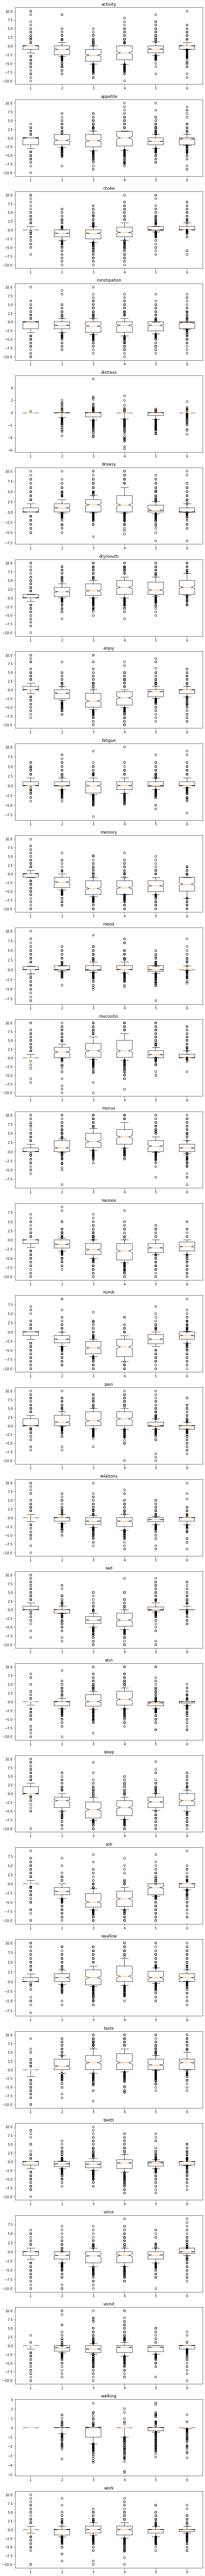

In [8]:
def compare_impute_methods(df1,df2,dates=None,**kwargs):
    #Im 
    if dates is None:
        dates = [0,3,6,7,13,33]
    datelocs = np.array([i for i,d in enumerate( df1.dates.iloc[0]) if d in dates])
    names = df_symptom_names(df1,use_groups=False,use_domains=False)
    a1 = P.df_to_symptom_array(df1,use_groups=False)
    a2 = P.df_to_symptom_array(df2.loc[df1.index],use_groups=False)
    
    a1 = a1[:,:,datelocs]
    a2 = a2[:,:,datelocs]
    diff =a1-a2
    xaxis = [i for i in range(diff.shape[-1])]
    n_symptoms = a1.shape[1]
    fig,axes = plt.subplots(n_symptoms,1,figsize=(10,5*len(names)))
    for col in range(n_symptoms):
        sname = names[col].replace('symptoms_','')
        axis = axes[col]
        axis.set_title(names[col].replace('symptoms_',''))
        x = diff[:,col,:]
        axis.boxplot(x,notch=True,whis=(15,85))
compare_impute_methods(sddf,lstmdf)


In [9]:
def get_lr_dose(df,key='mean_dose'):
    left_organs = [Const.organ_list.index(c) for c in Const.organ_list if 'Lt_' in c]
    right_organs= [Const.organ_list.index(c) for c in Const.organ_list if 'Rt_' in c]
    left = df[key].apply(lambda x: np.sum([x[i] for i in left_organs]))
    right = df[key].apply(lambda x: np.sum([x[i] for i in right_organs]))
    return left > right
[get_lr_dose(sddf).mean(),get_lr_dose(lstmdf).mean()]

[0.96, 0.9566115702479339]

In [84]:
def add_pscore(df,treatment,covariates,
               model=None,
               use_cv=False):
    x = df[treatment].values
    z = np.stack(df[covariates].apply(lambda x: np.stack([np.array(xx) for xx in x])).values)
    pp = predict_propensity(x,z,model=model,use_cv=use_cv)
    df = df.copy()
    df.loc[:,'propensity'] = pp['pscore']
    return df

def predict_cv(model,x,y,cvsize=None):
    #currently leave-one-out
    predictions = []
    y = y.reshape(-1,1)
    if cvsize == None:
        cvsize = int(x.shape[0]*.1)+1
    nsteps = int(np.ceil(x.shape[0]/cvsize))
    start = 0
    for i in range(nsteps):
        stop = min(start + cvsize,x.shape[0])
        test_idx = np.arange(start,stop)
        x_train = np.delete(x, test_idx,axis=0)
        x_test = x[test_idx]
        y_train = np.delete(y,test_idx)
        y_test = y[test_idx]
        
        if x_test.ndim < 2:
            x_test = x_test.reshape(1,-1)
        model.fit(x_train,y_train)
        
        ypred = model.predict_proba(x_test)
        predictions.append(ypred)
        
        start=stop
    ypred = np.concatenate(predictions)
    ypred = ypred.reshape(x.shape[0],-1)
    return ypred

def get_metrics(y,ypred):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1])
    accuracy = accuracy_score(y_true, squeeze(ypred))
    fscore = f1_score(y_true,squeeze(ypred))
    return {'roc': roc, 'accuracy': accuracy,'fscore':fscore}

def predict_propensity(x,z,model=None,use_cv=False,calibrate=True):
    #assumes binary outcome
    if model is None:
        model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model)
    if use_cv:
        predictions = predict_cv(model,z,x)
    else:
        predictions = model.fit(z,x)
        predictions = model.predict_proba(z)
    model.fit(z,x)
    results  = {'pscore': predictions[:,1], "model": model}
    metrics = get_metrics(x,predictions)
    results['metrics'] = metrics
    return results

def add_weights(cdf,treatment,covariates,model=None):
    if 'propensity' not in cdf.columns:
        cdf = add_pscore(cdf.copy(), treatment, covariates,model=model)
    def get_weight(row):
        if row[treatment] == 1:
            weight = 1/row['propensity']
        else:
            weight = 1/(1-row['propensity'])
        return weight
    cdf.loc[:,'weights'] = cdf.apply(get_weight,axis=1)
    return cdf

def propensity_df(treatment,y,confounders,p_model=None):
    cdf = pd.DataFrame({'treatment':treatment,'outcome':y})
    confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
    for i,col in enumerate(confounder_cols):
        cdf[col] = confounders[:,i].tolist()
    if p_model is None:
        p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#         p_model = RandomForestClassifier(class_weight='balanced',random_state=0)
    cdf = add_weights(cdf.copy(), 
                      'treatment', 
                      confounder_cols,
                      model=p_model) 
    return cdf[['treatment','propensity','weights']]

def get_dr_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               dr_model=None,
               use_proba=True,
               min_propensity=.01,
               calibrate=True,
              ):
    try:
        #this is giving me weird results
        if p_model is None:
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#             p_model = RandomForestClassifier(class_weight='balanced',random_state=0)
        if dr_model is None:
            dr_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
            
        if calibrate:
            max_cv = outcome.sum()
            if max_cv < 3:
                cv = max_cv -1
            else:
                cv=5
            dr_model = CalibratedClassifierCV(base_estimator=dr_model,cv=cv)
            p_model = CalibratedClassifierCV(base_estimator=p_model,cv=cv)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        cdf.propensity = cdf.propensity.apply(lambda x: np.clip(x,.01,.99))
        y = cdf['outcome'].values.astype('bool')
        input_x = cdf[['treatment']+confounder_cols]

        xcols = ['treatment']+confounder_cols
        x_1 = cdf[xcols]
        x_0 = cdf[xcols]

        x_1.loc[:,'treatment'] = 1
        x_0.loc[:,'treatment'] = 0
        
        dr_model.fit(input_x,y)
        y_1 = dr_model.predict_proba(x_1).astype('float')[:,-1]
        y_0 = dr_model.predict_proba(x_0).astype('float')[:,-1]
        
        if not use_proba:
            y_1 = (y_1 > .5).astype('float')
            y_0 = (y_0 < .5).astype('float')
        cdf['y_0'] = y_0#[:,-1]
        cdf['y_1'] = y_1#[:,-1]


        def dr1(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*row['treatment']
            n2 = row['y_1']*(row['treatment']-row['propensity'])
            prop = row['propensity']
            return (n1 - n2)/(prop)

        def dr0(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*(1-row['treatment'])
            n2 = row['y_0']*(row['treatment'] -row['propensity'])
            return (n1 + n2)/(1-row['propensity'])
        
        cdf['d1'] = cdf.apply(dr1,axis=1)
        cdf['d0'] = cdf.apply(dr0,axis=1)

        ate = cdf['d1'].mean() - cdf['d0'].mean()
        return ate#, cdf.drop(confounder_cols,axis=1)
    except Exception as e:
        print('error in doubly robust ate', e)
        return -1

    
def get_iptw_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               calibrate=True,
              ):
    try:
        if p_model is None:
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.25,solver='saga',class_weight='balanced',random_state=0)
#             p_model = RandomForestClassifier(class_weight='balanced',max_depth=4,random_state=0)
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        con = cdf[~cdf['treatment']]
        y_1 = (treat['outcome'] * treat['weights']).sum()/treat.shape[0]
        y_0 = (con['outcome'] * con['weights']).sum()/con.shape[0]
        return y_1 - y_0
    except Exception as e:
        print('error in iptw ate', e)
        return -1

def get_matching_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               replacement = False,
               calibrate=True,
              ):
    try:
        if p_model is None:
#             p_model = RandomForestClassifier(class_weight='balanced')
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'propensity' not in cdf.columns:
            cdf = add_pscore(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        control = cdf[~cdf['treatment']]
        matches = []
        for i,row in treat.iterrows():
            con = control.copy()
            con['pdiff'] = con['propensity'].apply(lambda x: np.abs(x - row['propensity']))
            matchdf = con[con.pdiff == con.pdiff.min()]
            if not replacement:
                control = control.drop(matchdf.index)
                if control.shape[0] < 2:
                    break
            matches.append(matchdf)
        matched_control= pd.concat(matches,axis=0)
        standard_ate = (treat['outcome'].mean() - matched_control['outcome'].mean())
        return standard_ate
    except Exception as e:
        print('error in matching ate', e)
        return -1
    
def ate_worker(args):
    #used in the clusterTester class for multiprocessing bootstraped ate stuff in parallel
    [treatment,outcome,confounders,threshold,use_iptw,use_dr,use_matching,confounder_pval_filter,cluster_value] = args
    if confounder_pval_filter < 1:
        temp_confounders = filter_confounders(confounders,treatment,outcome,
                                             max_pval=confounder_pval_filter)
        confounder_names = list(temp_confounders.columns)
        temp_confounders=temp_confounders.values
    else:
        temp_confounders = confounders.values
        confounder_names = list(confounders.columns)
    ate_entry = {'threshold':threshold, 'cluster_value':cluster_value,'confounders':confounder_names}
    if use_iptw:
        iptw = get_iptw_ate(treatment,outcome,temp_confounders)
        ate_entry['iptw_ate'] = iptw
    if use_dr:
        dr = get_dr_ate(treatment,outcome,temp_confounders)
        ate_entry['dr_ate'] = dr
    if use_matching:
        matching = get_matching_ate(treatment,outcome,temp_confounders)
        ate_entry['matching_ate'] = matching
    print(ate_entry,end='\r')
    return ate_entry
    
treatment = sddf['dose_clusters'].apply(lambda x: x == 3).values
outcome = sddf['t3'].values
confounders = sddf[['n3','old']].values
print(treatment.shape,outcome.shape,confounders.shape)
propensity_df(treatment,outcome,confounders)
# get_iptw_ate(treatment,outcome,confounders)

(350,) (350,) (350, 2)


treatment  propensity   weights
0        False    0.206182  1.259734
1        False    0.188920  1.232924
2        False    0.206182  1.259734
3        False    0.195103  1.242395
4        False    0.206182  1.259734
5        False    0.195103  1.242395
6         True    0.195103  5.125499
7        False    0.206388  1.260062
8        False    0.206182  1.259734
9        False    0.206388  1.260062
10        True    0.206182  4.850087
11       False    0.206182  1.259734
12       False    0.195103  1.242395
13        True    0.206182  4.850087
14       False    0.206182  1.259734
15       False    0.206182  1.259734
16       False    0.206182  1.259734
17       False    0.206182  1.259734
18       False    0.206182  1.259734
19        True    0.206388  4.845235
20       False    0.188920  1.232924
21       False    0.206182  1.259734
22        True    0.206182  4.850087
23       False    0.195103  1.242395
24       False    0.206388  1.260062
25       False    0.195103  1.242395
26        True    0.195103  5.125499
27       False    0.206182  1.259734
28       False    0.195103  1.242395
29       False    0.195103  1.242395
30       False    0.195103  1.242395
31        True    0.206182  4.850087
32       False    0.195103  1.242395
33       False    0.206182  1.259734
34        True    0.206388  4.845235
35        True    0.188920  5.293246
36       False    0.206182  1.259734
37       False    0.206182  1.259734
38        True    0.206182  4.850087
39       False    0.195103  1.242395
40        True    0.206182  4.850087
41       False    0.195103  1.242395
42       False    0.195103  1.242395
43        True    0.188920  5.293246
44       False    0.206182  1.259734
45       False    0.195103  1.242395
46       False    0.206182  1.259734
47        True    0.195103  5.125499
48       False    0.195103  1.242395
49       False    0.195103  1.242395
50       False    0.188920  1.232924
51       False    0.195103  1.242395
52       False    0.195103  1.242395
53        True    0.206182  4.850087
54       False    0.188920  1.232924
55        True    0.195103  5.125499
56       False    0.195103  1.242395
57       False    0.206388  1.260062
58       False    0.188920  1.232924
59       False    0.195103  1.242395
60        True    0.195103  5.125499
61       False    0.206182  1.259734
62       False    0.195103  1.242395
63       False    0.206182  1.259734
64       False    0.206182  1.259734
65       False    0.206182  1.259734
66       False    0.195103  1.242395
67       False    0.206182  1.259734
68       False    0.195103  1.242395
69        True    0.206182  4.850087
70       False    0.206182  1.259734
71       False    0.188920  1.232924
72       False    0.195103  1.242395
73       False    0.206182  1.259734
74       False    0.195103  1.242395
75        True    0.195103  5.125499
76       False    0.206182  1.259734
77        True    0.206388  4.845235
78       False    0.195103  1.242395
79       False    0.206182  1.259734
80        True    0.206182  4.850087
81       False    0.195103  1.242395
82       False    0.206182  1.259734
83       False    0.195103  1.242395
84       False    0.195103  1.242395
85       False    0.195103  1.242395
86       False    0.206182  1.259734
87       False    0.195103  1.242395
88       False    0.206182  1.259734
89       False    0.206182  1.259734
90       False    0.206182  1.259734
91       False    0.195103  1.242395
92        True    0.195103  5.125499
93        True    0.206182  4.850087
94       False    0.206182  1.259734
95       False    0.206182  1.259734
96       False    0.188920  1.232924
97       False    0.195103  1.242395
98        True    0.188920  5.293246
99       False    0.206182  1.259734
100      False    0.195103  1.242395
101      False    0.195103  1.242395
102      False    0.195103  1.242395
103      False    0.188920  1.232924
104      False    0.206388  1.260062
105      False    0.206182  1.259734
106      False    0.188920  1.232924
107      

In [11]:
def get_aggregate_outcome(df,symptoms,dates,aggfunc=None):
    if aggfunc is None:
        aggfunc = np.max
    df = df.copy()
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
#     print('dates',dates,date_idxs)
    s_array = np.zeros((df.shape[0],len(symptoms)))
    for col,symptom in enumerate(symptoms):
        if 'symptoms_'+symptom not in df.columns:
            print('missing',symptom)
        svals = df['symptoms_'+symptom].apply(lambda x: np.max([x[i] for i in date_idxs]) )
        s_array[:,col] = svals
    res = np.apply_along_axis(aggfunc,1,s_array)
    return res

def add_outcomes(df,symptoms,dates,aggfunc=None):
    vals = get_aggregate_outcome(df,symptoms,dates,aggfunc)
    name = '_'.join(symptoms) + '_' + '-'.join([str(d) for d in dates])
    df = df.copy()
    df[name] = vals
    return df

def filter_confounders(confounders,treatment,outcome,max_pval = .1):
    #gvien a list of covariates, get true confounders based on correlation vis f-test
    #only returns covariates with a correlation below max_pval
    #if none, returns the most correlated value so i'ts not an empty set
    xz = f_classif(confounders,treatment)[1]
    xy = f_classif(confounders,outcome)[1]
    max_p = np.maximum(xz,xy)
    #if none below threshold, take the minimum pvalue instead
    max_pval = max(np.min(max_p),max_pval)
    valid = max_p <= max_pval
    #assumes confounders is a df for now
    return confounders.iloc[:,valid]

def aggregate_ate_results(res):
    agg_by = [c for c in res.columns if '_ate' not in c and 'confounders' not in c]
    ate_cols = [c for c in res.columns if '_ate' in c]
    new_results = []
    for i, subdf in res.groupby(agg_by):
        entry = {}
        for name, val in zip(agg_by,i):
            entry[name] = val
        for atetype in ate_cols:
            quants = subdf[atetype].quantile([.05,.5,.95]).values
            is_negative = np.sign(np.max(quants)) < 0
            is_positive = np.sign(np.min(quants)) > 0
            significant = is_negative or is_positive
            entry[atetype + '_05'] = quants[0]
            entry[atetype + '_median'] = quants[1]
            entry[atetype + '_95'] = quants[2]
            entry[atetype + '_sig'] = significant
            entry[atetype + '_positive'] = is_positive
        if 'confounders' in subdf.columns:
            all_conf = []
            clist = subdf.confounders.apply(lambda x: ','.join(sorted(x)))
            for c in clist:
                all_conf.append(c)
            entry['confounders'] = clist
        new_results.append(entry)
    return pd.DataFrame(new_results)

def var_tests(df, testcol, ycol,xcols, 
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    if testcol not in xcols:
        xcols = xcols + [testcol]
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcol,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,1)
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'ttest_pval': logit_res.pvalues[testcol],
        'ttest_tval': logit_res.tvalues[testcol],
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff,
        'odds_ratio': odds[testcol],
    }
    return results

def multi_var_tests(df, testcols, ycol,xcols, 
#              boolean=True,
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    xcols = list(set(xcols).union(set(testcols)))
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcols,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,len(testcols))
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff,
    }
#     for testcol in testcols:
#         results['odds_'+str(testcol)] = odds[testcol]
#         results['ttest_pval_' + str(testcol)]= logit_res.pvalues[testcol]
#         results['ttest_tval_' + str(testcol)]= logit_res.tvalues[testcol]
    return results

def get_stratification_metrics(y,ypred):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1])
    accuracy = accuracy_score(y_true, squeeze(ypred))
#     fscore = f1_score(y_true,squeeze(ypred))
    [precision,recall,fscore,support] = precision_recall_fscore_support(y_true,squeeze(ypred),average='binary')
    fbeta = lambda b: (1+b**2)*(precision*recall)/((b**2)*precision + recall)
    f_half = fbeta(.5)
    f2 = fbeta(2)
    matthews = matthews_corrcoef(y_true,squeeze(ypred))
    dor = (recall*precision)/((1-recall)*(1-precision))
    results=  {
        'roc': roc, 
        'mcc': matthews,
        'dor': dor,
        'accuracy': accuracy,
        'precision': precision,
        'recall':recall,
        'f1': fscore,
        'f_half': f_half,
        'f2': f2,
    }
    return results


In [12]:
def extract_dose_vals(df,organs,features,include_limits = False):
    oidxs = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    df = df.copy()
    vals = []
    names = []
    for f in features:
        for (oname, oidx) in zip(organs,oidxs):
            values = df[f].apply(lambda x: x[oidx]).values
            vals.append(values.reshape((-1,1)))
            names.append(f+'_'+oname)
    vals = np.hstack(vals)
    vals = pd.DataFrame(vals,columns=names,index=df.index)
    if include_limits:
        limit_cols = [t for t in df.columns if '_limit' in t]
        for l in limit_cols:
            vals[l] = df[l].astype(int).fillna(0)
    return vals 

def get_outcomes(df,symptoms,dates,threshold=None):
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
    res = []
    get_max_sval = lambda s: df['symptoms_'+s].apply(lambda x: np.max([x[i] for i in date_idxs]) ).values
    res = {symp:get_max_sval(symp) for symp in symptoms}
    return pd.DataFrame(res,index=df.index)

def add_post_clusters(df,post_results):
    cmap = {}
    for c_entry in post_results['clusterData']:
        cId = c_entry['clusterId']
        for pid in c_entry['ids']:
            cmap[int(pid)] = cId
    df = df.copy()
    df['post_cluster'] = df.id.apply(lambda i: cmap.get(int(i),-1))
    return df
        
def process_rule_async(args):
    [df,col,y,currval,min_split_size,min_odds,min_info] = args
    vals = df[col]
    rule = vals >= currval
    entry = {
        'features': [col],
        'thresholds': [currval],
        'splits': [rule],
        'rule': rule
    }
    entry = evaluate_rule(entry,y)
    if valid_rule(entry,min_split_size,min_odds=min_odds,min_info=min_info):
        return entry
    return False
    
def get_rule_df(df,y,granularity=2,min_split_size=10,min_odds=0,min_info=.01):
    split_args = []
    minval = df.values.min().min()
    maxval = df.values.max().max()
    granularity_vals = [i*granularity + minval for i in np.arange(np.ceil(maxval/granularity))]
    for col in df.columns:
        if '_limit' in col:
            split_args.append((df,col,y,.5,1,0,0))
        else:
            for g in granularity_vals:
                split_args.append((df,col,y,g,min_split_size,min_odds,min_info))
    splits = joblib.Parallel(n_jobs=-2)(
        joblib.delayed(process_rule_async)(args) for args in split_args)
    return [s for s in splits if s is not False]

def combine_rule(r1,r2):
    if r1 is None:
        combined = r2
    elif r2 is None:
        combined = r1
    else:
        newthresholds = r1['thresholds'][:]
        newfeatures = r1['features'][:]
        newsplits = r1['splits'][:]
        newrule = r1['rule']
        fstring = stringify_features(newfeatures)
        for i,f in enumerate(r2['features']):
            #only one split per feature
            if stringify_features([f]) not in fstring:
                newfeatures.append(f)
                t = r2['thresholds'][i]
                s = r2['splits'][i]
                newthresholds.append(t)
                newsplits.append(s)
                newrule = newrule*s
        combined = {
            'features': list(newfeatures),
            'thresholds': list(newthresholds),
            'splits': newsplits,
            'rule': newrule
        }
    return combined

def evaluate_rule(rule, y):
    r = rule['rule']
    upper = y[r]
    lower = y[~r]
    entry = {k:v for k,v in rule.items()}
    entry['info'] = mutual_info_classif(r.values.reshape(-1,1),y.values.ravel(),
                                        random_state=1,discrete_features=True,n_neighbors=5)[0]
    ucount = upper.mean().values[0]
    lcount = lower.mean().values[0]
    if ucount < lcount:
        temp = ucount
        ucount = lcount
        lcount = temp
    lcount = max(lcount, 1)
    entry['odds_ratio'] = ucount / lcount
    for prefix, yy in zip(['lower','upper'],[lower,upper]):
        entry[prefix+'_count'] = yy.shape[0]
        entry[prefix+'_tp'] = yy.sum().values[0]
        entry[prefix+'_mean'] = yy.mean().values[0]
    return entry 

def filter_rules(rulelist, bests,tholds,criteria):
    is_best = lambda r: (r[criteria] >= bests.get(stringify_features(r['features']),0)) and (
        stringify_thresholds(r['thresholds']) == tholds.get(stringify_features(r['features'])) )
    filtered = [r for r in rulelist if is_best(r)]
    return filtered

def seperate_organ(string):
    if 'max_dose' in string or 'mean_dose' in string:
        return string.replace('max_dose','').replace('mean_dose','')
    else:
        return string[3:]
    
def stringify_features(l):
    #turns a list of features in the form 'VXX_Organ' into a hashable set
    #removes V thing becuase I think it shold be per organ
    return ''.join(sorted([seperate_organ(ll) for ll in l]))

def stringify_thresholds(t):
    return ''.join([str(int(tt)) for tt in t])

def combine_and_eval_rule(args):
    [baserule,rule,outcome_df] = args
    r = combine_rule(baserule,rule)
    r = evaluate_rule(r,outcome_df)
    return r

def get_best_rules(front, allrules,outcome_df,min_odds,criteria='info'):
    new_rules = []
    bests = {}
    best_thresholds = {}
    if len(front) < 1:
        front = [None]
    minsplit = max(5,int(outcome_df.shape[0]/10))
    for baserule in front:
        combined_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(combine_and_eval_rule)((baserule,r,outcome_df)) for r in allrules)
        for combined_rule in combined_rules:
            if valid_rule(combined_rule,minsplit,min_odds):
                if (baserule is not None) and combined_rule[criteria] <= baserule.get(criteria,0):
                    continue
                rname = stringify_features(combined_rule['features'])
                if bests.get(rname,0) < combined_rule[criteria]:
                    #look at best info/odds ratio fro each set of organs
                    bests[rname] = combined_rule[criteria]
                    #svae thresholds as a tie-breaker
                    best_thresholds[rname] = stringify_thresholds(combined_rule['thresholds'])
                new_rules.append(combined_rule)
    new_rules = filter_rules(new_rules,bests,best_thresholds,criteria)
    return new_rules
    

def valid_rule(r,min_split_size=5,min_odds=0,min_info=.01):
    if r['odds_ratio'] < min_odds:
        return False
    if r.get('info',0) <= min_info:
        return False
    if min(r['upper_count'],r['lower_count']) < min_split_size:
        return False
    return True

In [ ]:

class ClusterTester():
    
    outlier_ids = set([
        428,617,706,768,265,773,649,228,189,
    ])
    def __init__(self,df,
                 cluster_organs, 
                 n_clusters=3, 
                 symptoms=None,
                 cluster_features=None,
                 outcome_dates=None,
                 default_confounders=None,
                 agg_type='max',
                 filter_outliers = False,
                 **kwargs,
                ):
        
        self.cluster_organs = cluster_organs
        self.n_clusters = n_clusters
        if symptoms is None:
            symptoms = ['drymouth']
        self.symptoms = symptoms
        
        if cluster_features is None:
            cluster_features = ['V35','V40','V45','V50','V55','V60']
        self.cluster_features = cluster_features
        
        if outcome_dates is None:
            outcome_dates = [13,33]
        self.outcome_dates = outcome_dates
        
        if agg_type == 'mean' or agg_type == 'average':
            self.agg_func = np.nanmean
        else:
            self.agg_func = np.nanmax
            
            
        if default_confounders is None:
            default_confounders = [
                't_severe',
                'n_severe',
                'performance_1',
                'performance_2',
                'hpv',
                'age_65',
                'BOT','Tonsil',
                'Parotid_Gland_limit',
#                 'IMRT','VMAT'
            ]
        self.default_confounders = default_confounders
        df = df.copy()
        df = self.filter_df(df,filter_outliers= filter_outliers)
        df = self.add_total_cluster_doses(df)
        self.df = df
        self.cluster_df=None
        self.current_mimic = None
        self.current_rules = None
        
    def add_total_cluster_doses(self,df,cols=None):
        df = df.copy()
        if cols is None:
            cols = ['mean_dose'] + self.cluster_features
        opositions = [Const.organ_list.index(o) for o in self.cluster_organs if o in Const.organ_list]
        for col in cols:
            if col in df.columns:
                df['total_'+col+'_cluster'] = df[col].apply(lambda x: np.sum([x[i] for i in opositions]))
        return df
    
    def toggle_use_change(self,value=None):
        if value == None:
            value = (not self.use_outcome_change)
        self.use_outcome_change = value
        
    def get_cluster_df(self,
                       resample=False,
                       use_mimic=False,
                       df = None,
                       use_cached=True,
                       **kwargs):
        # resampling is weird so I'd just avooid it and try to do it before passing df
        #if not caching and afterwords otherwise
        if df is None:
            df = self.df.copy()
        if resample:
            df = df.sample(frac=1)
        if use_mimic:
            if self.current_mimic is not None and use_cached and not (resample):
                df = self.current_mimic.copy()
            else:
                df, _ = self.get_mimic_clusters(df=df,max_rules=1,save_rule=(not resample),**kwargs)
            df = df.copy()
            df['dose_clusters'] = df['mimic_cluster_'+str(self.n_clusters-1)+'_0'].astype(int)
        else:
            if use_cached and self.cluster_df is not None and (not resample):
                df = self.cluster_df.copy()
            else:
                df,score = P.add_sd_dose_clusters(df,
                                    features=self.cluster_features,
                                    organ_subset=self.cluster_organs,
                                    return_score=True,
                                    n_clusters = self.n_clusters)
                self.score = score
        return df
    
    def get_outcome(self,threshold=5,df=None,use_change=False):
        if df is None:
            df = self.df.copy()
        outcome = get_aggregate_outcome(df,self.symptoms,self.outcome_dates,aggfunc=self.agg_func)
        if use_change:
            baseline = get_aggregate_outcome(df,self.symptoms,[0],aggfunc=self.agg_func)
            outcome=outcome-baseline
        if threshold > 0:
            outcome = outcome >= threshold
        return outcome
    
    def df_with_outcome(self,key='outcome',threshold=5):
        df = self.df.copy()
        df[key] = self.get_outcome(threshold=threshold)
        return df
        
    def filter_df(self,df,filter_outliers=False):
        keywords = ['_original','_max_','_6wk_symptoms','_late_symptoms']
        for keyword in keywords:
            to_drop = [col for col in df.columns if keyword in col]
            df = df.drop(to_drop,axis=1)
        if filter_outliers:
            iname = df.index.name
            df = df.reset_index()
            df = df[df.id.apply(lambda x: x not in ClusterTester.outlier_ids)]
            df = df.set_index(iname)
            print('after filter',df.shape)
        return df
    
    def extract_dose_vals(self,organ_list,df=None,features=None,as_df=True):
        oidxs = [Const.organ_list.index(o) for o in organ_list if o in Const.organ_list]
        
        if features is None:
            features = self.cluster_features
        if df is None:
            df = self.df.copy()
        vals = []
        names = []
        for f in features:
            for (oname, oidx) in zip(organ_list, oidxs):
                values = df[f].apply(lambda x: x[oidx])
                vals.append(values.values.reshape((-1,1)))
                names.append(f+'_'+oname)
        vals = np.hstack(vals)
        if as_df:
            vals = pd.DataFrame(vals,columns=names,index=self.df.index)
        return vals
    
    def extract_confounders(self,df=None,categorical_confounders=None,use_dose_confounders=False,organ_confounders=None,organ_confounder_features=None):
        if df is None:
            df = self.df.copy()
        if categorical_confounders is None:
            categorical_confounders = [dc for dc in self.default_confounders if dc != 'age']
            if 'age' in self.default_confounders:
                categorical_confounders = categorical_confounders + ['old']
        categorical_confounders = [c for c in categorical_confounders if c in df.columns]
        confounders = df[categorical_confounders].astype('float')
        if organ_confounders is None and use_dose_confounders:
            organ_confounders = [o for o in Const.organ_list if o not in self.cluster_organs]
        if organ_confounders is not None:
            if organ_confounder_features is None:
                organ_confounder_features = self.cluster_features
            dose_confounders = self.extract_dose_vals(
                organ_confounders,
                df = df,
                features=organ_confounder_features)
            confounders = pd.concat([dose_confounders,confounders],axis=1)
        return confounders
    
    def resample_df(self):
        df = self.df.copy().sample(frac=1)
    
    def propensity_scores(self,
                          thresholds=None,
                          use_dose_confounders=False,
                          confounder_pval_filter=1,
                          clusters=None,
                          use_mimic=False,
                         **kwargs):
        df = self.get_cluster_df(use_mimic=use_mimic)
        if clusters is None:
            clusters = list(df.dose_clusters.unique())
        #this doesn't actually affect propensity score but I have it because I'm dumb
        #will affect automatically determined confounders so 5 by default
        if thresholds is None:
            thresholds=[5]
        confounders = self.extract_confounders(
                df=df,
                use_dose_confounders=use_dose_confounders,
                **kwargs
        )
        
        results = []
        for c in clusters:
            treatment = df['dose_clusters'].apply(lambda x: x==c).values.ravel()
            for threshold in thresholds:
                outcome = self.get_outcome(threshold=threshold,df=df).ravel()
                if confounder_pval_filter < 1:
                    conf = filter_confounders(confounders,treatment,outcome,
                                                         max_pval=confounder_pval_filter)
                    confounder_names = list(conf.columns)
                    conf=conf.values
                else:
                    confounder_names = list(confounders.columns)
                    conf = confounders.values
                    
                entry = {
                    'cluster': c,
                    'threshold': threshold,
                    'confounders': confounder_names,
                }
                
                prop_df = propensity_df(treatment,outcome,conf)
                untreated = prop_df[prop_df.treatment.apply(lambda x: not x)].propensity.values
                treated = prop_df[prop_df.treatment].propensity.values
                for name, vals in zip(['untreated','treated'],[untreated,treated]):
                    entry[name] = vals
                    entry[name+'_mean'] = np.nanmean(vals)
                    qvals = [.05,.25,.5,.75,.95]
                    quantiles = np.quantile(vals,qvals)
                    for quant, val in zip(qvals,quantiles):
                        entry[name+'_'+str(quant)] = val
                    
                results.append(entry)
        return pd.DataFrame(results)
            
    def all_propensity_scores(self,**kwargs):
        base = self.propensity_scores(**kwargs)
        mimic = self.propensity_scores(**kwargs)
        mimic = mimic[mimic.cluster == 1]
        mimic.cluster = 'simple'
        return pd.concat([base,mimic],ignore_index=True)
    
    def get_ate(self,
            use_iptw=True,
            use_dr=True,
            use_matching=False,
            thresholds=[3,5,7],
            use_dose_confounders=False,
            n_iters = 10,
            confounder_pval_filter=.1,
            skip_first = False,
            clusters=None,
            aggregate = True,
            use_mimic=False,
            **kwargs):
        resample_df = (n_iters > 1)
        arglist = []
        base_df = self.get_cluster_df(resample=False,use_mimic=use_mimic)
        for n in range(n_iters):
            if resample_df:
                df =self.get_cluster_df(resample=resample_df,use_cached=False,use_mimic=use_mimic)
            else:
                df = base_df.copy()
            if clusters is None:
                clustvals = df['dose_clusters'].unique()
            else:
                clustvals = clusters[:]
                skip_first = False
            confounders = self.extract_confounders(
                df= df,
                use_dose_confounders=use_dose_confounders,
                **kwargs)
            
            for c in clustvals:
                if c == np.min(clustvals) and skip_first:
                    continue
                treatment = df['dose_clusters'].apply(lambda x: x == c).values.ravel()
                for threshold in thresholds:
                    outcome = self.get_outcome(threshold=threshold,df=df).ravel()
                    args = (treatment,outcome,confounders,threshold,use_iptw,use_dr,use_matching,confounder_pval_filter,c)
                    arglist.append(args)
        results = joblib.Parallel(n_jobs=4)(joblib.delayed(ate_worker)(args) for args in arglist)
        results = pd.DataFrame(results)
        results = results.sort_values(['cluster_value','threshold'],kind='mergesort')
        if aggregate and n_iters > 1:
            results = aggregate_ate_results(results)
        return results

    def get_basic_correlation(self,n_iters = 1, cluster=None, threshold = 0,use_mimic=False):
        pvals = []
        odds = []
        #gets pvalue or odds ratio with optional bootstrapping
        #will use fisher exact is both cluster and outcome are boolean
        #cluster = None and threshold = 0 use categorical
        if use_mimic:
            cluster=1
        use_chi2 = (cluster==None) or threshold < 1
        for n in range(n_iters):
            resample = n_iters > 1
            df = self.get_inference_df(threshold=threshold,cluster=cluster,use_mimic=use_mimic)
            x = df['x']
            outcome = df['outcome']
            try:
                if use_chi2:
                    odds_ratio,pval = Metrics.vector_chi2(x,outcome)
                else:
                    odds_ratio, pval = Metrics.boolean_fisher_exact(x,outcome)
                pvals.append(pval)
                odds.append(odds_ratio)
            except Exception as e:
                print(e)
        return pvals, odds
    
    def get_base_correlation_df(self,n_iters=1,thresholds=None,use_mimic=False):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        clusters = [None] + [i for i in range(self.n_clusters)]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7]
        for thold in thresholds:
            for clust in clusters:
                pvals, odds = self.get_basic_correlation(cluster=clust,
                                                         threshold=thold,
                                                         use_mimic=use_mimic,
                                                         n_iters=n_iters)
                for p,o in zip(pvals,odds):
                    entry = {
                        'threshold': thold,
                        'cluster': clust if clust is not None else -1,
                        'pval': p,
                        'effect_size': o,
                    }
                    results.append(entry)
        return pd.DataFrame(results)
    
    
    def get_inference_df(self,
                         cluster=None,
                         threshold=0,
                         resample=False,
                         use_mimic=False,
                         onehotify=False,
                         confounders=None,
                        use_change=False):
        #I wrote this after the ate stuff so it won't update in that funcion call if you change this
        df = self.get_cluster_df(resample=resample,use_mimic=use_mimic)
        df['x'] = df['dose_clusters']
        if cluster is not None and cluster >= 0:
            df['x'] = df['dose_clusters'].apply(lambda x: x==cluster)
        df['outcome'] = self.get_outcome(threshold=threshold,use_change=use_change)
        to_keep = ['x','outcome']
        if confounders is not None:
            to_keep.extend(confounders)
        to_keep = [c for c in to_keep if c in df.columns]
        df = df[to_keep]
        if onehotify:
            ignore = ['outcome']
            for c in confounders:
                if len(df[c].unique() < 5):
                    ignore = ignore + [c]
            if len(df['x'].unique()) <= 2:
                ignore = ignore + ['x']
            if len([c for c in df.columns if c not in ignore]) > 0:
                df = Utils.onehotify(df,ignore=ignore,drop_first=True)
        return df
    
    def get_lrt_correlations(self,confounders=None,
                             resample=False,
                             threshold=0,
                             use_mimic=False,
                             use_individual_effects=True,
                             cluster=None,
                            **kwargs):
        if confounders is None:
            confounders =self.default_confounders[:]
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   use_mimic=use_mimic,
                                   resample=resample,
                                   confounders=confounders,
                                  **kwargs)
        treatment = ['x']
        #this wouldn't work if you have aconfounder with a similar label idk
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None and not use_mimic and self.n_clusters > 2:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
            results = multi_var_tests(df.fillna(0),treatment,'outcome',confounders)
        else:
            results = var_tests(df.fillna(0),treatment[0],'outcome',confounders)
        #basically calculates pvalues when we don't include other clusters for each clusters
        #these currently use the smae name convention so it will replace the old values if future you don't change stuff
        #I think the other way doens't really make sense since clusters are redundant
#         for t in treatment:
#             vals =var_tests(df.fillna(0),t,'outcome',confounders)
#             for k,v in vals.items():
#                 key = k+'_'+t
#                 results[key] = v
        return results
    
    def get_lrt_correlation_df(self,
                               thresholds=None,
                               delta_thresholds = None,
                               confounder_list=None,
                               resample=False,
                               use_mimic=False,
                               include_delong=True,
                               clusters=None):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        #because it does individual coefficients you doen't really need other clusters idk
        if clusters is None:
            clusters = [None]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7] #-1 will be change
        if delta_thresholds is None:
            delta_thresholds = [0,3,5,7]
        if confounder_list is None:
            confounder_list = [self.default_confounders]
            
        def run_threshold(thold,use_change):
            for clust in clusters:
                for confounders in confounder_list:
                    res = self.get_lrt_correlations(cluster=clust,
                                                    threshold=thold,
                                                    resample=resample,
                                                    use_mimic=use_mimic,
                                                    use_change=use_change,
                                                    confounders=confounders)
                    
                    
                    entry = {
                        'cluster': clust if clust is not None else -1,
                        'confounders': confounders,
                        'outcome_change': use_change,
                    }
                    if use_change:
                        if thold == 0:
                            entry['threshold'] = -1
                        else:
                            entry['threshold'] = -thold
                    else:
                        entry['threshold'] = thold
                        
                    for k,v in res.items():
                        entry[k] = v
                    if include_delong:
                        pval = 1
                        if thold > 0:
                            pval = self.delong_roc(cluster=clust,threshold=thold,use_mimic=use_mimic,confounders=confounders,use_change=use_change)
                        dcol = 'delong_pval' 
                        entry[dcol] = pval
                    results.append(entry)
                    
        for thresh in thresholds:
            run_threshold(thresh,False)
        for dthresh in delta_thresholds:
            run_threshold(dthresh,True)
            
        return pd.DataFrame(results)
    
    def predict_cv(self,
                   confounders=None,
                   threshold=5,
                   cluster=None,
                   use_mimic=False,
                   resample=False,            
                   model=None,**kwargs):
        if confounders is None:
            confounders =self.default_confounders
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   resample=resample,
                                   use_mimic=use_mimic,
                                   confounders=confounders,**kwargs)
        treatment = ['x']
        
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None and not use_mimic and self.n_clusters > 2:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
        xcols = treatment+confounders
        y = df['outcome'].values
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        scale = lambda x: (x - x.min())/(x.max()-x.min())
        for c in treatment+confounders:
            if df[c].dtype != bool:
                df[c] = scale(df[c].fillna(0))
        ypred = predict_cv(model,df[treatment+confounders].values,y)
        ypred_baseline = predict_cv(model,df[confounders].values,y)
        return y, ypred, ypred_baseline
    
    def delong_roc(self,threshold=5,**kwargs):
        y, ypred, ypred_baseline = self.predict_cv(threshold=threshold,**kwargs)
        return delong(y.astype(int), ypred[:,1], ypred_baseline[:,1])[0][0]
        
    def get_cv_auc(self,model=None,**kwargs):
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        y, ypred, ypred_baseline = self.predict_cv(model=model,**kwargs)
        metrics = get_stratification_metrics(y,ypred)
        metrics_baseline = get_stratification_metrics(y,ypred_baseline)
        
        results = {}
        for k,v in metrics.items():
            results[k] = v
            baseline = metrics_baseline[k]
            if baseline is None:
                baseline = 0
            results[k+'_change'] = v - baseline
        return results
    
    def get_demographic_breakdown(self,
                                  cat_cols = None, 
                                  cont_cols = None,
                                  include_outcome=True,
                                  use_mimic=False,
                                 ):
        df = self.get_cluster_df(use_mimic=use_mimic)
        clust_col = 'dose_clusters'
        if cat_cols is None:
            cat_cols = [
                'is_male','t_stage','n_stage','hpv',
                'ic','os','subsite','BOT','Tonsil',
                'Parotid_Gland_limit','IPC_limit','MPC_limit','SPC_limit',
                'previously_treated','ic_prior_to_enrollment',
                'rt_prior_to_enrollment','concurrent_prior_to_enrollment',
                'sx_prior_to_enrollment','sx_prior_to_enrollment',
                'Technique',
            ]
        if cont_cols is None:
            cont_cols = [
                'age',
                'followup_days',
            ] + [c for c in df.columns if 'total_' in c]
        if include_outcome:
            outcome_name = '-'.join(self.symptoms)
            for thold in [3,5,7]:
                cname = outcome_name+'>'+str(thold)
                df[cname] = self.get_outcome(threshold=thold)
                cat_cols.append(cname)
        results = {'counts': pd.Series({c: d.shape[0] for c,d in df.groupby('dose_clusters')},name='cluster')}
        for col in cat_cols:
            catdf = df[~df[col].isnull()]
            entrys = {}
            vchi2 = Metrics.vector_chi2(catdf[clust_col],catdf[col])
            for clust, subdf in catdf.groupby(clust_col):
                subchi2 = Metrics.vector_chi2(catdf.dose_clusters.apply(lambda x: x == clust), catdf[col])
                clust_entry = {'pval': subchi2[1],'tval':subchi2[0],'overall_pval':vchi2[1]}
                csize = subdf.shape[0]
                for vName, subsubdf in subdf.groupby(col):
                    count = subsubdf.shape[0]
                    clust_entry[vName] = str(count) + ' (' + str(np.round(count*100/csize,1)) + ')%'
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        cont_results = {}
        def get_dist(vals):
            vals = vals.astype(float)
            [q5,median,q95] = vals.quantile([.05,.5,.95])
            mean = vals.mean()
            std = vals.std()
            ce = {
                'mean': mean,
                'std': std,
                'q5': q5,
                'median': median,
                'q95': q95,
            }
            return ce
        
        for col in cont_cols:
            tempdf = df[~df[col].isnull()]
            
            combined_entry = get_dist(tempdf[col])
            tempchi2 = Metrics.vector_chi2(tempdf.dose_clusters, tempdf[col])
            combined_entry['tval'] = tempchi2[0]
            combined_entry['pval'] = tempchi2[1]
            entrys = {'total': combined_entry}
            for clust, subdf in tempdf.groupby(clust_col):
                clust_entry = get_dist(subdf[col])
                tempchi2 = Metrics.vector_chi2(tempdf.dose_clusters.apply(lambda x: x == clust), tempdf[col])
                clust_entry['tval'] = tempchi2[0]
                clust_entry['pval'] = tempchi2[1]
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        return results
    
    def get_current_rules(self,**kwargs):
        if self.current_rules is None:
            self.get_mimic_clusters(**kwargs)
        rule = self.current_rules[self.n_clusters-1]
        return rule[0]
    
    def show_rule(self,**kwargs):
        rule = self.get_current_rules(*kwargs)
        f = rule.get('features')
        t = rule.get('thresholds')
        string = ''
        if f is not None and t is not None:
            for ff,tt in zip(f,t):
                string += str(ff) + '>' + str(tt) + ', '
                
        return string[:len(string)-2]
    
    def get_mimic_clusters(self,
                           df=None,
                           granularity=1,
                           max_frontier=20,
                           max_rules=1,
                           criteria='info',
                           useLimits=False,
                           target_clusters=None,
                           min_odds = 0,
                           min_info= .02,
                           save_rule=None,
                           maxdepth=6):
        if df is None:
            df = self.get_cluster_df()
            if save_rule is None:
                save_rule = True
        elif save_rule is None:
            save_rule=False
            
        organs =self.cluster_organs[:]
#         features = self.cluster_features[:] + ['mean_dose','max_dose']
        features = get_all_dvh(self) + ['mean_dose','max_dose']
        outcome = self.get_outcome(df=df)

        dose_df = extract_dose_vals(df,organs,features,include_limits=useLimits)

        if target_clusters == None:
            target_clusters = [self.n_clusters -1]
        rulesets = {}
        for target_cluster in target_clusters:
            df['y'] = df.dose_clusters.apply(lambda x: x == target_cluster)
            y = df[['y']]
            rules = get_rule_df(dose_df,y,min_odds=min_odds,granularity=granularity)
            
            sort_rules = lambda rlist: sorted(rlist, key=lambda x: -x[criteria])
            rules = sort_rules(rules)
            min_info = min(rules[0].get('info',0.0)*.6,float(min_info))
            rules = [r for r in rules if r.get('info',0) >= min_info]
#             print('n rules',len(rules))
            frontier = [None]
            #idk sometime it does'nt work
            best_rules = [rules[0]]
            depth = 0
            while (depth < maxdepth) and (frontier is not None) and (len(frontier) > 0):
                frontier = get_best_rules(frontier,rules,y,min_odds=min_odds,criteria=criteria)
                frontier = sorted(frontier, key = lambda x: -x[criteria] if x is not None else 0)
                frontier = frontier[:max_frontier]
                depth += 1
                best_rules.extend(frontier)
#                 print('lb',len(best_rules))
#                 print()
            best_rules = sort_rules(best_rules)
            best_rules = best_rules[:max_rules]
            for i,rule in enumerate(best_rules):
                df['mimic_cluster_'+str(target_cluster)+'_'+str(i)] = rule['rule'].astype(int).values
            rulesets[target_cluster]= best_rules
        if save_rule:
            self.current_mimic = df.copy()
            self.current_rules = {k:v for k,v in rulesets.items()}
        return df, rulesets
    
    def unsupervised_predictor(self,cluster=None,use_mimic=False,**kwargs):
        #converts cluster into a prediction to user for stuff
        df = self.get_cluster_df(use_mimic=use_mimic,**kwargs)
        clusters = df.dose_clusters.values
        if cluster is not None and cluster >= 0:
            clusters = (clusters == cluster).astype(int)
        else:
            clusters = clusters/clusters.max()
        #get_stratificaiotn metrics assumes the output is 2 dimensional    
        clusters = clusters.reshape(-1,1)
        ypred = np.concatenate([1-clusters,clusters],axis=1)
        return ypred 
    
    def unsupervised_metrics(self,use_mimic=False,threshold=5,model=None,**kwargs):
        #gives model metrics using just the clusters as the prediction values
        ypred = self.unsupervised_predictor(use_mimic=use_mimic,**kwargs)
        outcome = self.get_outcome(threshold=threshold)
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        return get_stratification_metrics(outcome,ypred)
        
  
def lrt_stuff(ct,confounders=None):
    #returns a nice formatted table of performance for non-crossvalidated regression based tests (lrt, aic, bic) + delong pval on cross-validated stuff
    # -1 in cluster means all clusters
    # linear: -1 -> linear predictor of change from baselines, 0 -> linear predictor of raw value. Negative values are change from baseline >= value, while normal values are raw value >= threshold
    if confounders is None:
        confounders = [ct.default_confounders[:]]
    clusters = [None] + [n for n in range(ct.n_clusters)]
    lrt_df = ct.get_lrt_correlation_df(use_mimic=False,clusters=clusters,confounder_list=confounders,include_delong=False)
    
    mimic = ct.get_lrt_correlation_df(use_mimic=True,confounder_list=confounders,include_delong=True)
    mimic['cluster'] = 'simplified'
    
    shared_cols = [c for c in lrt_df.columns if c in mimic.columns]
    lrt_df = pd.concat([lrt_df,mimic],axis=0)
#     to_sort = ['threshold','confounders']
    fix = lambda d: d['confounders'].apply(lambda x: ','.join(x))
    
    lrt_df['confounders'] = fix(lrt_df)
    
    lrt_df = lrt_df.sort_values('confounders',kind='mergesort')
    lrt_df = lrt_df.set_index('threshold').loc[[0,3,5,7,-1,-3,-5,-7],:].reset_index()
    lrt_df = lrt_df[shared_cols]

    drop_dup_cols = lambda d: d.loc[:,~d.columns.duplicated()]
    lrt_df = drop_dup_cols(lrt_df).groupby(['threshold','cluster','confounders']).first()
    to_keep = ['lrt_pval','odds_ratio','aic_diff','bic_diff']
    return lrt_df[to_keep]

def show_dems(ct):
    test = ct.get_demographic_breakdown()
    mtest = ct.get_demographic_breakdown(use_mimic=True)

    for k,v in test.items():
        print(k)
        print(v)
        print('--mimic--')
        print(mtest[k].loc[1])
        print('_________________')
        print('_________________')

def eval_ct(ct):
    print(ct.show_rule())
    print([ct.score,ct.delong_roc(),ct.delong_roc(use_mimic=True)])
    return lrt_stuff(ct)

ooi = [
#     'Tongue',
#     'Genioglossus_M',
#     'Mylogeniohyoid_M',
#     'Extended_Oral_Cavity',
    'Rt_Parotid_Gland',
    'Lt_Parotid_Gland',
    'Rt_Submandibular_Gland',
    'Lt_Submandibular_Gland',
#     'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
      ]
n =3



ct2 = ClusterTester(sddf2,
                   ooi+ ['Soft_Palate'],
                   n_clusters=n,
                   cluster_features=['V25','V30','V35','V40','V45','V50','V55',"V60"],
                   use_outcome_change=False,
                  )

eval_ct(ct2)


In [274]:
cfeatures = ['V35','V40','V45','V50','V55',"V60"]
ct = ClusterTester(sddf,
                   ooi,
                   n_clusters=n,
                   cluster_features=cfeatures,
                   use_outcome_change=False,
                  )

eval_ct(ct)

V50_Rt_Submandibular_Gland>38.0, V10_Rt_Parotid_Gland>30.0
[44.9095048672887, 0.039387962137303105, 0.053267859062749036]


lrt_pval  \
threshold cluster    confounders                                                        
-7        -1         t_severe,n_severe,performance_1,performance_2,h...  2.574994e-04   
          0          t_severe,n_severe,performance_1,performance_2,h...  1.253620e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.341900e-04   
          2          t_severe,n_severe,performance_1,performance_2,h...  1.316221e-04   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.917876e-04   
-5        -1         t_severe,n_severe,performance_1,performance_2,h...  2.204498e-04   
          0          t_severe,n_severe,performance_1,performance_2,h...  6.991585e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  2.002903e-04   
          2          t_severe,n_severe,performance_1,performance_2,h...  6.302835e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  2.273216e-04   
-3        -1         t_severe,n_severe,performance_1,performance_2,h...  6.392319e-05   
          0          t_severe,n_severe,performance_1,performance_2,h...  6.605777e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  3.703374e-05   
          2          t_severe,n_severe,performance_1,performance_2,h...  2.687569e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  6.391661e-05   
-1        -1         t_severe,n_severe,performance_1,performance_2,h...  9.303584e-06   
          0          t_severe,n_severe,performance_1,performance_2,h...  9.938292e-03   
          1          t_severe,n_severe,performance_1,performance_2,h...  5.843050e-04   
          2          t_severe,n_severe,performance_1,performance_2,h...  1.738101e-06   
          simplified t_severe,n_severe,performance_1,performance_2,h...  2.032459e-06   
 0        -1         t_severe,n_severe,performance_1,performance_2,h...  4.097256e-07   
          0          t_severe,n_severe,performance_1,performance_2,h...  1.082288e-07   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.888524e-06   
          2          t_severe,n_severe,performance_1,performance_2,h...  8.903902e-08   
          simplified t_severe,n_severe,performance_1,performance_2,h...  3.140667e-07   
 3        -1         t_severe,n_severe,performance_1,performance_2,h...  1.168502e-06   
          0          t_severe,n_severe,performance_1,performance_2,h...  4.847808e-02   
          1          t_severe,n_severe,performance_1,performance_2,h...  2.606506e-07   
          2          t_severe,n_severe,performance_1,performance_2,h...  3.987846e-06   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.579534e-05   
 5        -1         t_severe,n_severe,performance_1,performance_2,h...  1.792085e-05   
          0          t_severe,n_severe,performance_1,performance_2,h...  2.566135e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  8.932876e-06   
          2          t_severe,n_severe,performance_1,performance_2,h...  1.051534e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  8.129774e-05   
 7        -1         t_severe,n_severe,performance_1,performance_2,h...  2.447364e-05   
          0          t_severe,n_severe,performance_1,performance_2,h...  7.715541e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.414799e-05   
          2          t_severe,n_severe,performance_1,performance_2,h...  1.388309e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  9.537274e-05   

                                                                         delong_pval  \
threshold cluster    confounders                                                       
-7        -1         t_severe,n_severe,performance_1,performance_2,h...     0.001223   
          0          t_severe,n_severe,performance_1,performance_2,h...   

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 7, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.1703475450664295}

{'threshold': 5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.1936594295675496}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 5, 'cluster_value': 0, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.15278140531635476}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.1881012286128802}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.19241884009133048}

{'threshold': 7, 'cluster_value': 0, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.08956334170799063}

{'threshold': 5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.186678397379839}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'threshold': 5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.18490786196508024}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.16240555032995846}

{'threshold': 3, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.1379944975435442}

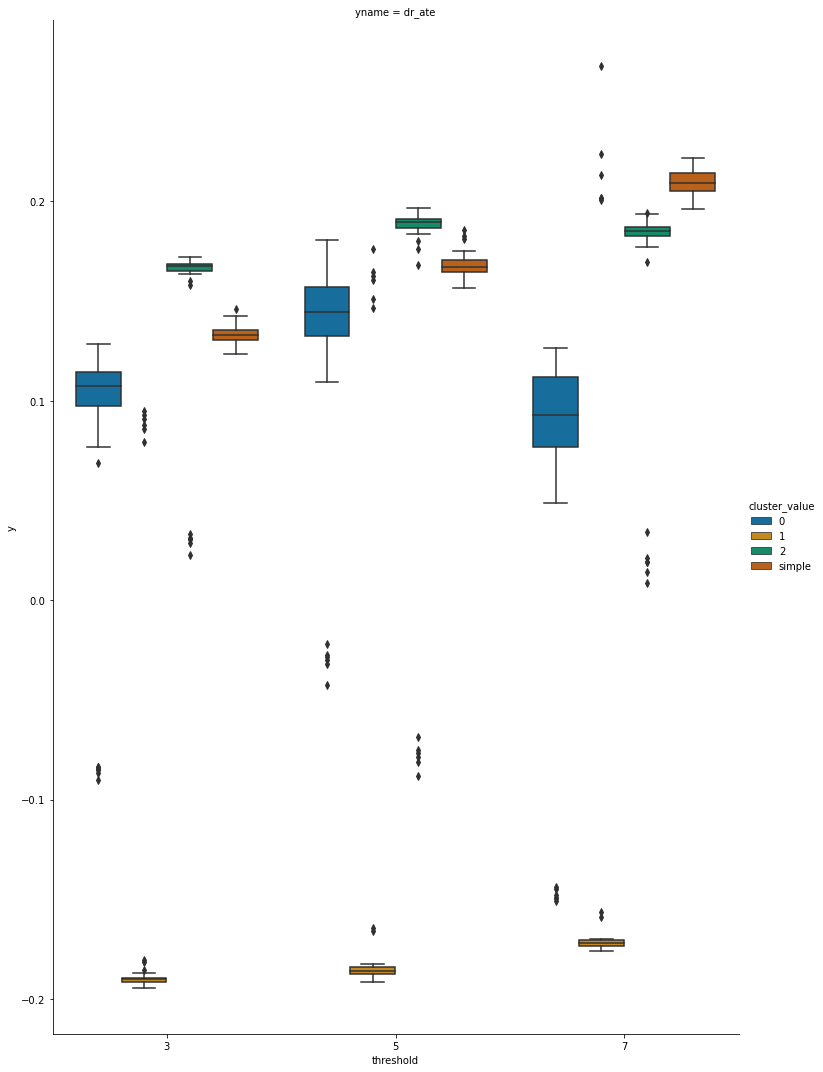

In [270]:
def ate_groups(ct,n_iters = 60, 
               categorical_confounders= None,
               use_limits=True,
               use_dose_confounders=False,
               include_mimic= True,
               min_pval=.25, **kwargs):
    if categorical_confounders is None:
        categorical_confounders=[
                't4','t3',
                'n2','n3',
                'hpv',
                'BOT','Tonsil',
                'IMRT','VMAT',
            ]
    if use_limits:
        limits = [
            'Parotid_Gland_limit',
            'SPC_limit','IPC_limit','MPC_limit',
            "Esophagus_limit",
            'Larynx_limit'
        ]
        for l in limits:
            if l not in categorical_confounders:
                categorical_confounders.append(l)
    
    dose_ate = ct.get_ate(n_iters=n_iters,
               confounder_pval_filter=min_pval,
               use_dose_confounders=use_dose_confounders,
               categorical_confounders=categorical_confounders,
#                clusters=[1,ct.n_clusters-1],
                skip_first=False,
               use_mimic=False,
                aggregate=False,
                **kwargs)
    if include_mimic:
        mimic_ate = ct.get_ate(n_iters=n_iters,
                   confounder_pval_filter=min_pval,
                   use_dose_confounders=use_dose_confounders,
                   categorical_confounders=categorical_confounders,
                   skip_first=True,
                   use_mimic=True,
                    aggregate=False,
                    **kwargs)
        mimic_ate.cluster_value = mimic_ate.cluster_value.apply(lambda x: 'simple' if x == 1 else x)
        dose_ate = pd.concat([dose_ate,mimic_ate],ignore_index = True)
    plot_ate(dose_ate)
    return dose_ate

def plot_ate(df,y = ['dr_ate'],kind='box',minval = -100,maxval =100,height=15):
    dfs =[]
    for ytemp in y:
        tempdf = df.copy()
        tempdf['y'] = tempdf[ytemp]
        tempdf['yname'] = ytemp
        tempdf = tempdf[tempdf['y'] >= minval]
        tempdf = tempdf[tempdf['y'] <= maxval]
        dfs.append(tempdf)
    df = pd.concat(dfs,axis=0,ignore_index=True)
    chart = sns.catplot(
        data = df,
        kind=kind,
        x = 'threshold',
        y = 'y',
        hue='cluster_value',
        palette='colorblind',
        col='yname',
        height=height,
        aspect=.7*len(y),
#         notch=True,
#         showfliers=False,
    )

# pd.options.mode.chained_assignment = None
d = ate_groups(ct2,
                 n_iters=60,
               thresholds=[3,5,7],
                 min_pval = 1,
               use_iptw=False,
               categorical_confounders=['t_severe','hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'],
               use_limits=False,
                )

In [271]:
# plot_ate(d,y=['dr_ate'],kind='bar')
# aggregate_ate_results(d).drop(['dr_ate_sig','dr_ate_positive','confounders'],axis=1)

treated_mean  untreated_mean  treated_0.25  untreated_0.25  \
cluster                                                               
0            0.508182        0.075449      0.398547        0.009671   
1            0.474525        0.255521      0.301179        0.134600   
2            0.754792        0.303018      0.675361        0.035617   
simple       0.474525        0.255521      0.301179        0.134600   

         treated_0.5  untreated_0.5  treated_0.75  untreated_0.75  
cluster                                                            
0           0.503311       0.013558      0.595738        0.026517  
1           0.559704       0.223839      0.652855        0.319971  
2           0.810303       0.179398      0.887711        0.536268  
simple      0.559704       0.223839      0.652855        0.319971

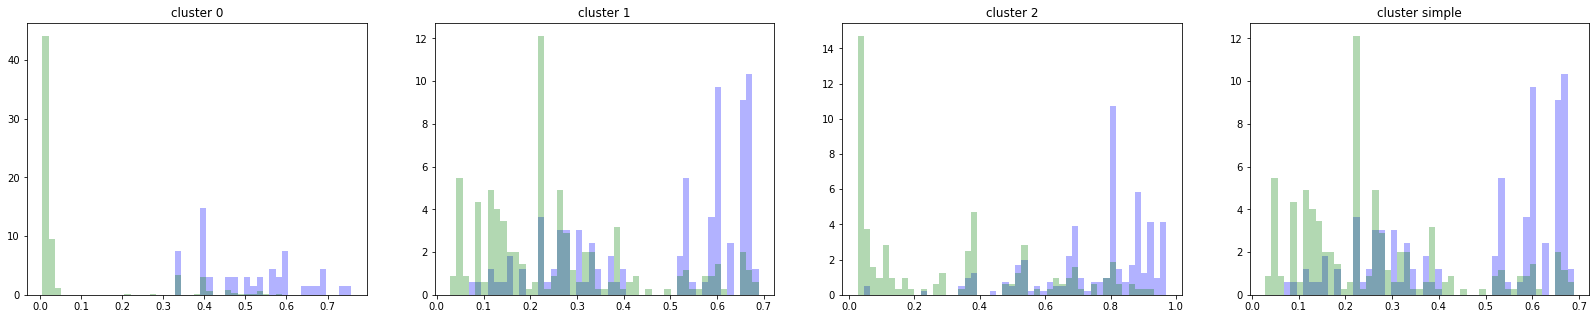

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

In [272]:
prop_df = ct2.all_propensity_scores(categorical_confounders= [
    't_severe','hpv','n_severe',
    'BOT', 'Tonsil', 
    'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'
])
prop_df = prop_df.set_index('cluster')
prop_df = prop_df.loc[[0,1,2,'simple'],:]
fig,axes = plt.subplots(1,prop_df.shape[0],figsize=(prop_df.shape[0]*7,5))
i = 0
for cluster,row in prop_df.iterrows():
    t = row['treated'].reshape(-1,1)
    ut = row['untreated'].reshape(-1,1)
    minval = np.min([t.min(),ut.min()])
    maxval= np.max([t.max(),ut.max()])
    axis = axes[i]
    axis.hist(t,color='blue',alpha=.3,bins=np.linspace(minval,maxval),density=True)
    axis.hist(ut,color='green',alpha=.3,bins=np.linspace(minval,maxval),density=True)
    axis.set_title('cluster ' + str(cluster))
    i += 1
prop_df[['treated_mean','untreated_mean','treated_0.25','untreated_0.25','treated_0.5','untreated_0.5','treated_0.75','untreated_0.75']]

In [ ]:
#### show_dems(ct)

In [251]:
show_dems(ct2)

counts
0     44
1    122
2    213
Name: cluster, dtype: int64
--mimic--
200
_________________
_________________
is_male
             pval      tval overall_pval       False         True
cluster                                                          
0        0.962362  0.002227     0.883934   5 (11.4)%   39 (88.6)%
1        0.788684  0.071835     0.883934   11 (9.0)%  111 (91.0)%
2        0.960466  0.002457     0.883934  22 (10.3)%  191 (89.7)%
--mimic--
pval                    1.0
tval                    0.0
overall_pval            1.0
False            20 (10.0)%
True            180 (90.0)%
Name: 1, dtype: object
_________________
_________________
t_stage
             pval       tval overall_pval          t0          t1          t2  \
cluster                                                                         
0        0.706444   2.958109     0.000241    4 (9.8)%  12 (29.3)%  12 (29.3)%   
1        0.000013  30.303747     0.000241    9 (7.4)%  53 (43.4)%  47 (38.5)%   
2        

In [20]:
# filterct = ClusterTester(sddf,
#                    ooi,
#                    n_clusters=n,
#                    cluster_features=cfeatures,
#                    filter_outliers=True, 
#                   )

# eval_ct(filterct)

In [21]:
# alt_ct = ClusterTester(sddf,
#                    ['Tongue','Genioglossus_M','Mylogeniohyoid_M','Rt_Parotid_Gland','Lt_Parotid_Gland','Rt_Submandibular_Gland','Lt_Submandibular_Gland'],
#                    n_clusters=n,
#                    cluster_features=cfeatures,
# #                    default_confounders = ['t_severe','n_severe','hpv','age','Parotid_Gland_limit']
#                   )
# eval_ct(alt_ct)

In [22]:
# minict = ClusterTester(sddf,['Tongue','Rt_Submandibular_Gland'],n_clusters=n,cluster_features=cfeatures)
# eval_ct(minict)

In [89]:
choke_organs = [
   'IPC','MPC',
    'Mylogeniohyoid_M',
    'Supraglottic_Larynx',
    'Rt_Submandibular_Gland',
#     'Lt_Submandibular_Gland',
]
choke_ct = ClusterTester(chokedf,
                       choke_organs,
                       symptoms=['choke'],
                       n_clusters=3,
                       default_confounders=[
                           'hpv',
                           'Esophagus_limit','IPC_limit','MPC_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V30','V35','V40','V45','V50','V55','V60','V65','V70']
                      )
eval_ct(choke_ct)

V70_Mylogeniohyoid_M>4.0, V50_Supraglottic_Larynx>52.0, max_dose_Rt_Submandibular_Gland>59.0, V55_MPC>33.0
[21.238361146405463, 0.03601943329194648, 0.043947623836079835]


lrt_pval  \
threshold cluster    confounders                                                        
-7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.135857e-04   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.898477e-07   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  6.187861e-05   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.433329e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.453773e-04   
-5        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  6.907147e-04   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.215518e-07   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.452772e-04   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.695170e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  4.235244e-03   
-3        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.307030e-02   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.725435e-04   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  9.270182e-03   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.625044e-02   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  6.309239e-03   
-1        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.610180e-01   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.021322e-01   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.269505e-01   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.095490e-01   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.104126e-02   
 0        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.277002e-02   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  7.431023e-02   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.555643e-01   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  8.287719e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  6.426551e-02   
 3        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  3.238033e-03   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.089442e-04   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.036899e-03   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.209023e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.170628e-03   
 5        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  9.784218e-04   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  4.157123e-05   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.925031e-04   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.130766e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  4.028228e-03   
 7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  7.161703e-04   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  5.223353e-06   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  1.414945e-04   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.984589e-03   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  2.961572e-03   

                                                                         delong_pval  \
threshold cluster    confounders                                                       
-7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...     0.991657   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...   

In [86]:
swallow_organs = [
    'IPC','MPC',
    'Mylogeniohyoid_M',
    'Supraglottic_Larynx',
    'Rt_Submandibular_Gland',
    'Lt_Submandibular_Gland'
]
swallow_ct = ClusterTester(swallowdf,
                       swallow_organs,
                       symptoms=['swallow'],
                       n_clusters=3,
                       default_confounders= ['hpv',
                           'Esophagus_limit','IPC_limit','MPC_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'],
                       cluster_features=['V30','V35','V40','V45','V50','V55','V60','V65','V70'],
                      )
eval_ct(swallow_ct)

V70_Lt_Submandibular_Gland>5.0, mean_dose_MPC>56.0, V60_Supraglottic_Larynx>41.0
[30.80258307773043, 0.13375514816682751, 0.30131663239404194]


lrt_pval  \
threshold cluster    confounders                                                    
-7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.005970   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000019   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.001406   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.010915   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.019510   
-5        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000112   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.003062   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000024   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000320   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.017727   
-3        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.124434   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.022584   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.195003   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.043875   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.016953   
-1        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.172987   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.071110   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.608066   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.420095   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.133297   
 0        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.032085   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000014   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.715494   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.046559   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.029911   
 3        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.118964   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.255154   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.230824   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.044187   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.018363   
 5        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000092   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.036329   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000018   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000317   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.039416   
 7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000011   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.004247   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000002   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.000082   
          simplified hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...  0.001319   

                                                                         delong_pval  \
threshold cluster    confounders                                                       
-7        -1         hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...     0.705517   
          0          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...     0.145628   
          1          hpv,Esophagus_limit,IPC_limit,MPC_limit,perform...     0.664117   
          2          hpv,Esophagus_limit,IPC_limit,MPC_limit,p

In [25]:
show_dems(choke_ct)

counts
0     92
1    133
2    125
Name: cluster, dtype: int64
--mimic--
127
_________________
_________________
is_male
             pval      tval overall_pval       False         True
cluster                                                          
0        0.759763  0.093509     0.155512  11 (12.0)%   81 (88.0)%
1        0.217927  1.517971     0.155512  18 (13.5)%  115 (86.5)%
2        0.087191  2.925481     0.155512    8 (6.4)%  117 (93.6)%
--mimic--
pval               0.074926
tval               3.171669
overall_pval       0.074926
False              8 (6.3)%
True            119 (93.7)%
Name: 1, dtype: object
_________________
_________________
t_stage
             pval       tval overall_pval          t0          t1          t2  \
cluster                                                                         
0        0.127714   8.565225     0.063613    6 (6.8)%  36 (40.9)%  32 (36.4)%   
1        0.693258   3.043637     0.063613  14 (10.7)%  41 (31.3)%  51 (38.9)%   
2        

In [236]:
from sklearn.preprocessing import quantile_transform

def fold_i_of_k(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

def stratify_cluster(traindf,testdf,as_rank=True,key='x'):
    res = []
    for c, subdf in traindf.groupby('x'):
        mean_y = subdf.outcome.mean()
        res.append((c,mean_y))
    res = sorted(res,key = lambda x: x[1])
#     print(res)
    maxR = np.max([x[1] for x in res])
    res = {k: v/(maxR+1) for (k,v) in res}
    ypred = testdf[key].apply(lambda x: res.get(x,0)).values
    if as_rank:
        ranks = sorted(np.unique(ypred))
        denom = max(1,len(ranks)-1)
        ypred = np.array([ranks.index(i)/denom for i in ypred])
    return ypred

def unsupervised_predictors(ct,mimic=False,as_probability=True,as_rank=True,threshold=-1,n_cvs=10):
    df = ct.get_cluster_df(use_mimic=mimic)
    df = df.copy()
    outcome = ct.get_outcome(threshold=threshold)
    df['outcome'] = outcome
    df['x'] = df.dose_clusters#.astype(str) + df.performance_high.astype('str')
    ypreds = []
    subdfs = np.array_split(df,n_cvs)
    for subdf in subdfs:
        traindf = df.drop(index=subdf.index)
        ypred = stratify_cluster(traindf,subdf,as_rank=as_rank)
        ypreds.append(ypred)
    ypred = np.concatenate(ypreds,axis=0)
    if as_probability:
        ypred = np.stack([1-ypred,ypred],axis=1)
    return ypred

unsupervised_predictors(ct2,mimic=True,threshold=3)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [269]:
def predict_ntcp_cv(ct,clinical=None,model=None,threshold=5):
    df = ct.df.copy()
    organs = [
        'Lt_Parotid_Gland','Rt_Parotid_Gland',
        'Lt_Submandibular_Gland','Rt_Submandibular_Gland',
        'Soft_Palate',
        'Upper_Lip','Lower_Lip',
        'Extended_Oral_Cavity',
        'Mylogeniohyoid_M',
    ]
    #I don't use their clinical stuff tho
    if clinical is None:
        clinical = ct.default_confounders[:]
    opositions = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    vals = df.mean_dose.apply(lambda x: [x[i] for i in opositions]).values
    vals = np.stack(vals)
    cvals = df[clinical].values.astype(int)
    x = np.hstack([vals,cvals])
    y = ct.get_outcome(threshold=threshold)
    if model is None:
        model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
    ypred = predict_cv(model,x,y)
    return y,ypred

def ntcp_model(ct,clinical=None,model=None):
    #parameters of ntcp model from https://www.sciencedirect.com/science/article/pii/S016781401200117X#s0060
    #suppelment stuff.  They also uses cheeks and sublingual glands which i use oral cavity  and mylogeniohyoid instead
    res= []
    for threshold in [3,5,7]:
        y,ypred = predict_ntcp_cv(ct,clinical=clinical,model=model,threshold=threshold)
        metrics = get_stratification_metrics(y,ypred)
        metrics['threshold'] = threshold
        res.append(metrics)
    return pd.DataFrame(res)

ntcp_model(ct2)

roc       mcc        dor  accuracy  precision    recall        f1  \
0  0.637890  0.161825  12.456763  0.659631   0.837945  0.706667  0.766727   
1  0.575350  0.092421   2.651756  0.556728   0.593886  0.644550  0.618182   
2  0.614242  0.161715   1.093458  0.580475   0.421622  0.600000  0.495238   

     f_half        f2  threshold  
0  0.807927  0.729525          3  
1  0.603372  0.633737          5  
2  0.448276  0.553191          7

roc       mcc       dor  \
threshold outcome  use_change name                                       
3         drymouth False      base        0.515103  0.029846  4.211362   
                              clusters    0.652048  0.209061  8.039062   
                              ntcp        0.578618  0.064472  8.094819   
                              simplified  0.601818  0.167248  6.595420   
                   True       base        0.526047  0.094574  2.763480   
                              clusters    0.605169  0.182537  3.600000   
                              ntcp        0.595656  0.098864  4.827458   
                              simplified  0.570792  0.134247  2.968488   
5         drymouth False      base        0.552160  0.070028  1.751683   
                              clusters    0.636761  0.234114  2.902045   
                              ntcp        0.587472  0.159438  3.375492   
                              simplified  0.600261  0.199618  2.513502   
                   True       base        0.536463  0.117816  1.223725   
                              clusters    0.632319  0.242632  1.955372   
                              ntcp        0.584341  0.156101  2.130221   
                              simplified  0.599416  0.196240  1.583804   
7         drymouth False      base        0.511629  0.039084  0.572156   
                              clusters    0.614252  0.193183  1.145022   
                              ntcp        0.582796  0.063049  0.624675   
                              simplified  0.590505  0.168605  1.010126   
                   True       base        0.520265  0.041906  0.251250   
                              clusters    0.611555  0.180023  0.784683   
                              ntcp        0.592027  0.068149  0.418326   
                              simplified  0.600233  0.166218  0.720588   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.517143   0.797753  0.516364   
                              clusters    0.574286   0.875000  0.534545   
                              ntcp        0.608571   0.805310  0.661818   
                              simplified  0.557143   0.857143  0.523636   
                   True       base        0.545714   0.704545  0.536797   
                              clusters    0.580000   0.750000  0.545455   
                              ntcp        0.591429   0.694690  0.679654   
                              simplified  0.557143   0.726190  0.528139   
5         drymouth False      base        0.537143   0.584699  0.554404   
                              clusters    0.614286   0.672619  0.585492   
                              ntcp        0.588571   0.615023  0.678756   
                              simplified  0.597143   0.654762  0.569948   
                   True       base        0.557143   0.474576  0.575342   
                              clusters    0.622857   0.541667  0.623288   
                              ntcp        0.557143   0.478873  0.698630   
                              simplified  0.600000   0.517857  0.595890   
7         drymouth False      base        0.517143   0.335227  0.531532   
                              clusters    0.597143   0.410714  0.621622   
                              ntcp        0.531429   0.346821  0.540541   
                              simplified  0.585714   0.398810  0.603604   
                   True       base        0.571429   0.241135  0.441558   
                              clusters    0.585714   0.297619  0.649351   
                              ntcp        0.531429   0.248555  0.558442   
                              simplified  0.580000   0.291667  0.636364   

                                                f1    f_half        f2  \
threshold outcome  use_change name                                       
3         drymouth Fals

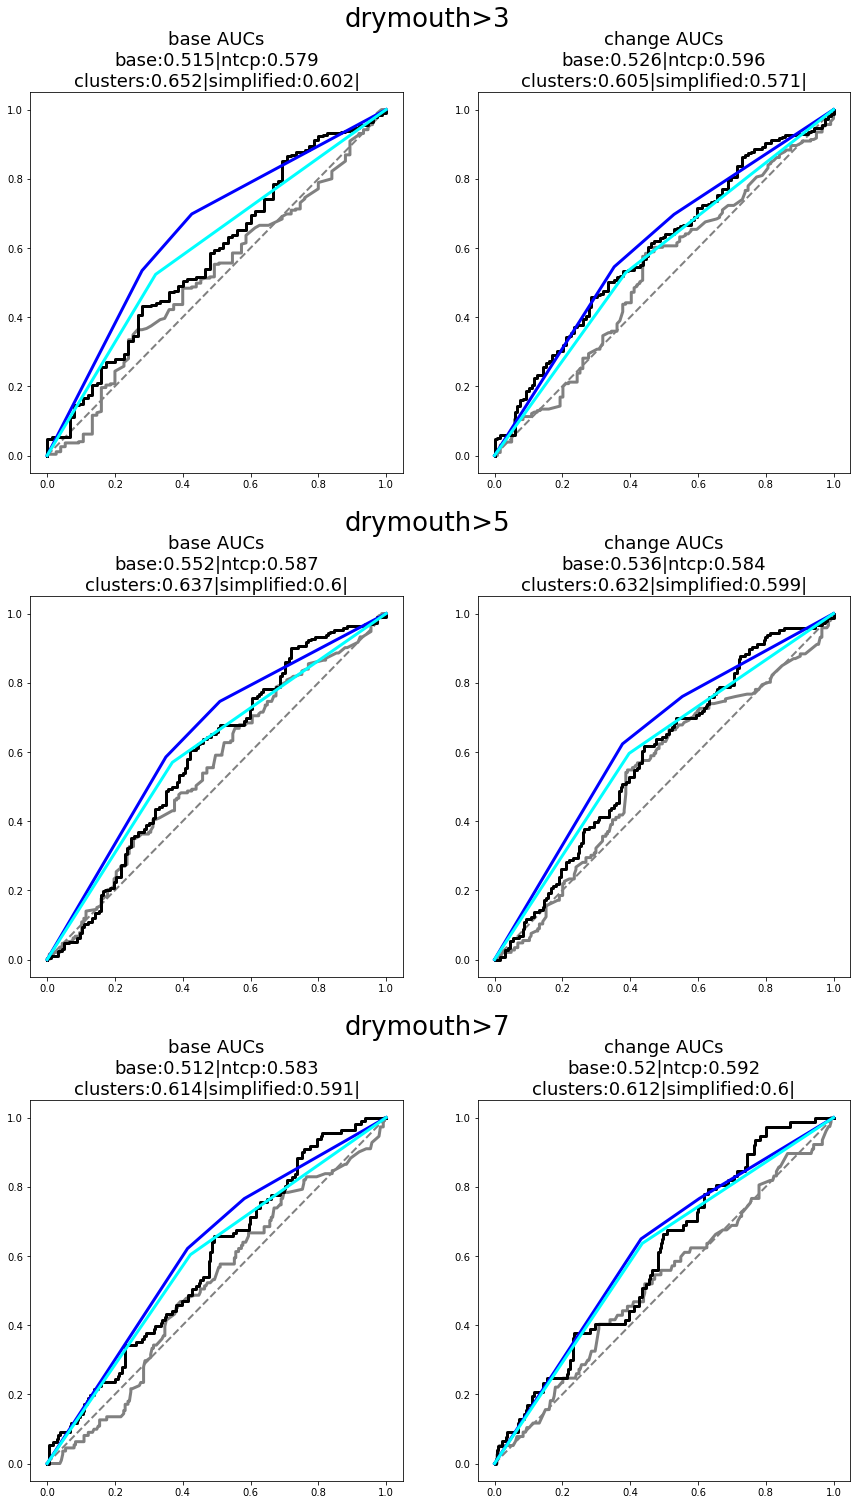

In [265]:

def plot_roc_curves(ct_list,thresholds=None,size=7,**kwargs):
    if thresholds is None:
        thresholds = [3,5,7]
    figsize=(2.1*size,size*len(thresholds))
    fig = plt.figure(constrained_layout=True,figsize=figsize)
    subfigures = fig.subfigures(len(thresholds),1)
    
    res = []
    for i, t in enumerate(thresholds):
        axes = subfigures[i].subplots(1,2)
        for row,use_change in enumerate([False,True]):
            axis= axes[row]
            for c in ct_list:
                y, y1, y0 = c.predict_cv(threshold=t,use_mimic=False,use_change=use_change,**kwargs)

#                 _, y2, y0_alt = c.predict_cv(threshold=t,use_mimic=True,use_change=use_change,**kwargs)
                
                #these are just static stratifications
                y3 = unsupervised_predictors(c, mimic=False,threshold=t)
                y4 = unsupervised_predictors(c, mimic=True,threshold=t)
                
                _, y5 = predict_ntcp_cv(c,threshold=t)
                axis.plot([0,1],[0,1],color='grey',linestyle='dashed',linewidth=2)
                colors = [
                    'grey','black',
                    'blue','cyan',
#                     'brown','green',
                ]
                names = [
                    'base','ntcp',
#                     'clust_lr','simple_lr',
                    'clusters','simplified',
                ]
                pstring = lambda p: str(np.round(p,2))
                title = ('change' if use_change else 'base') + ' AUCs\n'
                to_plot = [
                    y0,y5,
#                     y1,y2,
                    y3,y4,
                ]
                for iii, ycurr in enumerate(to_plot):
                    (fpr, tpr, _threh) = roc_curve(y,ycurr[:,1])
                    axis.plot(fpr,tpr,color=colors[iii],linewidth=3)
                    performance = get_stratification_metrics(y,ycurr)
                    pval = np.round(delong(y.astype(int), ycurr[:,1], y0[:,1])[0][0],3)
                    entry = {
                        'threshold': t,
                        'use_change': use_change,
                        'outcome': ','.join(ct.symptoms),
                        'name': names[iii],
                    }
                    for k,v in performance.items():
                        entry[k] = v
                    entry['delong_pval'] = pval
                    res.append(entry)
#                     print(names[iii],performance['roc'],pval)
                    title += names[iii] + ':' + str(np.round(performance['roc'],3))
                    if iii == 1:
                        title += '\n'
                    else:
                        title += '|'
                axis.set_title(title,fontdict={'fontsize': 18})
        suptitle = ''.join(ct_list[0].symptoms) + '>' + str(t) + '\n'
        subfigures[i].suptitle(suptitle,fontsize=26,y=1.05)
    plt.subplots_adjust(hspace=.4)
#     fig.tight_layout()
    return pd.DataFrame(res).groupby(['threshold','outcome','use_change','name']).first()

def plot_roc_sets(ct,df=None,organs=None,features=None, symptomlists = None, model=None,confounders=None,n_clusters=None,**kwargs):
    if organs is None:
        organs = ct.cluster_organs[:]
    if df is None:
        df = ct.df.copy()
    if symptomlists is None:
        symptomlists = [
            ct.symptoms,
        ]
    if confounders is None:
        confounders = ct.default_confounders[:]
    if n_clusters is None:
        n_clusters = ct.n_clusters
    if features is None:
        features = ct.cluster_features[:]
    cts = []
    for symptoms in symptomlists:
        ctester = ClusterTester(df,
                       organs,
                       symptoms=symptoms, 
                       confounders=confounders,
                       n_clusters = n_clusters,
                        cluster_features=features,
                       **kwargs,
                      )
        cts.append(ctester)
    return plot_roc_curves(cts,model=model)

plot_roc_sets(ct)

roc       mcc        dor  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.524135  0.024691   4.662050   
                              clusters    0.659367  0.227788  11.239766   
                              ntcp        0.637890  0.161825  12.456763   
                              simplified  0.606498  0.182938  13.095571   
                   True       base        0.536680  0.143674   4.047491   
                              clusters    0.613160  0.199396   5.535208   
                              ntcp        0.611197  0.133719   6.542222   
                              simplified  0.588240  0.173578   7.291043   
5         drymouth False      base        0.540566  0.097099   2.223529   
                              clusters    0.625339  0.218569   3.626314   
                              ntcp        0.575350  0.092421   2.651756   
                              simplified  0.592276  0.193853   4.855989   
                   True       base        0.520490  0.122408   1.557951   
                              clusters    0.612702  0.206685   2.343359   
                              ntcp        0.582441  0.112127   1.848739   
                              simplified  0.600496  0.210709   3.600088   
7         drymouth False      base        0.523540  0.066954   0.860522   
                              clusters    0.623509  0.212172   1.840800   
                              ntcp        0.614242  0.161715   1.093458   
                              simplified  0.593111  0.186922   2.493768   
                   True       base        0.467786 -0.028985   0.283058   
                              clusters    0.621743  0.199140   1.322500   
                              ntcp        0.622322  0.135868   0.686022   
                              simplified  0.611385  0.203423   2.197977   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.527704   0.800995  0.536667   
                              clusters    0.627968   0.873239  0.620000   
                              ntcp        0.659631   0.837945  0.706667   
                              simplified  0.664908   0.844622  0.706667   
                   True       base        0.577836   0.746269  0.579151   
                              clusters    0.614776   0.765258  0.629344   
                              ntcp        0.620053   0.727273  0.710425   
                              simplified  0.635884   0.741036  0.718147   
5         drymouth False      base        0.554090   0.600000  0.597156   
                              clusters    0.614776   0.652582  0.658768   
                              ntcp        0.556728   0.593886  0.644550   
                              simplified  0.609499   0.625498  0.744076   
                   True       base        0.554090   0.490385  0.618182   
                              clusters    0.593668   0.525822  0.678788   
                              ntcp        0.540897   0.480349  0.666667   
                              simplified  0.577836   0.509960  0.775758   
7         drymouth False      base        0.517150   0.371981  0.592308   
                              clusters    0.580475   0.431925  0.707692   
                              ntcp        0.580475   0.421622  0.600000   
                              simplified  0.532982   0.406375  0.784615   
                   True       base        0.485488   0.235602  0.478723   
                              clusters    0.554090   0.323944  0.734043   
                              ntcp        0.564644   0.308108  0.606383   
                              simplified  0.501319   0.310757  0.829787   

                                                f1    f_half        f2  \
threshold outcome  use_change name                                     

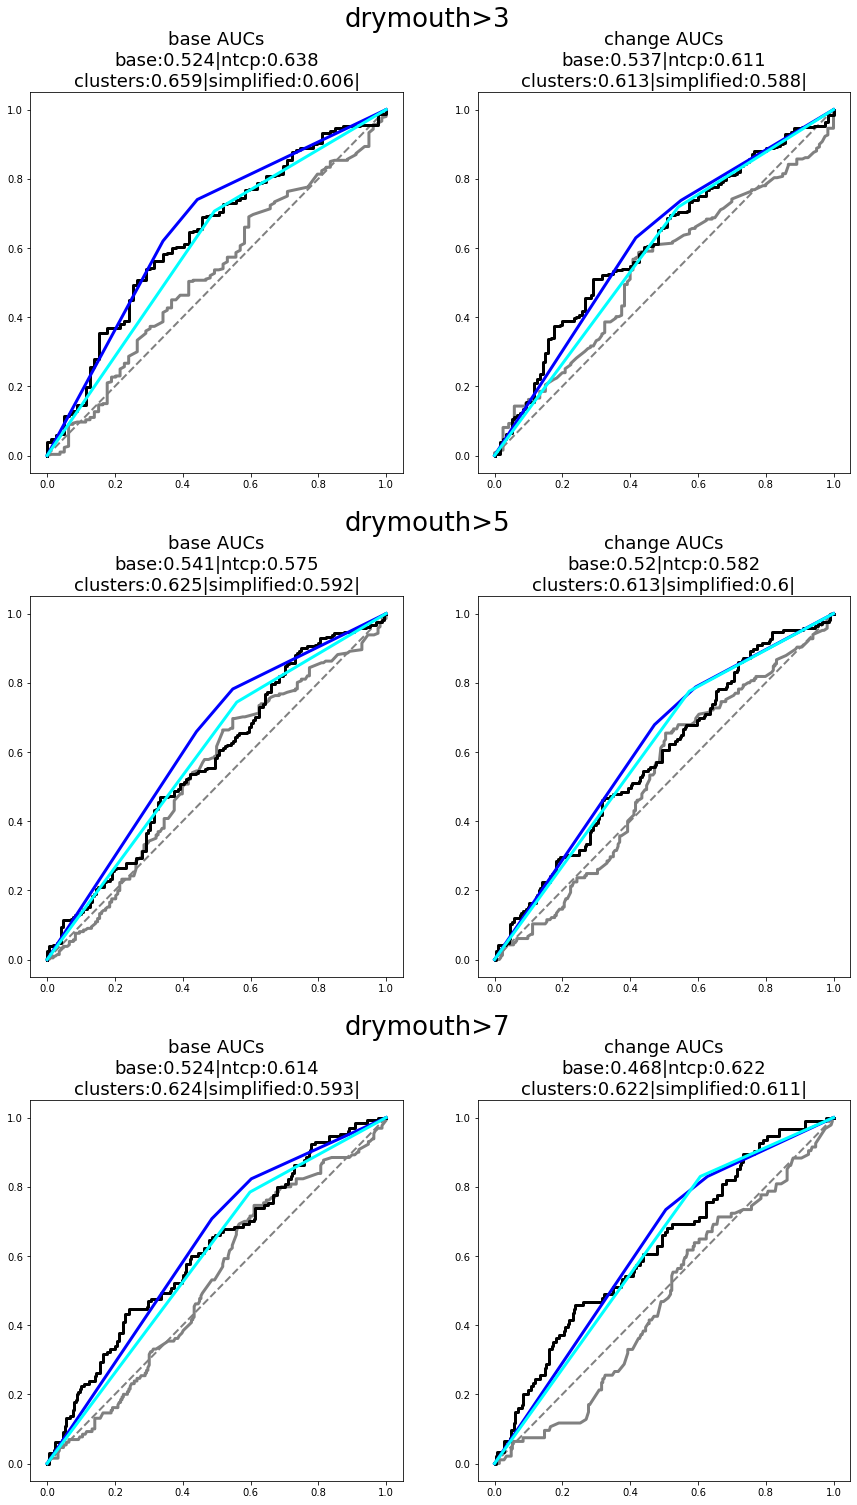

In [266]:
plot_roc_sets(ct2)

roc       mcc        dor  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.524135  0.024691   4.662050   
                              clusters    0.664684  0.232116  11.953145   
                              ntcp        0.637890  0.161825  12.456763   
                              simplified  0.606498  0.182938  13.095571   
                   True       base        0.536680  0.143674   4.047491   
                              clusters    0.622812  0.210632   6.081448   
                              ntcp        0.611197  0.133719   6.542222   
                              simplified  0.588240  0.173578   7.291043   
5         drymouth False      base        0.540566  0.097099   2.223529   
                              clusters    0.624774  0.215899   3.795219   
                              ntcp        0.575350  0.092421   2.651756   
                              simplified  0.592276  0.193853   4.855989   
                   True       base        0.520490  0.122408   1.557951   
                              clusters    0.617530  0.211800   2.543269   
                              ntcp        0.582441  0.112127   1.848739   
                              simplified  0.600496  0.210709   3.600088   
7         drymouth False      base        0.523540  0.066954   0.860522   
                              clusters    0.617362  0.201226   1.855212   
                              ntcp        0.614242  0.161715   1.093458   
                              simplified  0.593111  0.186922   2.493768   
                   True       base        0.467786 -0.028985   0.283058   
                              clusters    0.619746  0.194004   1.370246   
                              ntcp        0.622322  0.135868   0.686022   
                              simplified  0.611385  0.203423   2.197977   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.527704   0.800995  0.536667   
                              clusters    0.638522   0.872146  0.636667   
                              ntcp        0.659631   0.837945  0.706667   
                              simplified  0.664908   0.844622  0.706667   
                   True       base        0.577836   0.746269  0.579151   
                              clusters    0.625330   0.767123  0.648649   
                              ntcp        0.620053   0.727273  0.710425   
                              simplified  0.635884   0.741036  0.718147   
5         drymouth False      base        0.554090   0.600000  0.597156   
                              clusters    0.614776   0.648402  0.672986   
                              ntcp        0.556728   0.593886  0.644550   
                              simplified  0.609499   0.625498  0.744076   
                   True       base        0.554090   0.490385  0.618182   
                              clusters    0.593668   0.525114  0.696970   
                              ntcp        0.540897   0.480349  0.666667   
                              simplified  0.577836   0.509960  0.775758   
7         drymouth False      base        0.517150   0.371981  0.592308   
                              clusters    0.569921   0.424658  0.715385   
                              ntcp        0.580475   0.421622  0.600000   
                              simplified  0.532982   0.406375  0.784615   
                   True       base        0.485488   0.235602  0.478723   
                              clusters    0.543536   0.319635  0.744681   
                              ntcp        0.564644   0.308108  0.606383   
                              simplified  0.501319   0.310757  0.829787   

                                                f1    f_half        f2  \
threshold outcome  use_change name                                     

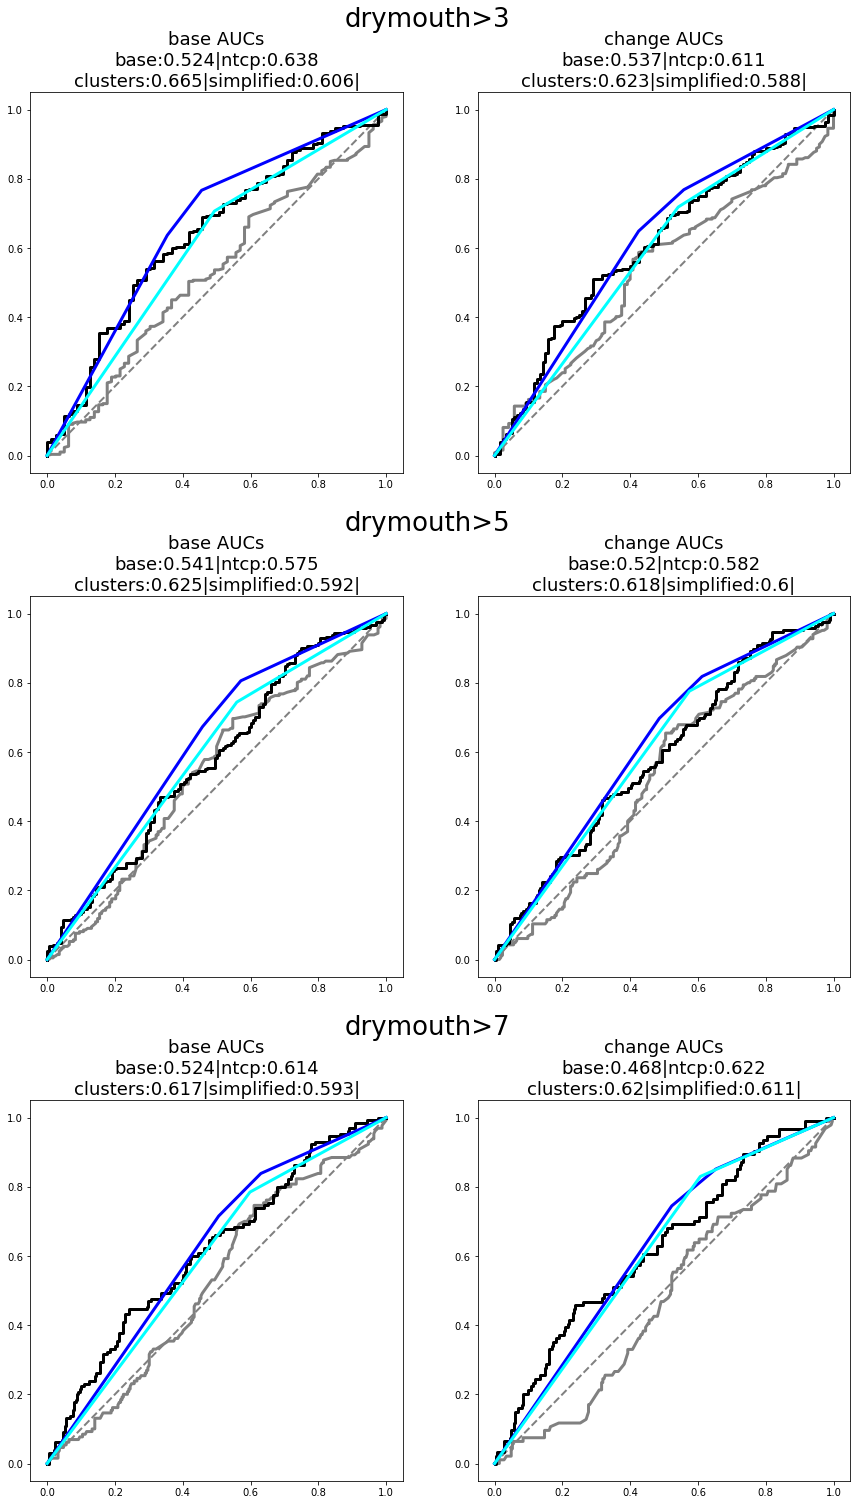

In [273]:
plot_roc_sets(ct2,
              organs=ct2.cluster_organs + ['Soft_Palate'],
              features=ct2.cluster_features + ['V25'],
             )

roc       mcc       dor  \
threshold outcome  use_change name                                     
3         drymouth False      base      0.622253  0.119652  0.360170   
                              clust_u   0.644148  0.236157  0.727602   
                              ntcp      0.653104  0.205719  0.811525   
                              simple_u  0.576342  0.129150  1.011236   
                   True       base      0.554154  0.072076  0.247253   
                              clust_u   0.646684  0.191622  0.446678   
                              ntcp      0.609583  0.144632  0.428922   
                              simple_u  0.539208  0.057687  0.449601   
5         drymouth False      base      0.602152  0.075124  0.122429   
                              clust_u   0.695081  0.191743  0.376068   
                              ntcp      0.607554  0.068340  0.106838   
                              simple_u  0.402108 -0.110929  0.035529   
                   True       base      0.556032  0.032510  0.058720   
                              clust_u   0.731415  0.219009  0.535537   
                              ntcp      0.648867  0.092121  0.109091   
                              simple_u  0.396448 -0.099372  0.021658   
7         drymouth False      base      0.508229 -0.011867  0.013093   
                              clust_u   0.730732  0.178659  0.335317   
                              ntcp      0.616588  0.120283  0.104381   
                              simple_u  0.570719  0.060700  0.187778   
                   True       base      0.571625  0.040253  0.048611   
                              clust_u   0.756181  0.199058  0.566929   
                              ntcp      0.628140  0.127048  0.108844   
                              simple_u  0.618132  0.092397  0.318584   

                                        accuracy  precision    recall  \
threshold outcome  use_change name                                      
3         drymouth False      base      0.619048   0.274648  0.487500   
                              clust_u   0.669312   0.338129  0.587500   
                              ntcp      0.611111   0.304094  0.650000   
                              simple_u  0.476190   0.252101  0.750000   
                   True       base      0.560847   0.176471  0.535714   
                              clust_u   0.658730   0.237410  0.589286   
                              ntcp      0.584656   0.204678  0.625000   
                              simple_u  0.428571   0.163866  0.696429   
5         drymouth False      base      0.629630   0.115108  0.484848   
                              clust_u   0.661376   0.158273  0.666667   
                              ntcp      0.642857   0.113636  0.454545   
                              simple_u  0.433862   0.058537  0.363636   
                   True       base      0.619048   0.070922  0.434783   
                              clust_u   0.666667   0.129496  0.782609   
                              ntcp      0.653439   0.090909  0.521739   
                              simple_u  0.439153   0.039024  0.347826   
7         drymouth False      base      0.716931   0.040816  0.235294   
                              clust_u   0.656085   0.093525  0.764706   
                              ntcp      0.722222   0.084906  0.529412   
                              simple_u  0.394180   0.054622  0.764706   
                   True       base      0.600529   0.046358  0.500000   
                              clust_u   0.658730   0.086331  0.857143   
                              ntcp      0.724868   0.075472  0.571429   
                              simple_u  0.396825   0.050420  0.857143   

                                              f1    f_half        f2  \
threshold outcome  use_change name                                     
3         drymouth False      base      0.351351  0.300926  0.422078   
                              clust_u   0.429224  0.36949

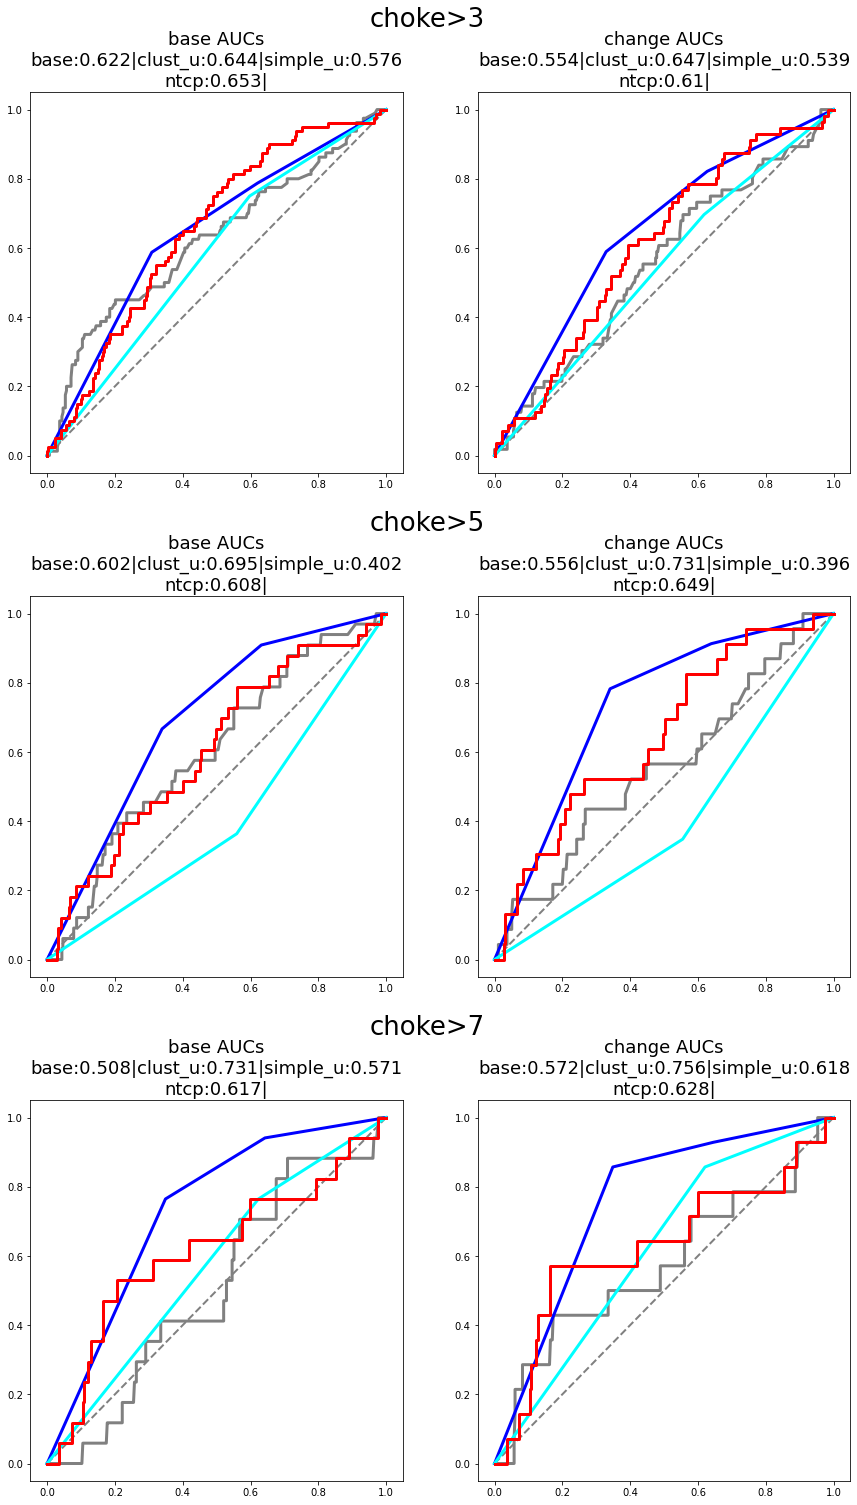

In [244]:
plot_roc_sets(choke_ct)

roc       mcc       dor  \
threshold outcome  use_change name                                     
3         drymouth False      base      0.584294  0.121986  1.357290   
                              clust_u   0.549627  0.079741  1.112141   
                              ntcp      0.572539  0.101863  1.773472   
                              simple_u  0.537467  0.075207  1.647491   
                   True       base      0.569036  0.113957  1.136006   
                              clust_u   0.555761  0.080626  0.651808   
                              ntcp      0.548530  0.044907  0.811200   
                              simple_u  0.545538  0.087982  1.018330   
5         drymouth False      base      0.604711  0.134511  0.443223   
                              clust_u   0.576990  0.111717  0.448305   
                              ntcp      0.567545  0.097942  0.449532   
                              simple_u  0.524486  0.041179  0.445157   
                   True       base      0.566220  0.047318  0.171468   
                              clust_u   0.593096  0.116067  0.305292   
                              ntcp      0.559515  0.065646  0.225287   
                              simple_u  0.541637  0.057522  0.294253   
7         drymouth False      base      0.550919  0.095530  0.187257   
                              clust_u   0.572570  0.083739  0.222661   
                              ntcp      0.513532  0.013577  0.128382   
                              simple_u  0.558566  0.078209  0.323025   
                   True       base      0.506103 -0.001777  0.056754   
                              clust_u   0.542430  0.057176  0.101746   
                              ntcp      0.538146  0.031092  0.077419   
                              simple_u  0.565728  0.064275  0.168421   

                                        accuracy  precision    recall  \
threshold outcome  use_change name                                      
3         drymouth False      base      0.559367   0.578313  0.497409   
                              clust_u   0.538259   0.554878  0.471503   
                              ntcp      0.551451   0.556650  0.585492   
                              simple_u  0.538259   0.543689  0.580311   
                   True       base      0.543536   0.414634  0.615942   
                              clust_u   0.556728   0.408537  0.485507   
                              ntcp      0.511873   0.384236  0.565217   
                              simple_u  0.530343   0.402913  0.601449   
5         drymouth False      base      0.614776   0.297297  0.511628   
                              clust_u   0.583113   0.280488  0.534884   
                              ntcp      0.564644   0.271676  0.546512   
                              simple_u  0.493404   0.242718  0.581395   
                   True       base      0.572559   0.156250  0.480769   
                              clust_u   0.588391   0.182927  0.576923   
                              ntcp      0.554090   0.161850  0.538462   
                              simple_u  0.488127   0.155340  0.615385   
7         drymouth False      base      0.635884   0.169118  0.479167   
                              clust_u   0.577836   0.158537  0.541667   
                              ntcp      0.548813   0.131737  0.458333   
                              simple_u  0.493404   0.150485  0.645833   
                   True       base      0.532982   0.062857  0.458333   
                              clust_u   0.572559   0.079268  0.541667   
                              ntcp      0.559367   0.071856  0.500000   
                              simple_u  0.477573   0.077670  0.666667   

                                              f1    f_half        f2  \
threshold outcome  use_change name                                     
3         drymouth False      base      0.534819  0.560093  0.511727   
                              clust_u   0.509804  0.53592

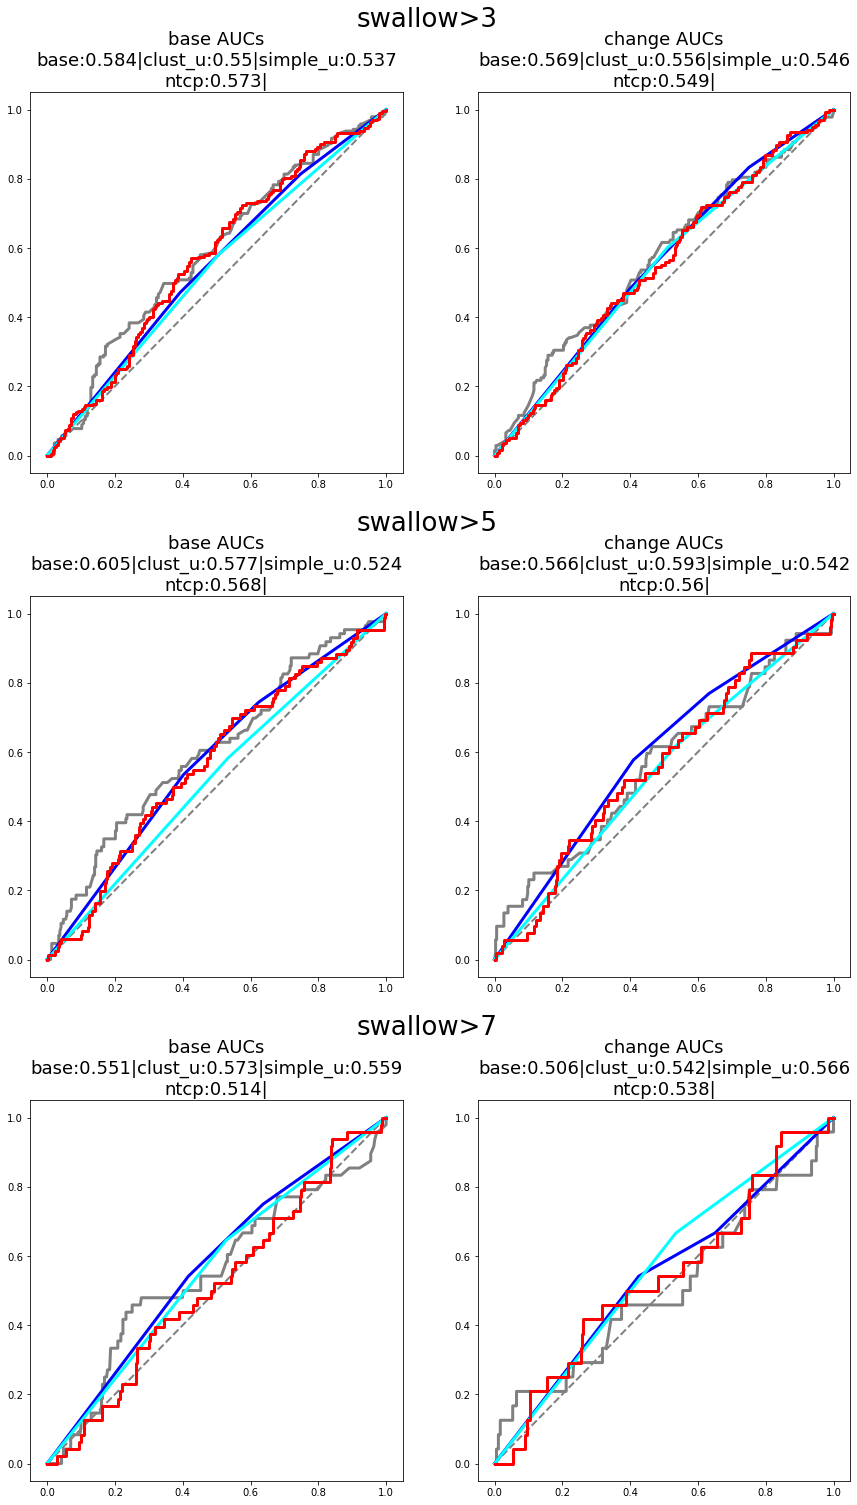

In [245]:
plot_roc_sets(swallow_ct)

In [30]:
# plot_roc_sets(sddf,
#               ['Tongue','Rt_Submandibular_Gland'],
#               n_clusters = 3,
#               cluster_features= cfeatures,
#              )

In [31]:
# plot_roc_sets(sddf,
#               ooi+['Mylogeniohyoid_M','Genioglossus_M'],
#               n_clusters = 3,
#               cluster_features= cfeatures,
#              )

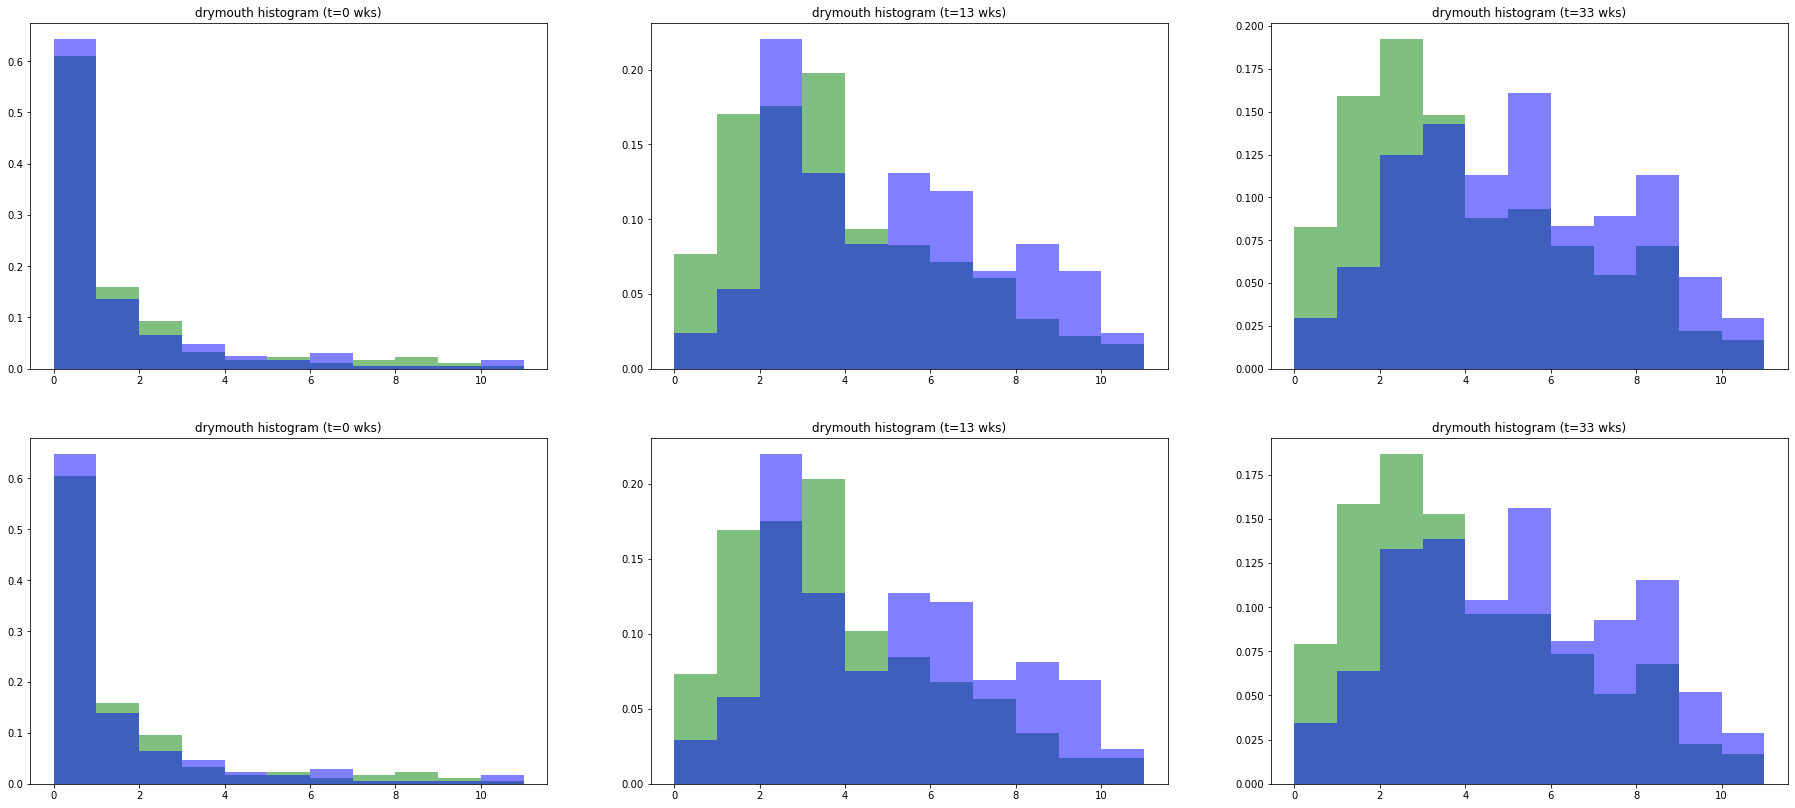

In [32]:
def symptom_histogram(ct,symptom=None,simplify=True,dates=[0,13,33],size=7,**kwargs):
    df = ct.get_cluster_df(**kwargs).copy()
    mimic_df = ct.get_cluster_df(use_mimic=True)
    if simplify:
        df['dose_clusters'] = df.dose_clusters == df.dose_clusters.max()
    df_dates =df.dates.iloc[0]
    dlocs = [df_dates.index(d) for d in dates if d in df_dates]
    if symptom is None:
        symptom = ct.symptoms[0]
    colors = ['green','blue']
    
    fig, axes = plt.subplots(2,len(dlocs),figsize = (1.5*len(dlocs)*size,2*size))
    for row, d in enumerate([df, mimic_df]):
        d['s'] = d['symptoms_'+symptom].apply(lambda x: [x[d] for d in dlocs])
        for cluster, subdf in d.groupby('dose_clusters'):
            color = colors[cluster]
            vals = np.stack(subdf.s.values)
            for i in range(len(dlocs)):
                axis = axes[row,i]
                hvals = vals[:,i]
                axis.hist(hvals,bins=[i for i in range(12)],color=color,alpha=.5,linewidth=4,histtype='stepfilled',density=True)
                axis.set_title(symptom + ' histogram (t=' + str(dates[i]) + ' wks)')
    return 
symptom_histogram(ct)

cluster 1 symptom at [0] [1.125, 1.6607142857142858, 2.2142857142857144]
cluster 2 symptom at [0] [0.626984126984127, 0.8968253968253969, 1.1984126984126984]
cluster 3 symptom at [0] [0.8333333333333334, 1.0952380952380953, 1.4047619047619047]
cluster 3 (simplified) symptom at [0] [0.8439306358381503, 1.069364161849711, 1.3583815028901733]
cluster 1 symptom at [13, 33] [4.535714285714286, 5.107142857142857, 5.732142857142857]
cluster 2 symptom at [13, 33] [3.7698412698412698, 4.103174603174603, 4.4523809523809526]
cluster 3 symptom at [13, 33] [5.392857142857143, 5.714285714285714, 6.059523809523809]
cluster 3 (simplified) symptom at [13, 33] [5.393063583815029, 5.682080924855492, 6.005780346820809]


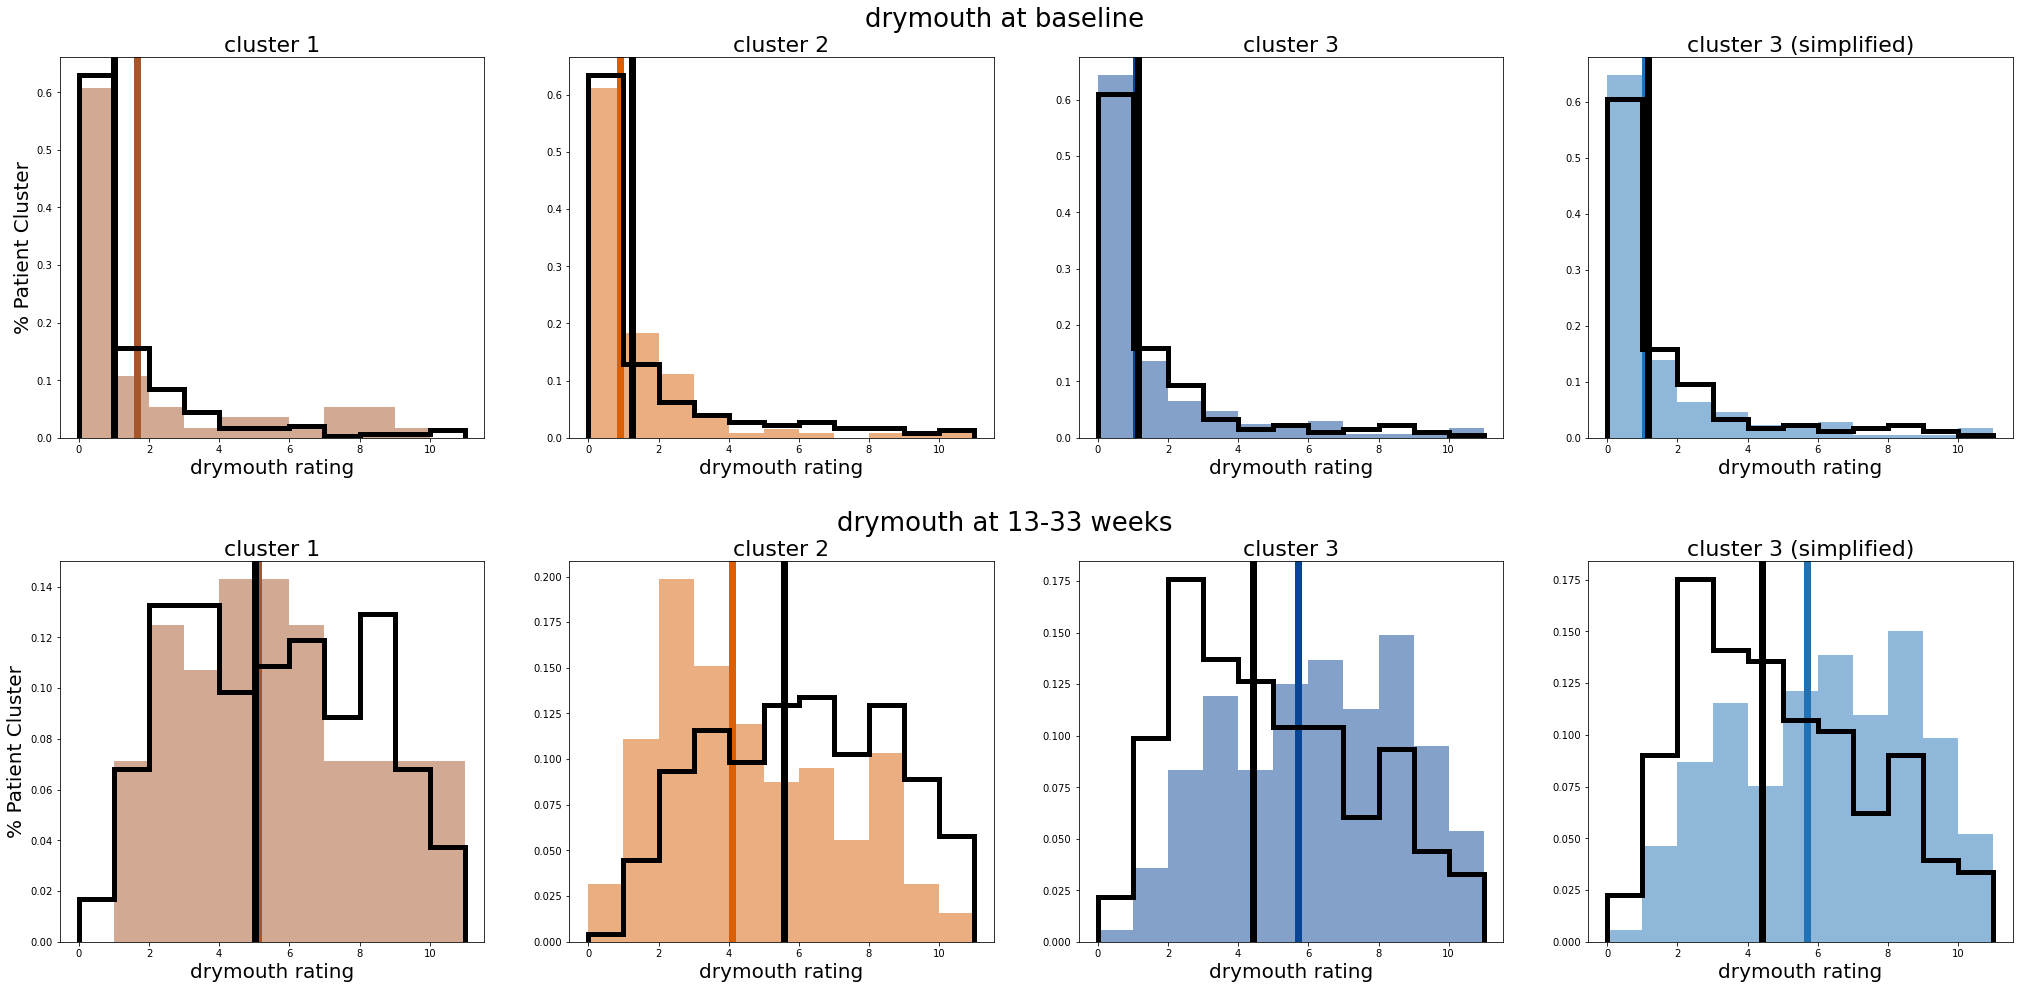

In [33]:
def bootstrap_conf_interval(vals, n = 200):
    results = []
    for i in range(n):
        tempvals = np.random.choice(vals,size=len(vals),replace=True)
        results.append(tempvals.mean())
    results = sorted(results)
    minval = results[int(len(results)*.05)]
    maxval =results[int(len(results)*.95)]
    return [minval, vals.mean(), maxval] 

def symptom_histogram_alt(ct,symptom=None,datelist=[[0],[13,33]],size=7,**kwargs):
    df = ct.get_cluster_df(**kwargs).copy()
    mimic_df = ct.get_cluster_df(use_mimic=True)
    
    cnames = []
    
    for cluster in sorted(df.dose_clusters.unique()):

        name = 'cluster ' + str(cluster+1)
        df[name] = df['dose_clusters'] == cluster
        cnames.append(name)
    cnames.append('cluster 3 (simplified)')
    df[cnames[-1]] = mimic_df.dose_clusters
    (figwidth,figheight) = ((ct.n_clusters+2)*size,len(datelist)*size)
    fig = plt.figure(figsize=(figwidth,figheight))
    subfigs = fig.subfigures(len(datelist),1,wspace=1)
    df_dates =df.dates.iloc[0]
    
    if symptom is None:
        symptom = ct.symptoms[0]
        
    for row, dates in enumerate(datelist):
        subfig = subfigs[row]
        weekstring = '-'.join([str(d) for d in dates]) if len(dates) > 1 else str(dates[0])  
        if weekstring == '0':
            weekstring = 'baseline'
        else:
            weekstring += ' weeks'
        subfig.suptitle(symptom + ' at ' + weekstring ,fontsize=26)
        axes = subfig.subplots(1,len(cnames))
        dlocs = [df_dates.index(d) for d in dates if d in df_dates]
        df['s'] = df['symptoms_'+symptom].apply(lambda x: np.max([x[d] for d in dlocs]))
        colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']

        for col, name in enumerate(cnames):
            axis = axes[col]
            for thing in [True,False]:
                color = colors[col]
                if thing is False:
                    color = 'black'
                subdf = df[df[name].astype(bool) == thing]
                hvals = subdf.s.values
                htype = 'stepfilled' if thing else 'step'
                alpha = 1 if (htype == 'step') else .5
                axis.hist(hvals,bins=[i for i in range(12)],color=color,alpha=alpha,linewidth=5,histtype=htype,density=True)
                if thing:
                    print(name, 'symptom at', dates, bootstrap_conf_interval(hvals))
                axis.axvline(hvals.mean(),color=color,linewidth=7) 
            axis.set_title(name,fontsize=22)
            axis.set_xlabel(symptom + ' rating',fontsize=20)
            if col <= 0:
                axis.set_ylabel('% Patient Cluster',fontsize=20)
    return 
symptom_histogram_alt(ct)

cluster 1 symptom at [0] [1.0454545454545454, 1.6818181818181819, 2.340909090909091]
cluster 2 symptom at [0] [0.5245901639344263, 0.7131147540983607, 0.9098360655737705]
cluster 3 symptom at [0] [0.8075117370892019, 1.0328638497652582, 1.2816901408450705]
cluster 3 (simplified) symptom at [0] [0.79, 1.005, 1.22]
cluster 1 symptom at [13, 33] [4.704545454545454, 5.431818181818182, 6.0227272727272725]
cluster 2 symptom at [13, 33] [3.639344262295082, 3.9754098360655736, 4.352459016393443]
cluster 3 symptom at [13, 33] [5.497652582159624, 5.751173708920188, 6.037558685446009]
cluster 3 (simplified) symptom at [13, 33] [5.455, 5.715, 5.995]


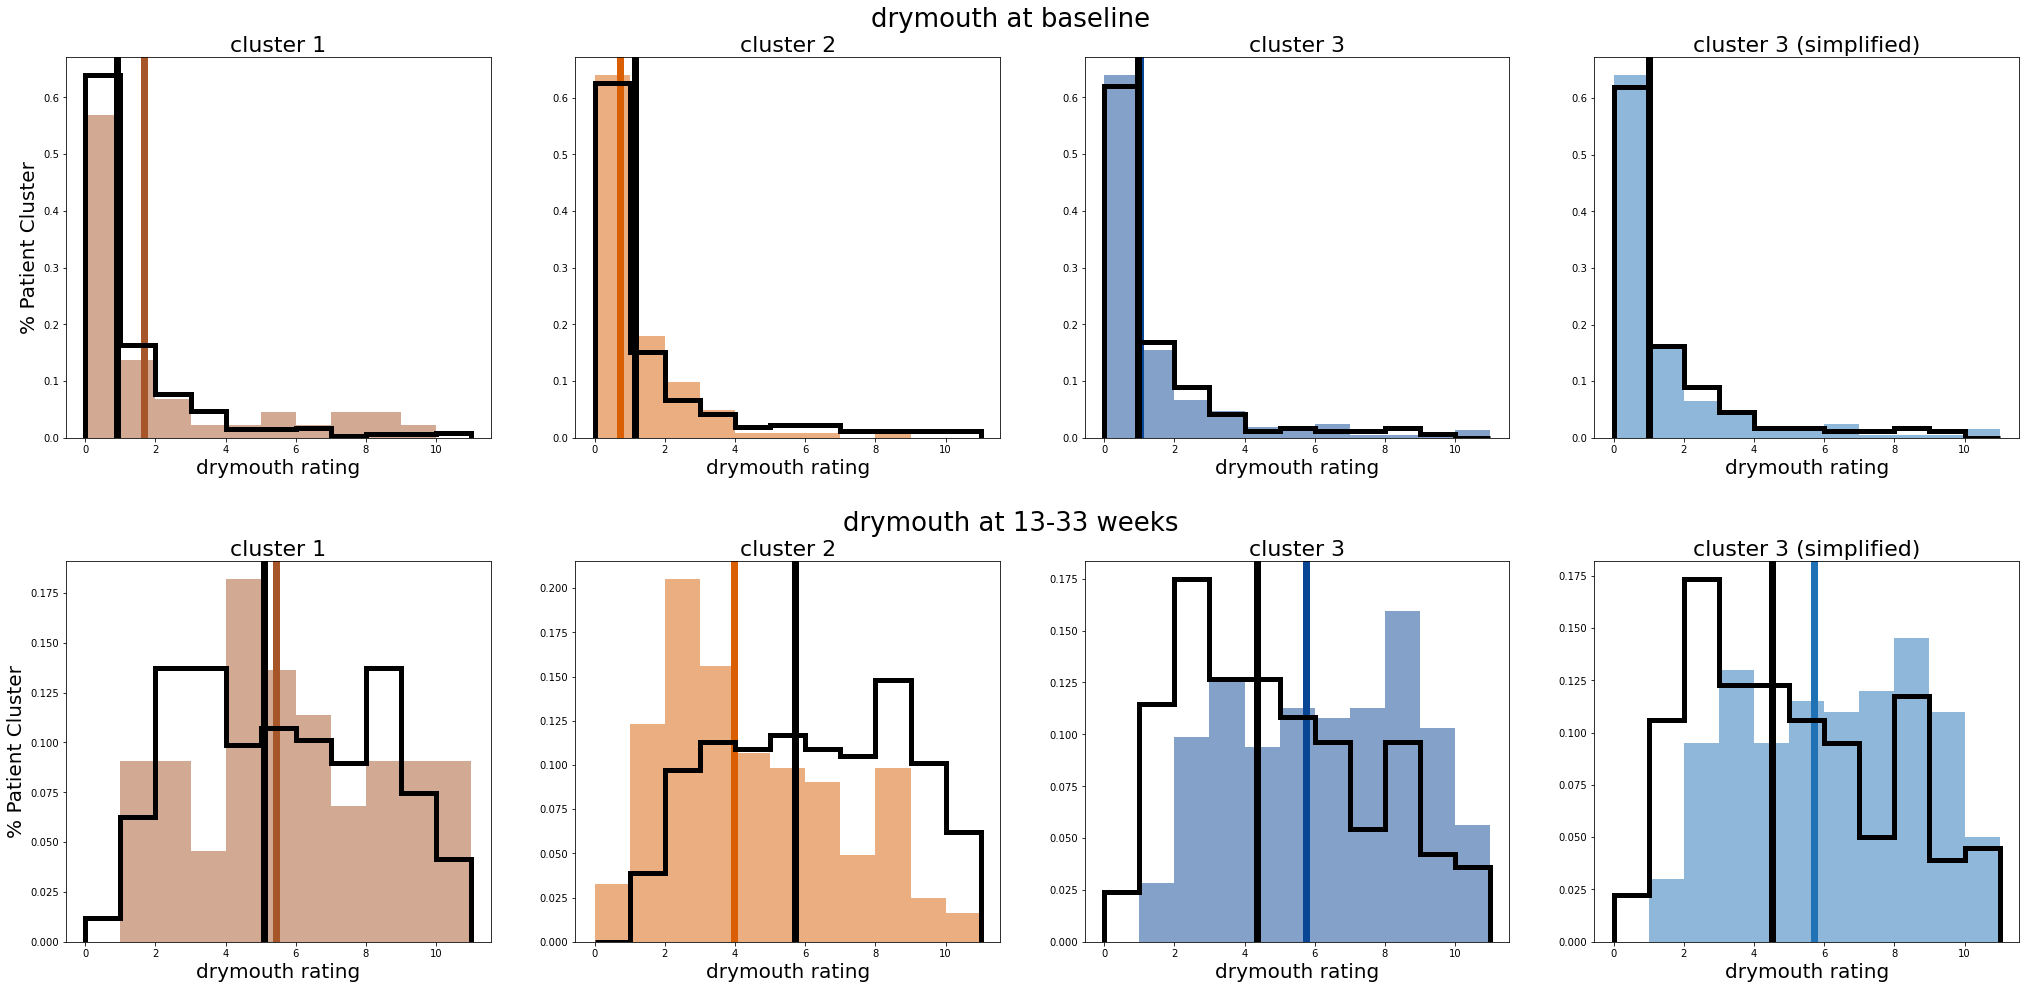

In [258]:
symptom_histogram_alt(ct2)

cluster 1 symptom at [0] [0.27884615384615385, 0.49038461538461536, 0.7307692307692307]
cluster 2 symptom at [0] [0.35714285714285715, 0.512987012987013, 0.6883116883116883]
cluster 3 symptom at [0] [0.5833333333333334, 0.85, 1.1833333333333333]
cluster 3 (simplified) symptom at [0] [0.4594594594594595, 0.6576576576576577, 0.9369369369369369]
cluster 1 symptom at [13, 33] [0.9326923076923077, 1.1730769230769231, 1.4519230769230769]
cluster 2 symptom at [13, 33] [1.0324675324675325, 1.2207792207792207, 1.422077922077922]
cluster 3 symptom at [13, 33] [1.95, 2.275, 2.658333333333333]
cluster 3 (simplified) symptom at [13, 33] [1.8198198198198199, 2.189189189189189, 2.6036036036036037]


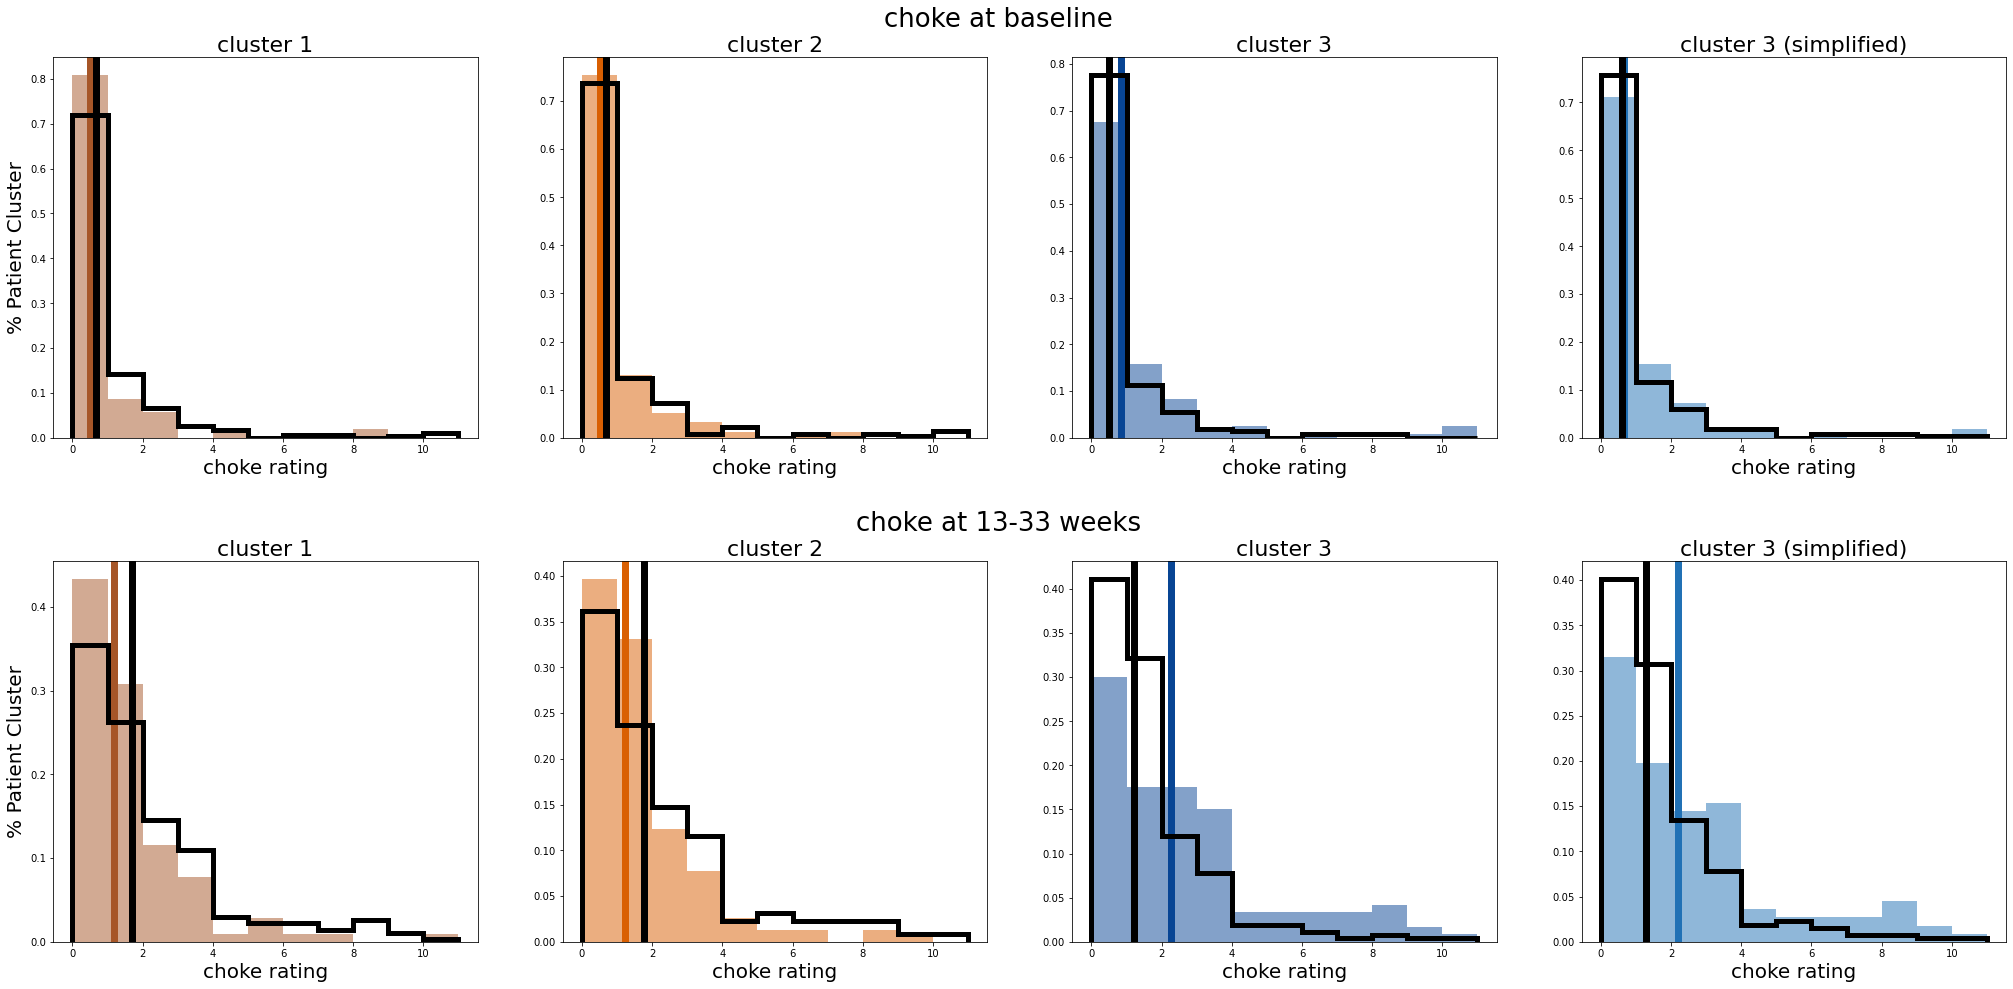

In [259]:
symptom_histogram_alt(choke_ct)

In [247]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

def test_cv_models(ct,key=None,confounders=None,models=None,include_mimic=True,include_delong=True):
    if models is None:
        models = [
            ComplementNB(),
            LogisticRegression(class_weight='balanced',random_state=0),
            LogisticRegression(penalty='l1',solver='saga',class_weight='balanced',random_state=0),
            LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0),
            RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=0),
            RandomForestClassifier(n_estimators=500,max_depth=3,random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=3,class_weight='balanced',random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=10,random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=10,class_weight='balanced',random_state = 0),
        ]
    thresholds = [3,5,7]
    results = []
    if confounders is None:
        confounders = ct.default_confounders[:]
    for model in models:
        for t in thresholds:
            res = ct.get_cv_auc(threshold=t,model=model,confounders=confounders)
            if include_delong:
                res['delong_pval'] = ct.delong_roc(threshold=t,model=model,confounders=confounders)
            if include_mimic:
                res2 = ct.get_cv_auc(threshold=t,model=model,confounders=confounders,use_mimic=True)
                for k,v in res2.items():
                    res[k+'_mimic'] = v
                if include_delong:
                    res['delong_pval_mimic'] = ct.delong_roc(threshold=t,model=model,confounders=confounders,use_mimic=True)
            if key is not None:
                res['key'] = key
            res['threshold'] = t
            res['model'] = str(model)
            res['base_roc'] = res['roc'] - res['roc_change']
            results.append(res)
    return results

def best_model_df(c, metric='base_roc',**kwargs):
    return pd.DataFrame(test_cv_models(c,**kwargs)).sort_values([metric,'threshold'],kind='mergesort',ascending=False).groupby(['threshold',metric,'model']).first()

# best_model_df(ct)

In [ ]:
def plot_best_models(results,basetitle='drymouth cv'):
    dfs = [pd.DataFrame(res) for res in results]
    #I assume these all have the same set of models
    n_models = len(dfs[0].model.unique())
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','grey','navy','#e6ab02']
    n_rows = len(dfs)
    fig,axes = plt.subplots(n_rows,n_models,figsize=(8*n_rows,6*n_models))
    ymin = 0
    ymax = 0
    def format_model(m):
        m = str(m).replace('Regression','').replace("Classifier",'')
        m = re.sub(r'[a-zA-z]+\=', '', m)
        return m
    for row, df in enumerate(dfs):
        col=0
        for model, subdf in df.groupby('model'):
            axis = axes[row,col]
            subdf.plot(kind='barh',x='threshold',y=['roc_change','roc_change_mimic','f1_change','f1_change_mimic'],ax=axis,color=colors)
            col+=1
            (min_y, max_y) = axis.get_xlim()
            ymin = min(min_y,ymin)
            ymax = max(max_y,ymax)
            axis.set_title(format_model(model) + ' | ' + basetitle)
    [[ax.set_xlim((ymin,ymax)) for ax in row] for row in axes]
            
# models=[
#     LogisticRegression(class_weight='balanced',random_state=0),
#     RandomForestClassifier(n_estimators = 500, max_depth=5,class_weight='balanced',random_state=0),
#     LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0),
# ]

# test = test_cv_models(ct,
#                       models=models,
#                      )
# test2 = test_cv_models(ClusterTester(sddf,ct.cluster_organs,n_clusters=2,cluster_features=ct.cluster_features),
#                       models=models,
#                      )
# plot_best_models([test,test2])

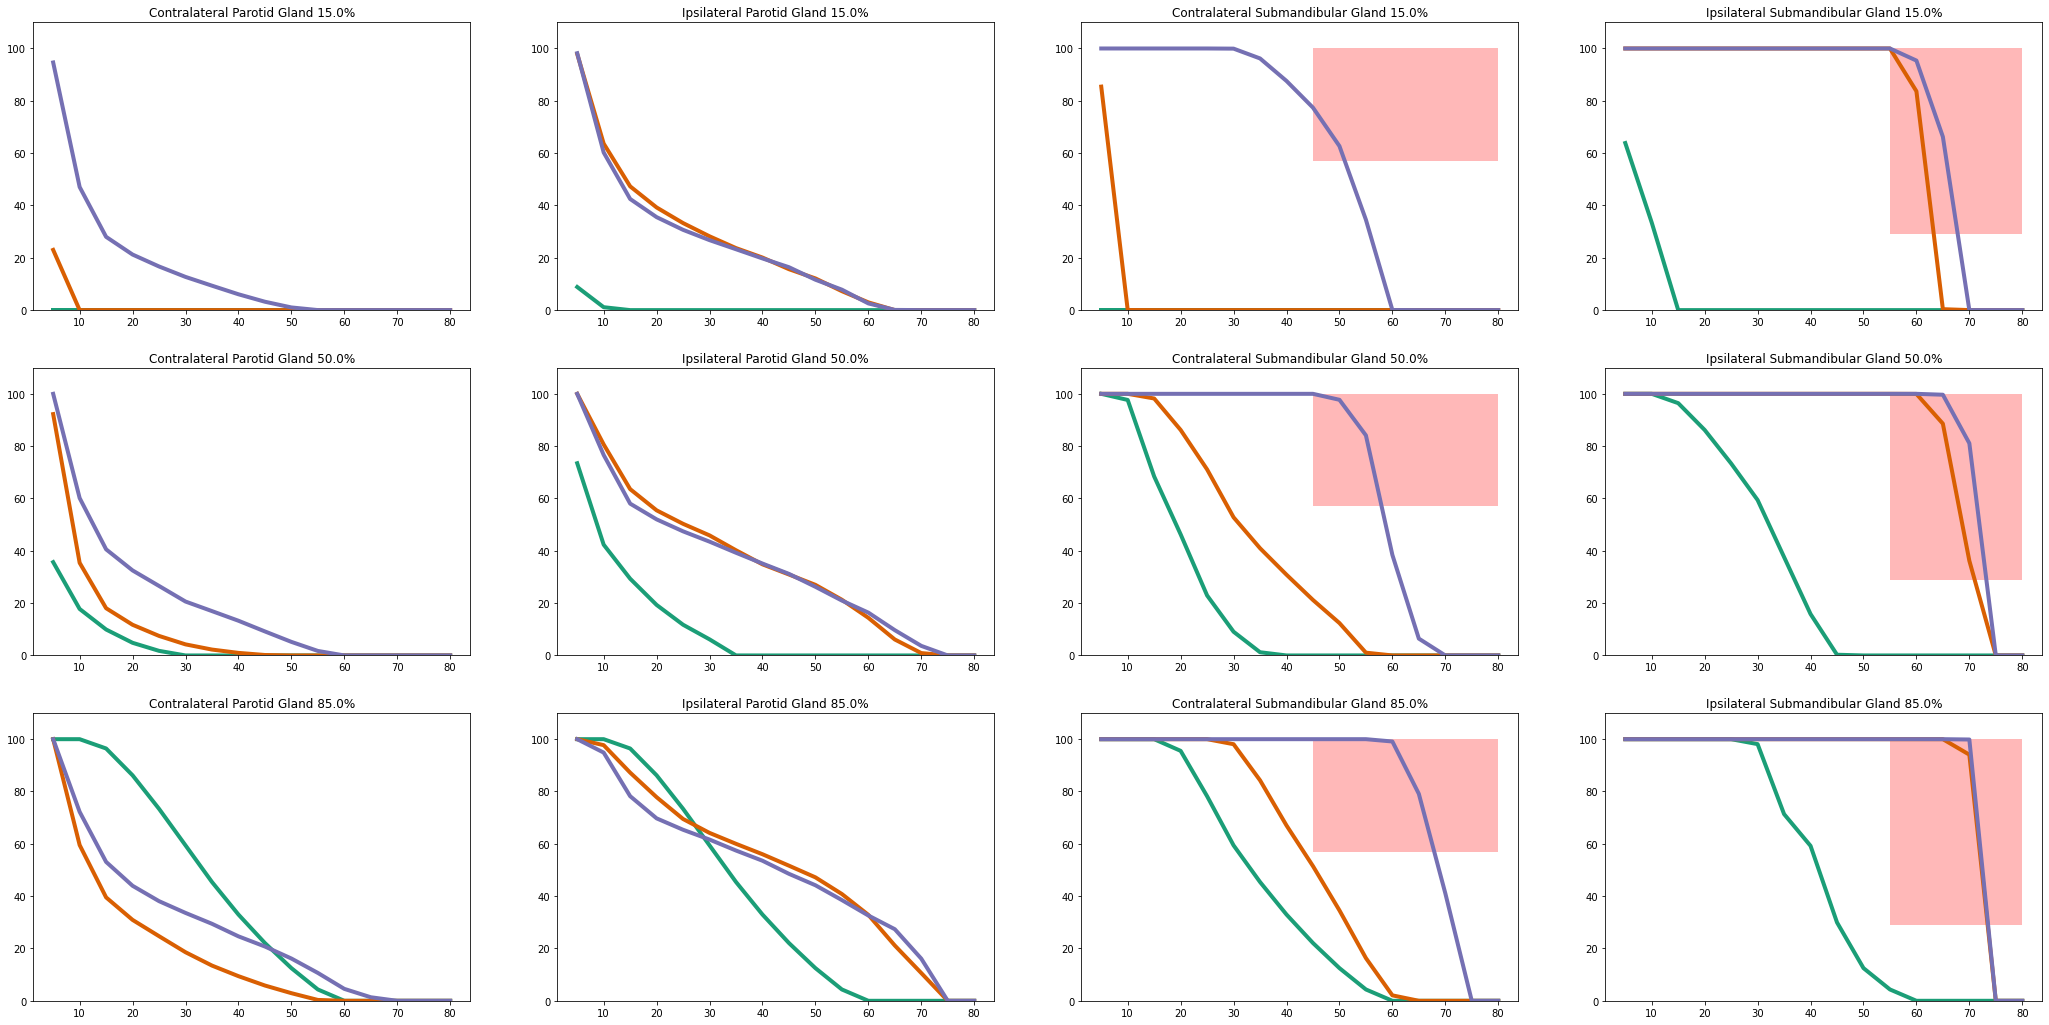

In [37]:
def get_cluster_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    cluster_vals = {}
    for cluster, subdf in df.groupby('dose_clusters'):
        vals = []
        for feature in features:
            farray = np.stack(subdf[feature].apply(filter_organs).values)
            vals.append(farray.T)
        vals = np.stack(vals,axis=-1) #organs x patients x features
        vals = np.swapaxes(vals,1,-1) #organs x features x patients
        cluster_vals[cluster] = vals
    return cluster_vals

def get_rule_points(ct):
    rule = list(ct.current_rules.values())[0][0]
    features = rule['features']
    thresholds = rule['thresholds']
    get_val = lambda x: re.match('V(\d+)_([a-zA-Z_]+)',x).groups()
    fzip = [get_val(f) for f in features]
    odict = {}
    for i,(num, organ) in enumerate(fzip):
        num = int(num)
        thold = thresholds[i]
        odict[organ] = {'value': num,'threshold': thold}
    return odict

def plot_cluster_dvhs(ctester,quantiles=[.15,.5,.85],features=None,organs=None,include_mimic=False,size=6,**kwargs):
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    (n_rows, n_cols) = (len(quantiles),len(organs))
    fig,axes = plt.subplots(n_rows,n_cols,figsize=(1.5*size*n_cols,size*n_rows))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','grey','navy','#e6ab02']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    for clustkey, carray in data.items():
        for col, organ in enumerate(organs):
            rule = rules.get(organ)
            qtiles = np.nanquantile(carray[col],quantiles,axis=-1)
            for row,quant in enumerate(qtiles):
                axis = axes[row,col]
                axis.plot(xlabels,quant,linewidth=4,color=colors[clustkey])
                axis.set_ylim((0,ylim*1.1))
                axis.set_title(format_title(organ) + ' ' + str(100*quantiles[row]) + '%')
                if rule is not None:
                    corner = [rule['value'],rule['threshold']]
                    rheight = ylim - corner[1]
                    rwidth = xlabels[-1] - corner[0]
                    rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='red')
                    axis.add_patch(rect)
    return
    
def get_all_dvh(ct, key='V'):
    return sorted([col for col in ct.df if re.match(key+'\d+',col) is not None], key = lambda x: int(x[1:]) )

from matplotlib.patches import Rectangle
plot_cluster_dvhs(ct)

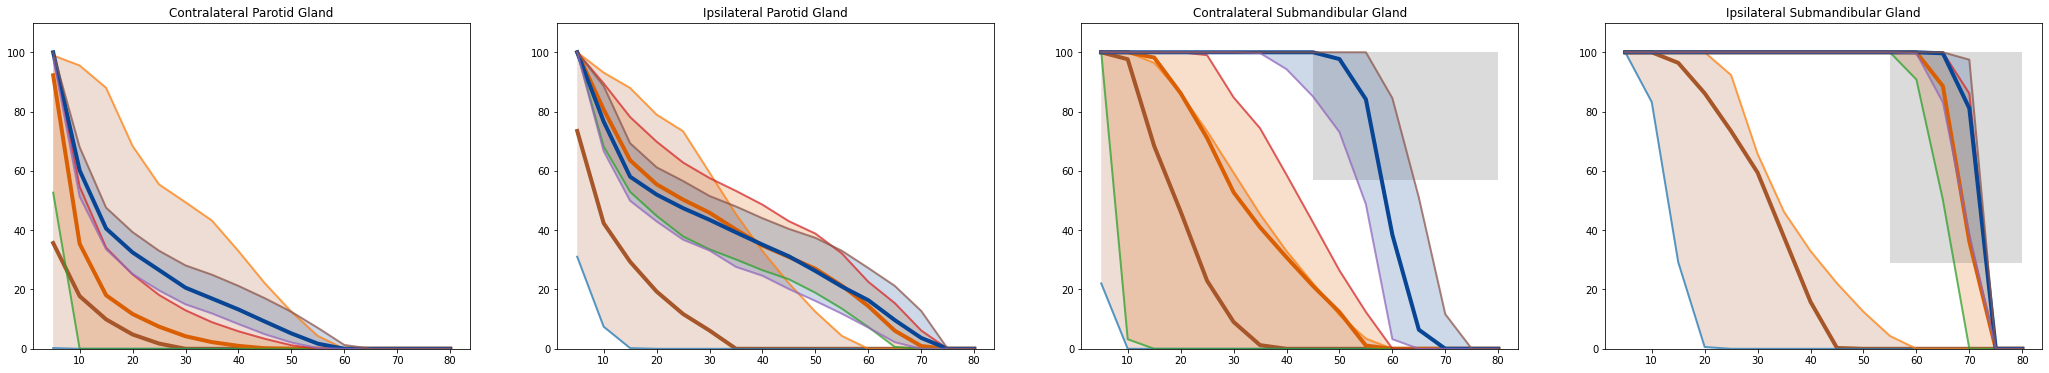

In [38]:
def plot_cluster_dvhs_alt(ctester,quantile_levels=[[.25,.75]],features=None,organs=None,include_mimic=False,size=6,**kwargs):
    #variant where it's all one column
    #assume quantiles is 3 values (lower bound, mean, upper bound)
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    n_cols = len(organs)
    fig,axes = plt.subplots(1,n_cols,figsize=(1.5*size*n_cols,size))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    for clustkey, carray in data.items():
        color = colors[clustkey]
        for col, organ in enumerate(organs):
            axis=axes[col]
            rule = rules.get(organ)
            avg = np.nanmedian(carray[col],axis=-1)
            axis.plot(xlabels,avg,linewidth=4,color=color)
            for quantiles in quantile_levels:
                qtiles = np.nanquantile(carray[col],quantiles,axis=-1)
                axis.fill_between(xlabels,qtiles[0],qtiles[-1],facecolor=color,alpha=.2)
                for q in qtiles:
                    axis.plot(xlabels,q,linewidth=2,alpha=.75)
                
            axis.set_ylim((0,ylim*1.1))
            axis.set_title(format_title(organ))
            if rule is not None:
                corner = [rule['value'],rule['threshold']]
                rheight = ylim - corner[1]
                rwidth = xlabels[-1] - corner[0]
                rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='grey')
                axis.add_patch(rect)
    return
    
def get_all_dvh(ct, key='V'):
    return sorted([col for col in ct.df if re.match(key+'\d+',col) is not None], key = lambda x: int(x[1:]) )

from matplotlib.patches import Rectangle
plot_cluster_dvhs_alt(ct)

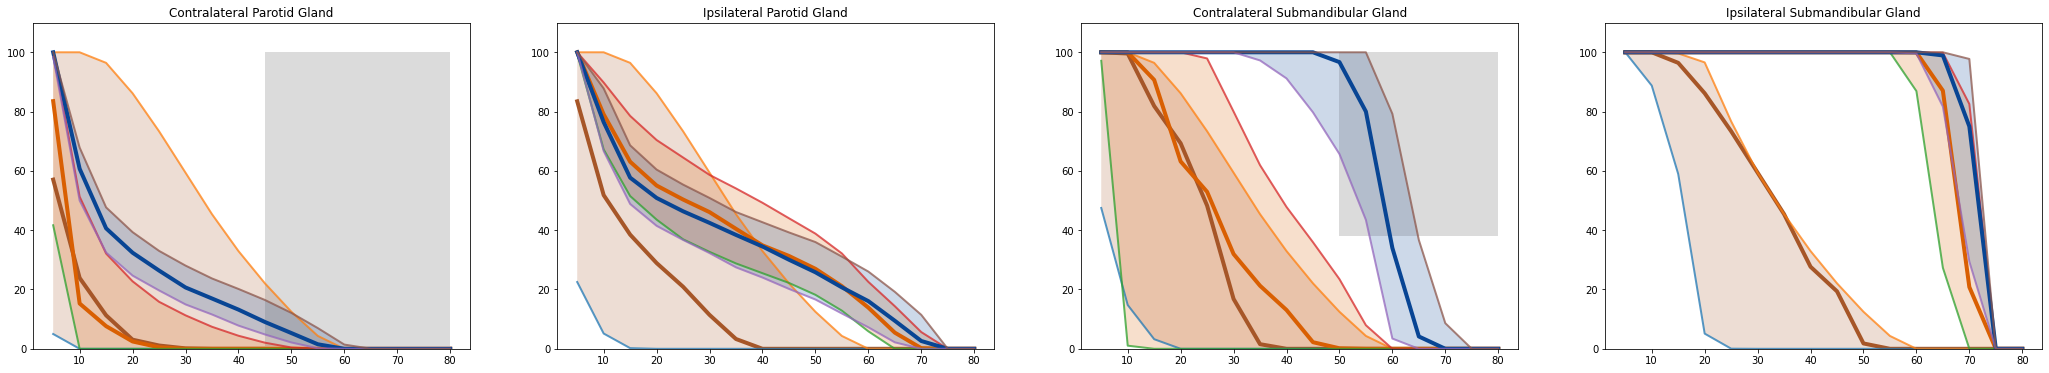

In [260]:
plot_cluster_dvhs_alt(ct2)

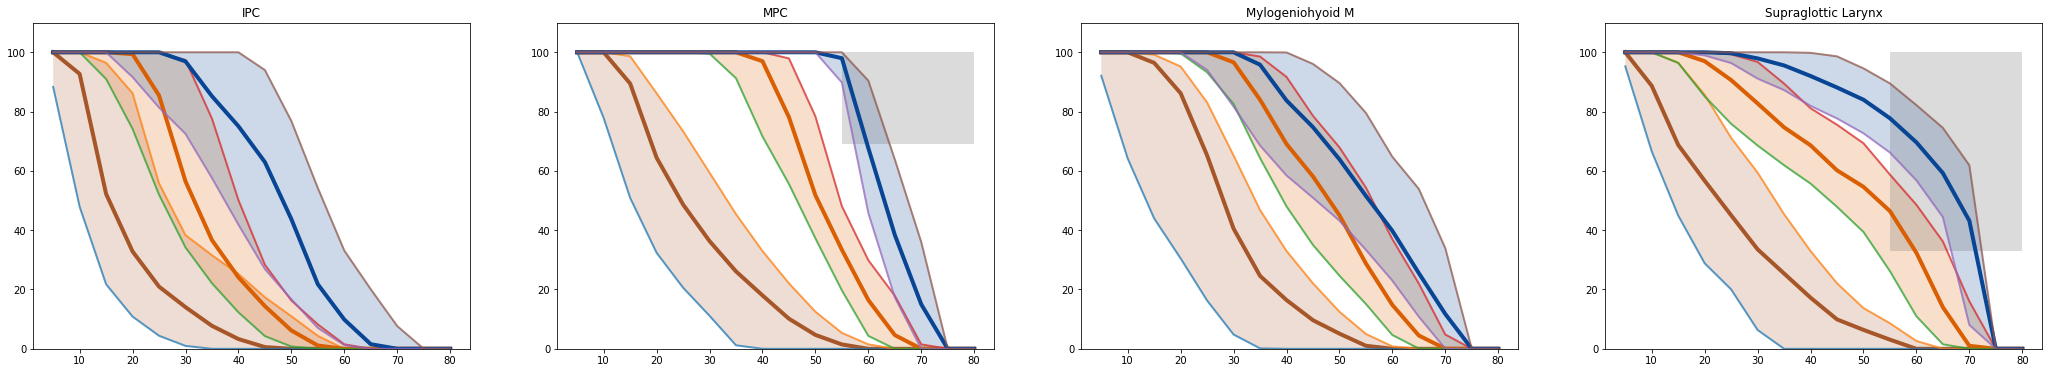

In [40]:
plot_cluster_dvhs_alt(choke_ct)

(78,)
(78,)
(78,)
(78,)
(78,)
(78,)


(<Figure size 2160x2160 with 36 Axes>,
 array([<matplotlib.figure.SubFigure object at 0x7f5568eee450>,
       dtype=object))

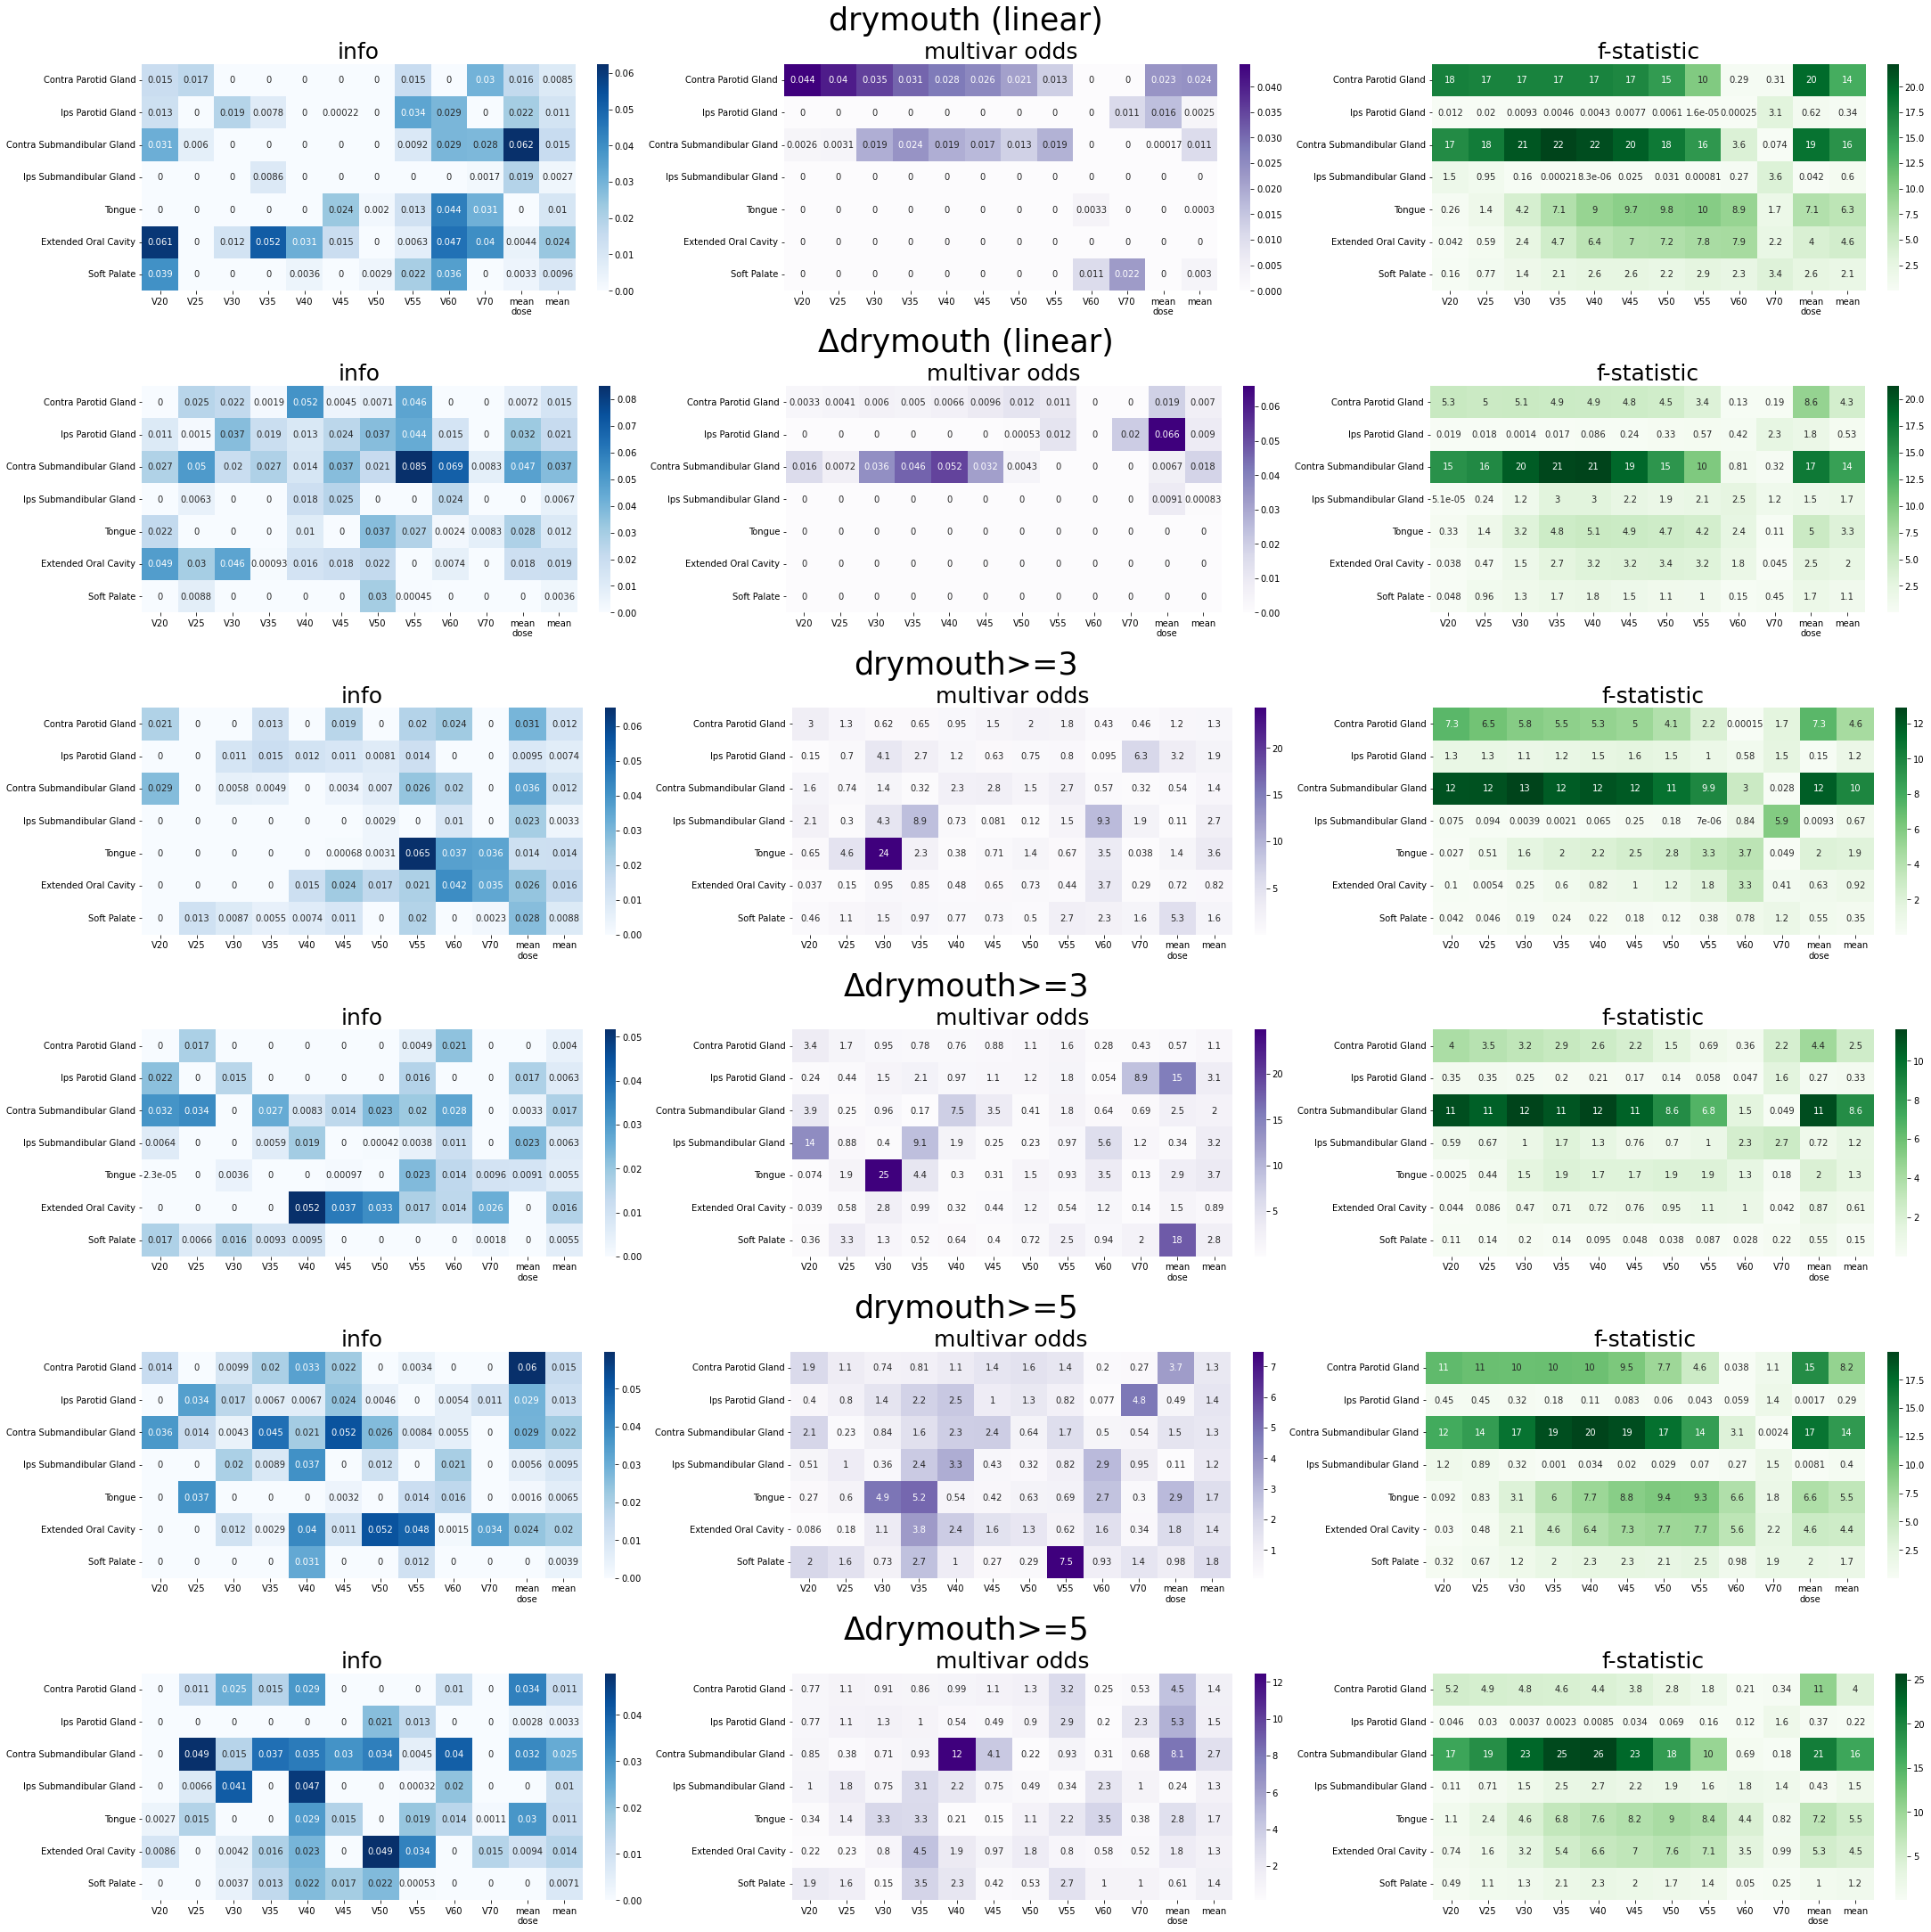

In [41]:
def get_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    vals = []
    for feature in features:
        farray = np.stack(df[feature].apply(filter_organs).values)
        vals.append(farray.T)
    vals = np.stack(vals,axis=-1) #organs x patients x features
    vals = np.swapaxes(vals,1,-1) #organs x features x patients
    return vals

def fix_oname(name):
    return name.replace('Lt_','Ips_').replace('Rt_','Contra_').replace('_',' ')

def multivar_odds(x,y,
                  regularize = True,
                  scale=True,
                  max_odds = 100,
                  alpha=None,
                   ):
    #this version uses sklearn because it doesn't work without it's good regularization
    if y.max() > 1:
        y = y/y.max()
        
    valid = [(x[:,i].std() > .001) for i in range(x.shape[1])]
    good_indices = [i for i,v in enumerate(valid) if v]
    good_x = np.stack([x[:,idx] for idx in good_indices],axis=1).astype(float)
    if regularize:
        good_x = (good_x - good_x.mean(axis=0))/(np.nanstd(good_x,axis=0))
    if scale:
        good_x = (good_x - good_x.min(axis=0))/(good_x.max(axis=0) - good_x.min(axis=0))
    good_x = np.nan_to_num(good_x,0)
    boolean = (len(np.unique(y)) <= 2)
    if boolean:
        if alpha is None:
            alpha = .1
        model = LogisticRegression(penalty='l2',C=1/alpha)
    else:
        if alpha is None:
            alpha = .0000001
        model = Ridge(alpha=alpha,positive=True)
    odds_vals = []
    
    m = model.fit(x,y)
    good_odds = m.coef_.ravel()
    print(good_odds.shape)
    if boolean:
        good_odds = np.exp(good_odds)
    odds = []
    pos = 0
    for is_valid in valid:
        if is_valid: 
            o = good_odds[pos]
            pos += 1
        else:
            o = 0
        if max_odds is not None:
            o = np.min([max_odds,o])
            if not boolean:
                o = np.max([-max_odds,o])
        odds.append(o)
    return np.array(odds)

def test_dvh_info(ctester,threshold=-1,metric='info',confounders=None,use_change=False,features=None,organs=None):
    if features is None:
        features= get_all_dvh(ctester)
    if confounders is None:
        confounders = ctester.default_confounders[:]
    confounder_df = ctester.df[confounders]
#     organs =  Const.organ_list[:] 
    if organs is None:
        organs = ctester.cluster_organs[:]
    darray = get_dvhs(ctester,features=features,organs=organs) #
    darray = np.swapaxes(darray,-1,0) #patients x features x organs
    darray = darray.reshape((darray.shape[0],-1)) #patients x features - organs
    darray = (darray - darray.mean(axis=1).reshape(-1,1))/(.0001 + darray.std(axis=1).reshape(-1,1))
    darray = (darray - darray.min(axis=1).reshape(-1,1))/(darray.max(axis=1).reshape(-1,1) - darray.min(axis=1).reshape(-1,1))
    darray = np.nan_to_num(darray)
    outcome = ctester.get_outcome(threshold=threshold,use_change=use_change)
    if confounders is not None and len(confounders) > 0:
        merged = np.concatenate([darray,confounder_df.values],axis=-1)
    else:
        merged = darray
    if 'odds' in metric and 'multi' in metric:
        info = multivar_odds(merged,outcome)
    else:
        if threshold > 0:
            if metric == 'info':
                info = mutual_info_classif(merged,outcome,n_neighbors=6,random_state=0)
            elif metric == 'pvalue':
                info = 1 - f_classif(merged,outcome)[1]
            else:
                info = f_classif(merged,outcome)[0]
        else:
            if metric=='info':
                info = mutual_info_regression(merged,outcome,n_neighbors=6,random_state=0)
            elif metric== 'pvalue':
                info = 1 - f_regression(merged,outcome)[1]
            else:
                info = f_regression(merged,outcome)[0]
    info = np.nan_to_num(info,1)
    res = {}
    pos = 0
    for f in features:
        values = []
        entry = {}
        for o in organs:
            curr_info = info[pos]
            values.append(curr_info)
            entry[fix_oname(o)] = curr_info
            pos += 1
        res[f] = entry
    df = pd.DataFrame(res)
    df['max'] = df.apply(lambda x: np.mean(x),axis=1)
    df = df.sort_values('max',ascending=False)
#     df[ = df.apply(lambda x: np.max(x),axis=1)
    return df.drop('max',axis=1)

def plot_dvh_correlations(ct,
                          metrics=None,
                          features = None,
                          thresholds=[-1],
                          organs = None,
                          **kwargs):
    if metrics is None:
        metrics = ['info','f-statistic']
    fig = plt.figure(constrained_layout=True,figsize=(10*len(metrics),len(thresholds)*5))
    axes = fig.subfigures(len(thresholds),1)
    if organs is None:
        organs = sorted(ct.cluster_organs[:])
    order = [fix_oname(o) for o in organs]
    color_dict = {
        'info': 'Blues',
        'f-statistic': "Greens",
        'multivar_odds': 'Purples'
    }
    for row, threshold in enumerate(thresholds):
        use_change = False
        thold = np.abs(threshold)
        if threshold < 0:
            use_change = True
        if thold == 1:
            thold = 0
                
        subfig = axes[row]
        title = ct.symptoms[0] 
        if use_change:
            title = 'Δ' + title
        if thold > 1:
            title += '>=' +str(thold)
        else:
            title += ' (linear)'
        subfig.suptitle(title,fontsize=35)
        subplots = subfig.subplots(1,len(metrics))
        for col, metric in enumerate(metrics):
            
            ax = subplots[col]
            temp = test_dvh_info(ct,
                                 metric=metric,
                                 use_change=use_change,
                                 threshold=thold,
                                 features=features,
                                 organs=organs,
                                 **kwargs)
            temp['mean'] = temp.values.mean(axis=1)
            d = temp.loc[order]
            d.columns = [c.replace('_','\n') for c in d.columns]
            sns.heatmap(d,ax=ax,cmap=color_dict.get(metric,'Reds'),annot=True)  
            
            title =  metric.replace('_',' ')
            ax.set_title(title,fontdict={'fontsize': 25})
    return fig,axes

plot_dvh_correlations(ct,
                      metrics=['info','multivar_odds','f-statistic'],
                      features = ['V20','V25','V30','V35','V40','V45','V50','V55','V60','V70','mean_dose'],
                      thresholds = [0,-1,3,-3,5,-5],
                      confounders=['hpv'],
                      organs = ct.cluster_organs + ['Tongue','Extended_Oral_Cavity','Soft_Palate'],
                     )

(78,)
(78,)
(78,)
(78,)
(78,)
(78,)


(<Figure size 2160x2160 with 36 Axes>,
 array([<matplotlib.figure.SubFigure object at 0x7f553b88d5d0>,
       dtype=object))

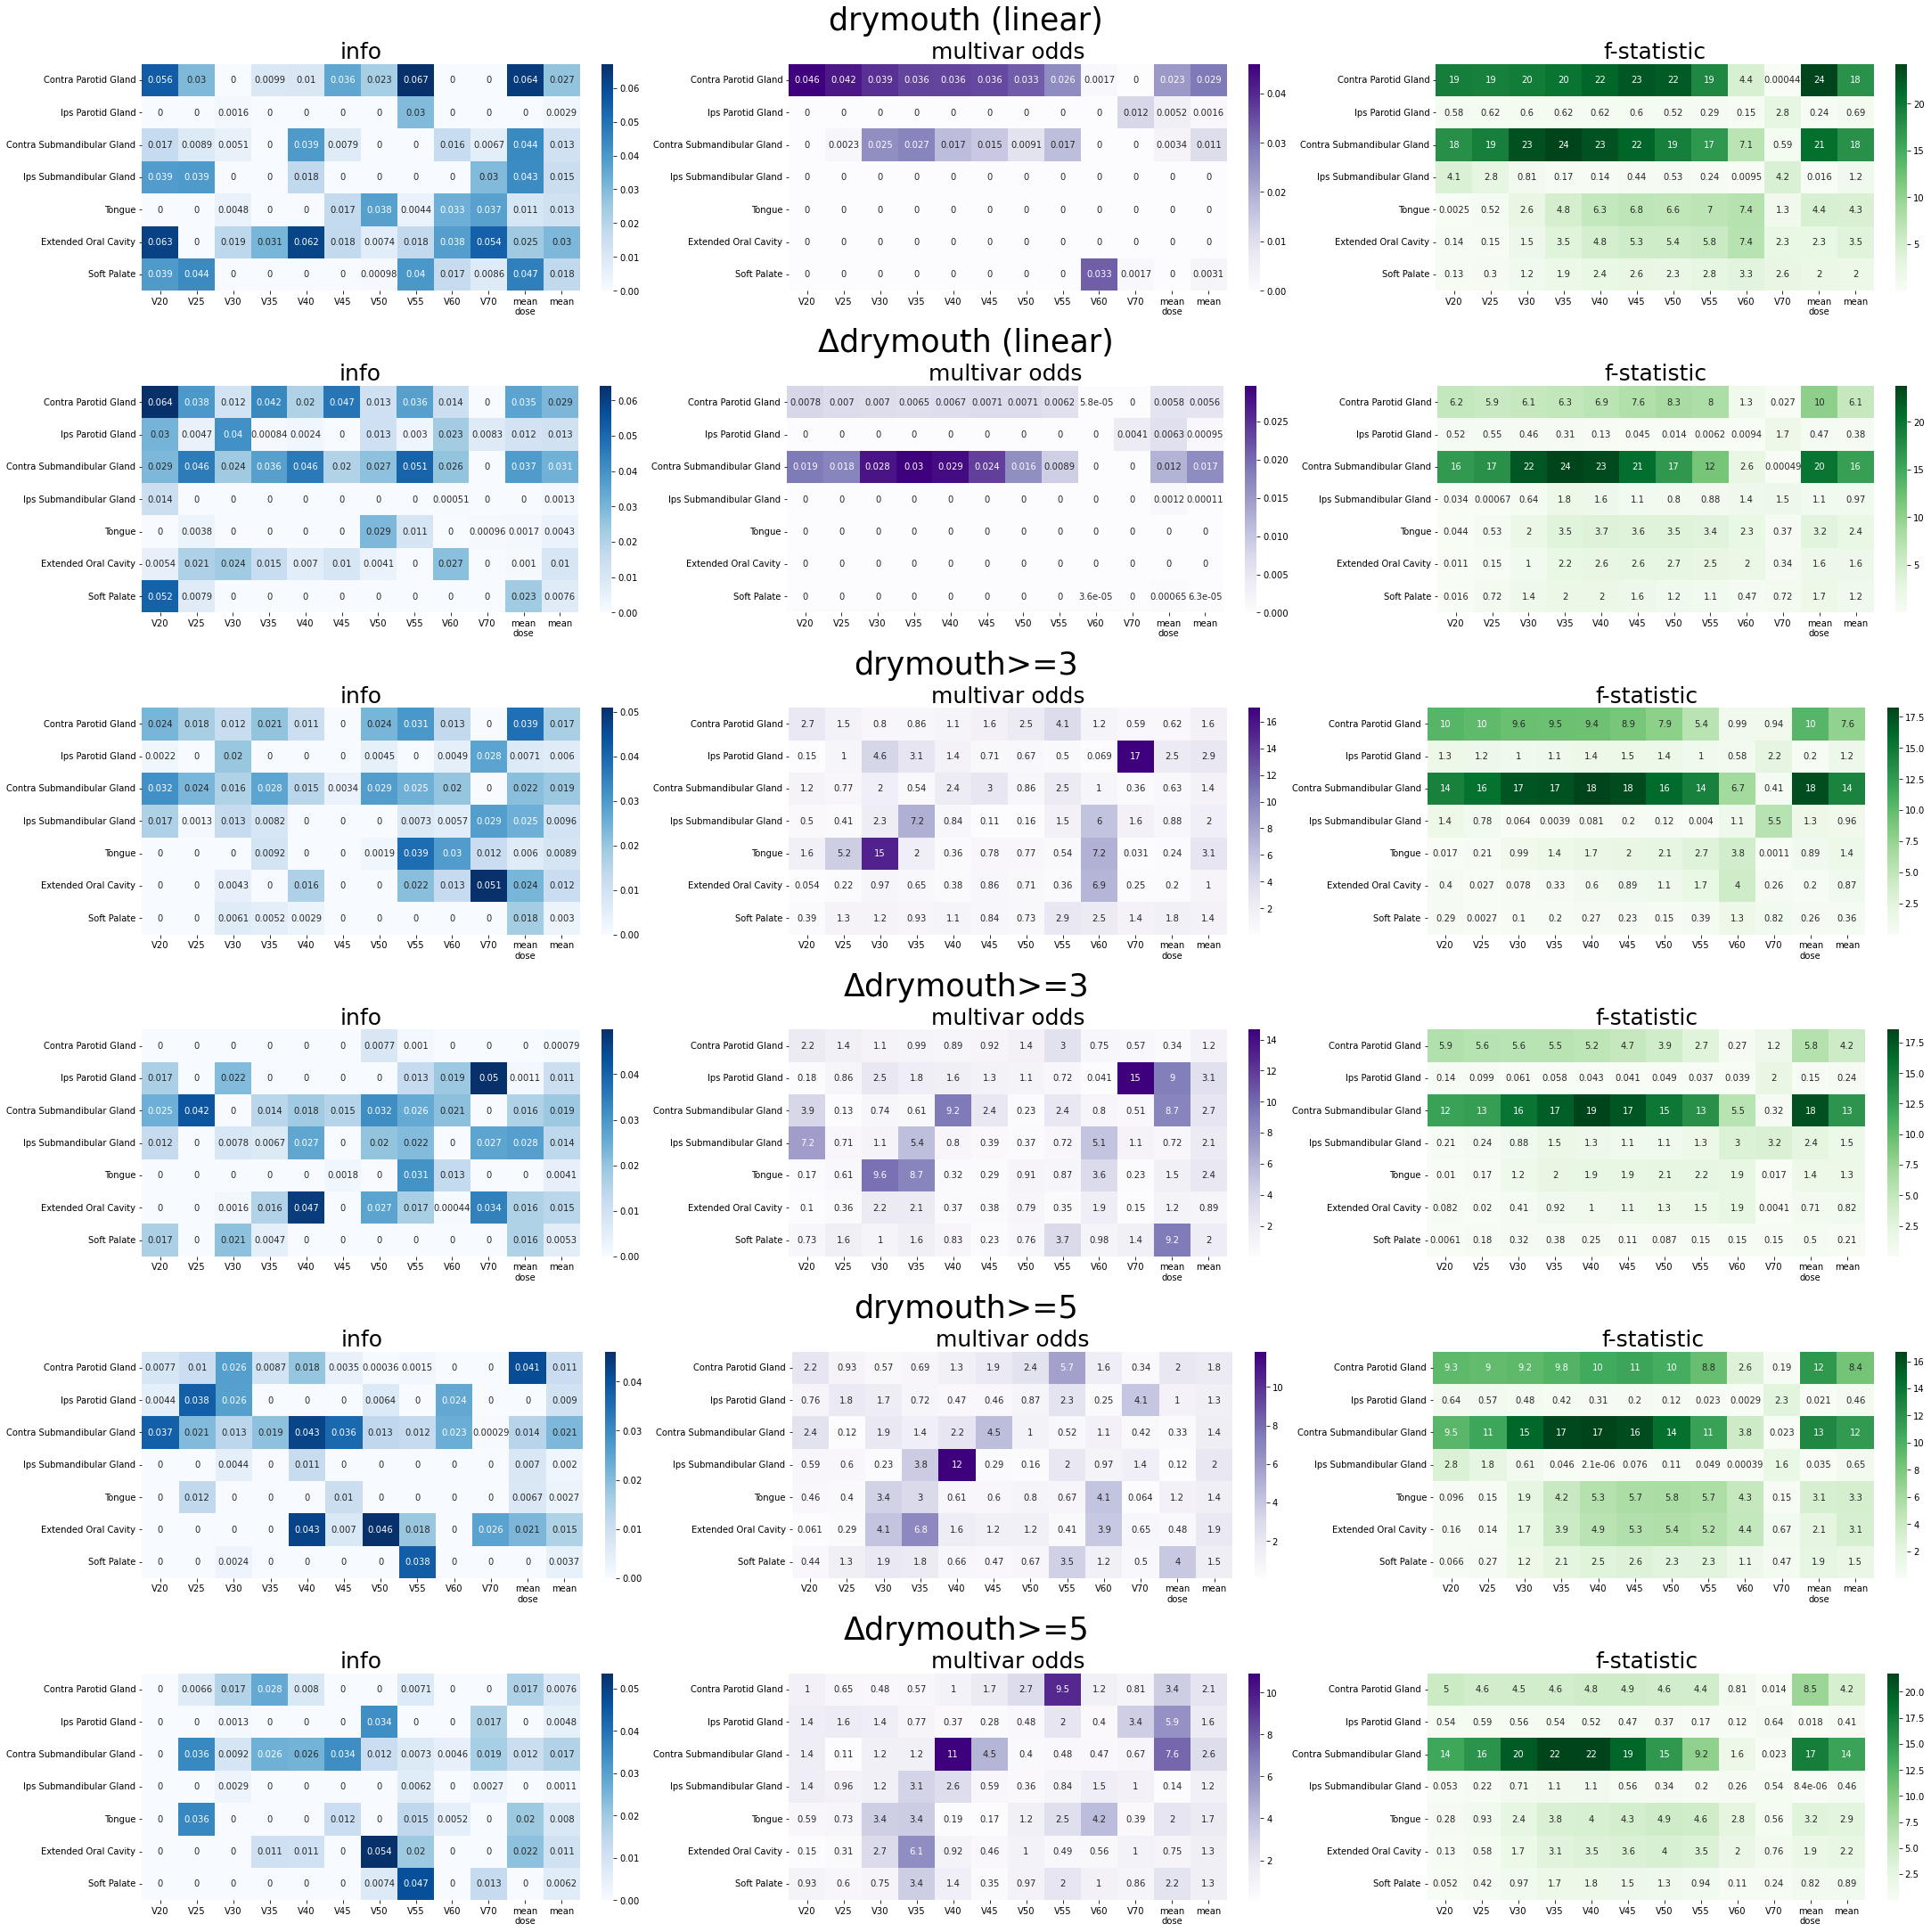

In [261]:
plot_dvh_correlations(ct2,
                      metrics=['info','multivar_odds','f-statistic'],
                      features = ['V20','V25','V30','V35','V40','V45','V50','V55','V60','V70','mean_dose'],
                      thresholds = [0,-1,3,-3,5,-5],
                      confounders=['hpv'],
                      organs = ct2.cluster_organs + ['Tongue','Extended_Oral_Cavity','Soft_Palate']
                     )

In [ ]:
def get_rule_points(ct):
    rule = list(ct.current_rules.values())[0][0]
    features = rule['features']
    thresholds = rule['thresholds']
    get_val = lambda x: re.match('V(\d+)_([a-zA-Z_]+)',x).groups()
    fzip = [get_val(f) for f in features]
    odict = {}
    for i,(num, organ) in enumerate(fzip):
        num = int(num)
        thold = thresholds[i]
        odict[organ] = {'value': num,'threshold': thold}
    return odict
get_rule_points(ct)

_____ 11.11 %_______
{'organs': ['Rt_Parotid_Gland', 'Lt_Parotid_Gland', 'Rt_Submandibular_Gland', 'Lt_Submandibular_Gland'], 'symptoms': ['drymouth'], 'features': ['V35', 'V40', 'V45', 'V50', 'V55', 'V60'], 'n_clusters': 2, 'confounders': None, 'model': LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   random_state=0, solver='saga'), 'threshold': 3}
base roc 0.5878481012658229 mimic roc 0.5666877637130802
base roc_change 0.06371308016877641 mimic roc_change 0.0425527426160337
base mcc 0.19431663757260828 mimic mcc 0.11186049549549165
base mcc_change 0.16962518228608714 mimic mcc_change 0.0871690402089705
base f1 0.7655677655677655 mimic f1 0.6836935166994106
base f1_change 0.12285319470948208 mimic f1_change 0.04097894584112716
0roc 0.5878059071729957
0roc_change 0.06367088607594928
0mcc 0.19431663757260828
0mcc_change 0.16962518228608714
0f1 0.7655677655677655
0f1_change 0.12285319470948208
1roc 0.5878481012658229
1roc_change 0.0637130

_____ 88.89 %_______
{'organs': ['Rt_Parotid_Gland', 'Lt_Parotid_Gland', 'Rt_Submandibular_Gland', 'Lt_Submandibular_Gland'], 'symptoms': ['drymouth'], 'features': ['V35', 'V40', 'V45', 'V50', 'V55', 'V60'], 'n_clusters': 4, 'confounders': None, 'model': LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   random_state=0, solver='saga'), 'threshold': 5}
base roc 0.571372150756037 mimic roc 0.5800891446626044
base roc_change 0.0308056872037914 mimic roc_change 0.03952268111035884
base mcc 0.18129863124893436 mimic mcc 0.1547527261512197
base mcc_change 0.08419973915627957 mimic mcc_change 0.05765383405856492
base f1 0.6636971046770602 mimic f1 0.5924050632911393
base f1_change 0.06512228282432853 mimic f1_change -0.006169758561592409
0roc 0.5329778830963665
0roc_change -0.007588580455879068
0mcc 0.09820336200876148
0mcc_change 0.0011044699161066873
0f1 0.5966587112171838
0f1_change -0.001916110635547863
1roc 0.5686075378018506
1roc_change 0.

organs  symptoms  \
0  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
1  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
2  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
3  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
4  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
5  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
6  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
7  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   
8  Rt_Parotid_Gland,Lt_Parotid_Gland,Rt_Submandib...  drymouth   

                  features  n_clusters confounders  \
0  V35,V40,V45,V50,V55,V60           2        None   
1  V35,V40,V45,V50,V55,V60           2        None   
2  V35,V40,V45,V50,V55,V60           2        None   
3  V35,V40,V45,V50,V55,V60           3        None   
4  V35,V40,V45,V50,V55,V60           3        None   
5  V35,V40,V45,V50,V55,V60           3        None   
6  V35,V40,V45,V50,V55,V60           4        None   
7  V35,V40,V45,V50,V55,V60           4        None   
8  V35,V40,V45,V50,V55,V60           4        None   

                                               model  threshold  roc_base  \
0  LogisticRegression(class_weight='balanced', l1...          3  0.587848   
1  LogisticRegression(class_weight='balanced', l1...          5  0.561597   
2  LogisticRegression(class_weight='balanced', l1...          7  0.566728   
3  LogisticRegression(class_weight='balanced', l1...          3  0.632447   
4  LogisticRegression(class_weight='balanced', l1...          5  0.598510   
5  LogisticRegression(class_weight='balanced', l1...          7  0.582422   
6  LogisticRegression(class_weight='balanced', l1...          3  0.603333   
7  LogisticRegression(class_weight='balanced', l1...          5  0.571372   
8  LogisticRegression(class_weight='balanced', l1...          7  0.571331   

   roc_mimic  roc_change_base  ...  precision_3  precision_change_3  recall_3  \
0   0.566688         0.063713  ...          NaN                 NaN       NaN   
1   0.579102         0.021031  ...          NaN                 NaN       NaN   
2   0.565694         0.043188  ...          NaN                 NaN       NaN   
3   0.594177         0.108312  ...          NaN                 NaN       NaN   
4   0.579962         0.057944  ...          NaN                 NaN       NaN   
5   0.582422         0.058882  ...          NaN                 NaN       NaN   
6   0.574135         0.079198  ...     0.813725            0.012730  0.553333   
7   0.580089         0.030806  ...     0.637838            0.037838  0.559242   
8   0.543265         0.047791  ...     0.382166            0.010185  0.461538   

   recall_change_3      f1_3  f1_change_3  f_half_3  f_half_change_3  \
0              NaN       NaN          NaN       NaN              NaN   
1              NaN       NaN          NaN       NaN              NaN   
2              NaN       NaN          NaN       NaN              NaN   
3              NaN       NaN          NaN       NaN              NaN   
4              NaN       NaN          NaN       NaN              NaN   
5              NaN       NaN          NaN       NaN              NaN   
6         0.016667  0.658730     0.016016  0.743728         0.014561   
7        -0.037915  0.595960    -0.002615  0.620400         0.020970   
8        -0.130769  0.418118    -0.038855  0.395778        -0.006101   

       f2_3  f2_change_3  
0       NaN          NaN  
1       NaN          NaN  
2       NaN          NaN  
3       NaN          NaN  
4       NaN          NaN  
5       NaN          NaN  
6  0.591168     0.016579  
7  0.573372    -0.024351  
8  0.443131    -0.086442  

[9 rows x 115 columns]

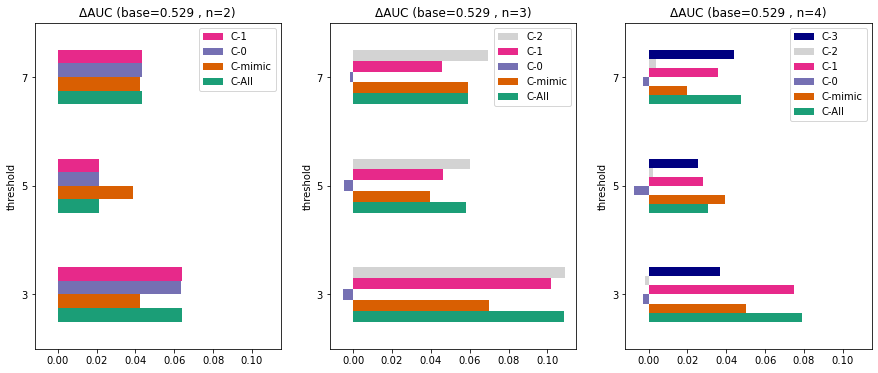

In [262]:
def get_mimic_cv_results(df):
    organ_lists = [
#         [
#             'Genioglossus_M',
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
                [
#             'Tongue',
            'Rt_Parotid_Gland','Lt_Parotid_Gland',
            'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
        ],
#         [
#             'Mylogeniohyoid_M',
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
#         [
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
    ]
    confounder_lists = [
        None,
#         ['t4','t3','n_severe','hpv'],
#         ['t4','t3','n_severe','hpv','Parotid_Gland_limit'],
#         ['t4','t3','n2','n3','hpv','BOT','Tonsil','Parotid_Gland_limit'],
#         ['t4','t3','n_severe','hpv','BOT','Tonsil','Parotid_Gland_limit','Esophagus_limit'],
    ]
    symptom_lists = [
        ['drymouth'],
#         ['swallow'],
#         ['taste'],
#         ['teeth'],
#         ['choke'],
#         ['sob'],
#         ['voice'],
#         ['nausea','vomit'],
#         ['drymouth','swallow'],
#         ['mucus','mucositis'],
    ]

    feature_lists = [
#         ['V40','V45','V50','V55','V60'],
#         ['V40','V45','V50','V55','V60','V65'],
        ['V35','V40','V45','V50','V55','V60'],
#         ['V40','V50','V60'],
    ]
    
    thresholds = [3,5,7]
    cluster_sizes = [
        2,
        3,
        4,
    ]
    
    models = [
#         LogisticRegression(class_weight='balanced',random_state=0),
        LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#         RandomForestClassifier(max_depth=3,class_weight='balanced'),
    ]
    n_runs = np.prod([len(l) for l in [organ_lists,confounder_lists,symptom_lists,feature_lists,thresholds,cluster_sizes,models]])
    i = 1
    result_list = []
    for organs in organ_lists:
        for symptoms in symptom_lists:
            for features in feature_lists:
                for n in cluster_sizes:
                    ct = ClusterTester(df,
                                       organs,
                                       n_clusters=n,
                                       cluster_features = features,
                                       symptoms=symptoms,
                                      )
                    #pre-compute mimic model results
                    ct.get_cluster_df(use_mimic=True)
                    for confounders in confounder_lists:
                        for model in models:
                            for threshold in thresholds:
                                base_results = ct.get_cv_auc(threshold=threshold,
                                                             model=model,
                                                             use_mimic = False,
                                                             confounders=confounders)
                                mimic_results = ct.get_cv_auc(threshold=threshold,
                                                             model=model,
                                                             use_mimic = True,
                                                             confounders=confounders)
                                clust_resultlist = [(c,ct.get_cv_auc(threshold=threshold,confounders=confounders,cluster=c)) for c in range(ct.n_clusters)]
                                entry = {
                                    'organs': organs,
                                    'symptoms': symptoms,
                                    'features': features,
                                    'n_clusters': n,
                                    'confounders': confounders,
                                    'model': model,
                                    'threshold': threshold,
                                }
                                print('_____',np.round(100*i/n_runs,2),'%_______')
                                print(entry)
                                for k,v in base_results.items():
                                    mr = mimic_results.get(k)
                                    entry[k+'_base'] = v
                                    entry[k+'_mimic'] = mr
                                    if k.replace('_change','') in ['roc','mcc','f1']:
                                        print('base '+k,v,'mimic '+k,mr)
                                for (c,res) in clust_resultlist:
                                    for k,v in res.items():
                                        entry[k+'_'+str(c)] = v
                                        if k.replace('_change','') in ['roc','mcc','f1']:
                                            print(str(c) + k,v)
                                result_list.append(entry)
                                print('___________')
                                print()
                                i += 1
    return result_list


def format_cv_results(results):
    laucdf = pd.DataFrame(results).sort_values('roc_change_mimic')
    groups = ['symptoms','threshold','n_clusters','organs','features','confounders']
    for col in ['organs','symptoms','features','confounders']:
        laucdf[col] = laucdf[col].apply(lambda x: ','.join(x))
    for c in groups:
        if len(laucdf[c].unique()) < 2:
            groups.remove(c)
    return laucdf.groupby(groups).first()

def plot_cvtest(cvtest,y=[],ykey='roc_change',rowcol='n_clusters',x='threshold',**kwargs):
    df = pd.DataFrame(cvtest)
    colors =['#1b9e77','#d95f02','#7570b3','#e7298a','lightgrey','navy','#e6ab02']
    for col in ['organs','symptoms','features','confounders']:
        try:
            df[col] = df[col].apply(lambda x: ','.join(x) if x is not None else 'None')
        except Exception as e:
            print(col,e)
    for key, value in kwargs.items():
        if key in df.columns:
            df = df[df[key] == value]
    nrows = len(df[rowcol].unique())
    fig,axes = plt.subplots(1,nrows,figsize=(5*nrows,6))
    rowpos = 0
    ymin = 0
    ymax = 0
    for row,subdf in df.groupby(rowcol):
        subdf= subdf.dropna(axis=1,how='all')
        ytemp =  [c for c in subdf.columns if ykey in c] +y
        axis = axes[rowpos]
        original_roc = subdf.roc_base - subdf.roc_change_base
        print(original_roc.min(),original_roc.mean(),original_roc.max())
        axis.set_title('ΔAUC (base=' + str(np.round(original_roc.mean(),3)) +' , n='+str(row)+')')
        subdf[ytemp+[x]].fillna(0).plot(kind='barh',y=ytemp,x=x,ax=axis,color=colors)
        h, l = axis.get_legend_handles_labels()
        l = ['C-' + text.replace(ykey,'').replace('_','').replace('base','All') for text in l]
        axis.legend(h[::-1], l[::-1])
        rowpos += 1
        (min_y, max_y) = axis.get_xlim()
        ymin = min(min_y,ymin)
        ymax = max(max_y,ymax)
    [ax.set_xlim((ymin,ymax)) for ax in axes]
    return df


cvtest = get_mimic_cv_results(sddf2)
plot_cvtest(cvtest)
# format_cv_results(cvtest).to_csv(Const.data_dir+'base_organ_cv_test_results_'+timestamp()+'.csv')
# format_cv_results(cvtest).plot(kind='barh',y=['roc_change_base','roc_change_mimic'],figsize=(10,30))

In [ ]:
def test_cluster_aucs(df, organlist, symptomlist, 
                      agg_type='mean',#default otherwise is max
                      cluster_sizes = None, 
                      use_mimic=False,
                      featurelist = None, 
                      thresholds=None, 
                      **kwargs):
    results = []
    if cluster_sizes is None:
        cluster_sizes = [2,3,4]
    if thresholds is None:
        thresholds = [3,5,7]
    if featurelist is None:
        featurelist = [
            ['V35','V40','V45','V50','V55'],
            ['V35','V40','V45','V50','V55','V60'],
        ]
    n_runs = 2*len(cluster_sizes)*len(thresholds)*len(organlist)*len(symptomlist)*len(featurelist)
    i=1
    for use_end_cluster in [False,True]:
        for n in cluster_sizes:
            #this flag will only look at the effect of the clustre with the highest dose
            if use_mimic:
                cluster = None
            if not use_mimic and use_end_cluster:
                cluster = n-1
            for thold in thresholds:
                for organs in organlist:
                    for symptoms in symptomlist:
                        for features in featurelist:
                            ct = ClusterTester(df,organs,
                                               symptoms=symptoms,
                                               cluster_features=features,
                                               n_clusters=n,
                                               agg_type=agg_type,
                                               **kwargs)
                            metrics = ct.get_cv_auc(
                                threshold=thold,
                                use_mimic=use_mimic,
                                cluster=cluster
                            )
                            metrics['threshold'] = thold
                            metrics['n_clusters'] = n
                            metrics['symptoms'] = symptoms
                            metrics['organs'] = organs
                            metrics['features']=features
                            metrics['use_end_cluster'] = use_end_cluster
                            print(str(np.round(100*i/n_runs,1)) + '%',end='\r')
                            results.append(metrics)
                            i+=1
    return pd.DataFrame(results)

def plot_auc_results(df,
                     x='n_clusters',
                     y='roc_change',
                     hue='organs',
                     col='threshold',
                     row='symptoms',
                     threshold=None,
                     organs=None,
                     n_clusters=None,
                     symptoms=None,
                     features=None,
                     use_end_cluster=None,
                     kind='bar',
                    ):
    df = df.copy()
    if threshold is not None:
        df = df[df.threshold == threshold]
    if n_clusters is not None:
        df = df[df.n_clusters == n_clusters]
    if use_end_cluster is not None:
        df = df[df.n_clusters == use_end_cluster]
    def make_name(xlist):
        def fix(x):
            for symbol in ['t_','_','\[','\]',"\'"]:
                x = x.replace(symbol,'')
            return x[:2] + x[len(x)-2:]
        xlist = [fix(x) for x in xlist]
        xlist 
    make_name = lambda xlist: '\n'.join([x.replace('_','').replace('\[','').replace('\]','').replace("\'",'')[:2] + x[len(x)-2:] for x in xlist])
    
    df.symptoms = df.symptoms.apply(make_name)
    df.organs = df.organs.apply(make_name)
    df.features = df.features.apply(make_name)
    if symptoms is not None:
        df = df[df.symptoms == make_name(symptoms)]
        
    if organs is not None:
        df = df[df.organs  == make_name(organs)]
    
    if features is not None:
        df = df[df.features == make_name(features)]
    df['combined_name'] = df.organs + '|' + df.features
    
    g=sns.catplot(
        data=df,
        x=x,
        y=y,
        col=col,
        row=row,
        kind=kind,
        hue=hue,
    )
    print('_____________')
    return 

alt_oois = [
    ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
     'Rt_Parotid_Gland','Lt_Parotid_Gland',
     'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
      ],
#     ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
#      'Rt_Parotid_Gland','Lt_Parotid_Gland',
#      'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#      'Extended_Oral_Cavity',
#       ],
#     ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
#      'Rt_Parotid_Gland','Lt_Parotid_Gland',
#      'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#      'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
#       ],
#     ['Tongue','Genioglossus_M','Mylogeniohyoid_M',
#      'Rt_Parotid_Gland','Lt_Parotid_Gland',
#      'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#      'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
#       'Extended_Oral_Cavity',
#     ],
]
temp_slist = [
    ['drymouth'],
    ['swallow'],
    ['taste'],
    ['teeth'],
    ['choke'],
    ['sob'],
    ['voice'],
    ['nausea','vomit'],
    ['drymouth','swallow'],
    ['mucus','mucositis'],
]

featurelists=[
    ['V35','V40','V45','V50','V55'],
    ['V35','V40','V45','V50'],
    ['V35','V40','V45'],
    ['V40','V45','V50','V55'],
]
# test = test_cluster_aucs(sddf, 
#                          alt_oois, 
#                          symptomlist = temp_slist,
#                          featurelist=featurelists,
#                         )
# filename = Const.data_dir+'model_test_'+timestamp()+'.csv'
# test.to_csv(filename)
test = pd.read_csv(Const.data_dir + 'model_test_202204160555598927.csv')
test['ostring'] = test.organs.apply(lambda x: '|'.join([xx[:7] for xx in x[5:]]))
for m in ['f2','mcc','roc']:
    print('_________')
    print(test[(test.use_end_cluster) & test.symptoms.apply(lambda x: 'drymouth' in x)].sort_values(m+'_change',ascending=False).loc[:,['symptoms','features','ostring',m+'_change',m,'n_clusters']].iloc[0:3,:].T)

In [ ]:
plot_auc_results(test,y='f2_change',hue='use_end_cluster',n_clusters=4,x='organs')

In [ ]:
plot_auc_results(test,y='mcc_change',hue='use_end_cluster',x='organs')

In [ ]:
plot_auc_results(test,y='roc_change',hue='use_end_cluster',x='organs') 

In [ ]:
res = ct.get_ate(n_iters=50,confounder_pval_filter=1,use_dose_confounders=False)
res.sort_values('dr_ate_05',ascending=False)

In [955]:
def get_limit_performance(ct,
                          other_cols = [
                              't4','t3','t_severe',
                              'n3','n_severe',
                              'IMRT','VMAT',
                              'age_65','old',
                              'performance_1','performance_2','performance_high'
                          ]
                         ):
    df = ct.df.copy()
    limits = [c for c in df.columns if '_limit' in c]
    y = ct.get_outcome()
    results = []
    for limit in limits + other_cols:
        subdf = df[~df[limit].isnull()]
        ypred = np.zeros((len(y),2))
        ypred[:,1] = subdf[limit].values
        ypred[:,0] = ~subdf[limit].values
        res = get_stratification_metrics(y,ypred)
        res['name'] = limit
        results.append(res)
    return pd.DataFrame(results).sort_values('mcc',ascending=False)

get_limit_performance(ct2)

roc       mcc       dor  accuracy  precision    recall        f1  \
8   0.570967  0.161473  6.425181  0.598945   0.606383  0.806604  0.692308   
9   0.566363  0.131798  2.058496  0.564644   0.625668  0.551887  0.586466   
11  0.543074  0.107351  0.617284  0.506596   0.666667  0.235849  0.348432   
6   0.548935  0.098929  2.629870  0.559367   0.600000  0.636792  0.617849   
13  0.523670  0.081177  0.278530  0.474934   0.685714  0.113208  0.194332   
10  0.537778  0.075885  2.252741  0.546174   0.591743  0.608491  0.600000   
7   0.526551  0.055851  0.832757  0.506596   0.598425  0.358491  0.448378   
4   0.517583  0.044744  0.390744  0.480211   0.605634  0.202830  0.303887   
12  0.511100  0.022979  2.450965  0.527704   0.567901  0.650943  0.606593   
19  0.502613  0.006479  0.331540  0.467018   0.565789  0.202830  0.298611   
20  0.502133  0.004235  1.256553  0.501319   0.561497  0.495283  0.526316   
22  0.480539  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
17  0.491187  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
23  0.510507  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
24  0.511157  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
21  0.493715  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
18  0.480440  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
25  0.521664  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
16  0.518939  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
15  0.529290  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
14  0.489648  0.000000       inf  0.559367   0.559367  1.000000  0.717428   
3   0.489182 -0.024962  0.358886  0.459103   0.537634  0.235849  0.327869   
1   0.493645 -0.028224  0.049505  0.440633   0.500000  0.047170  0.086207   
5   0.491738 -0.032453  0.065327  0.440633   0.500000  0.061321  0.109244   
2   0.482502 -0.053204  7.698621  0.527704   0.549550  0.863208  0.671560   
0   0.497006 -0.057951  0.000000  0.437995   0.000000  0.000000  0.000000   

      f_half        f2                   name  
8   0.638060  0.756637              SPC_limit  
9   0.609375  0.565217             SPC_limit2  
11  0.488281  0.270856           Larynx_limit  
6   0.607014  0.629077              MPC_limit  
13  0.340909  0.135900        Esophagus_limit  
10  0.595018  0.605066         Mandible_limit  
7   0.527778  0.389744             MPC_limit2  
4   0.433468  0.233950              IPC_limit  
12  0.582770  0.632447  Brachial_Plexus_limit  
19  0.416667  0.232684                   IMRT  
20  0.546875  0.507246                   VMAT  
22  0.613426  0.863896                    old  
17  0.613426  0.863896                     n3  
23  0.613426  0.863896          performance_1  
24  0.613426  0.863896          performance_2  
21  0.613426  0.863896                 age_65  
18  0.613426  0.863896               n_severe  
25  0.613426  0.863896       performance_high  
16  0.613426  0.863896               t_severe  
15  0.613426  0.863896                     t3  
14  0.613426  0.863896                     t4  
3   0.428082  0.265675   Parotid_Gland_limit2  
1   0.171233  0.057604      Spinal_Cord_limit  
5   0.205696  0.074371             IPC_limit2  
2   0.592617  0.774767    Parotid_Gland_limit  
0        NaN       NaN        Brainstem_limit

threshold          covariate    effect    pvalue       outcome
50           7     performance\n2  5.000000  0.047862  absolute >=7
31           5     performance\n2  4.834951  0.140080  absolute >=5
18           3    simple\ncluster  2.904348  0.000069  absolute >=3
69          -3     performance\n2  2.684825  0.680645    change >=3
1            3                 t3  2.587500  0.059526  absolute >=3
107         -7     performance\n2  2.315934  0.371550    change >=7
111         -7  dose\nclusters\n2  2.284158  0.000690    change >=7
58          -3                 t3  2.259427  0.033623    change >=3
37           5    simple\ncluster  2.254642  0.000126  absolute >=5
113         -7    simple\ncluster  2.235377  0.001255    change >=7
70          -3  performance\nhigh  2.200141  0.011906    change >=3
56           7    simple\ncluster  2.182913  0.000503  absolute >=7
92          -5  dose\nclusters\n2  2.168081  0.000343    change >=5
16           3  dose\nclusters\n2  2.155689  0.006286  absolute >=3
75          -3    simple\ncluster  2.151363  0.000818    change >=3
68          -3        performance  2.095044  0.028711    change >=3
64          -3                BOT  2.068301  0.001723    change >=3
7            3                BOT  2.066774  0.007104  absolute >=3
94          -5    simple\ncluster  2.019332  0.000930    change >=5
73          -3  dose\nclusters\n2  1.972032  0.004561    change >=3
54           7  dose\nclusters\n2  1.954875  0.002879  absolute >=7
77          -5                 t3  1.942446  0.033795    change >=5
13           3  performance\nhigh  1.837553  0.109424  absolute >=3
11           3        performance  1.834476  0.134175  absolute >=3
83          -5                BOT  1.695875  0.012727    change >=5
35           5  dose\nclusters\n2  1.690731  0.015629  absolute >=5
20           5                 t3  1.685393  0.128920  absolute >=5
102         -7                BOT  1.562500  0.072754    change >=7
12           3     performance\n2  1.540541  1.000000  absolute >=3
26           5                BOT  1.539899  0.048001  absolute >=5
55           7  dose\nclusters\n3  1.425926  0.267824  absolute >=7
2            3          t\nsevere  1.414519  0.300459  absolute >=3
36           5  dose\nclusters\n3  1.384795  0.363224  absolute >=5
51           7  performance\nhigh  1.380471  0.224381  absolute >=7
45           7                BOT  1.337591  0.192164  absolute >=7
32           5  performance\nhigh  1.318654  0.302544  absolute >=5
14           3  dose\nclusters\n0  1.316794  0.569960  absolute >=3
96          -7                 t3  1.313291  0.485486    change >=7
9            3            age\n65  1.305041  0.394895  absolute >=3
39           7                 t3  1.296241  0.428747  absolute >=7
66          -3            age\n65  1.277311  0.382786    change >=3
21           5          t\nsevere  1.230849  0.401607  absolute >=5
17           3  dose\nclusters\n3  1.220513  0.710477  absolute >=3
85          -5            age\n65  1.213819  0.419257    change >=5
40           7          t\nsevere  1.184755  0.528183  absolute >=7
59          -3          t\nsevere  1.159703  0.605494    change >=3
49           7        performance  1.157200  0.671905  absolute >=7
30           5        performance  1.154485  0.686130  absolute >=5
81          -5               IMRT  1.150376  0.607454    change >=5
61          -3          n\nsevere  1.132207  0.648256    change >=3
108         -7  performance\nhigh  1.130221  0.657338    change >=7
87          -5        performance  1.128954  0.687326    change >=5
78          -5          t\nsevere  1.121315  0.632356    change >=5
33           5  dose\nclusters\n0  1.118478  0.757749  absolute >=5
3            3                 n3  1.112355  0.855829  absolute >=3
89          -5  performance\nhigh  1.110075  0.699032    change >=5
47           7            age\n65  1.098475  0.716515  absolute >=7
41           7                 n3  1.097326  0.756881  absolu

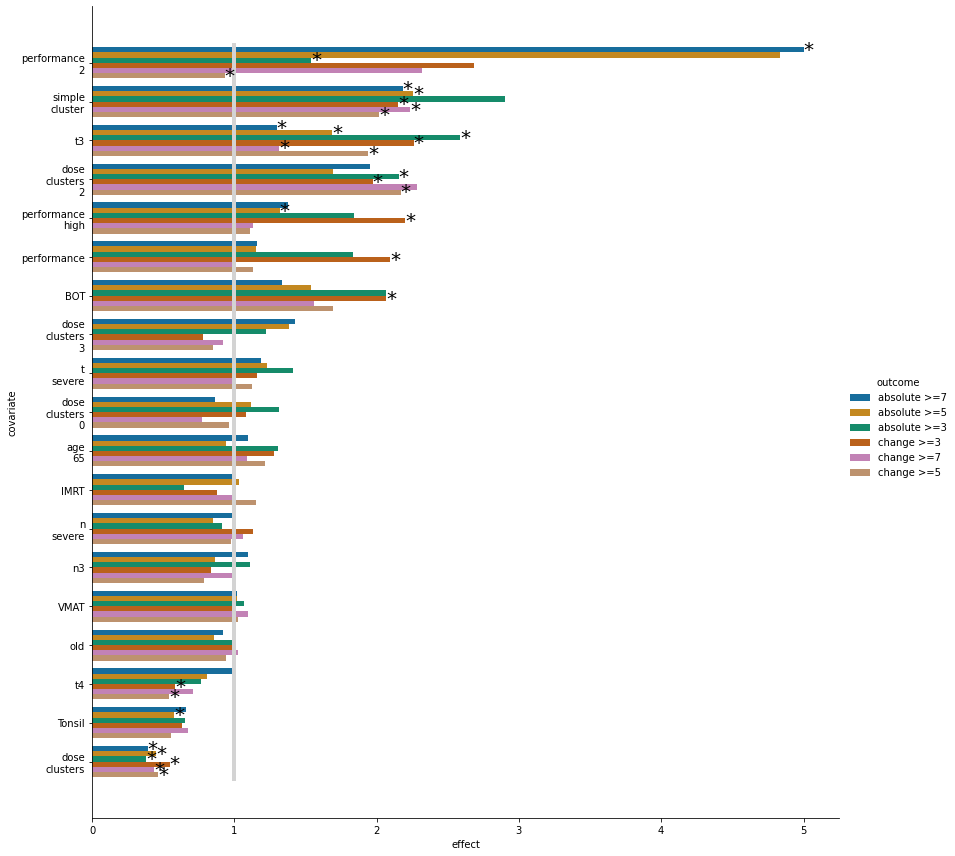

In [967]:
def get_confounder_correlations(ct,
                                use_cluster=True,
                                use_mimic=True,
                                cols = [
                                      't4','t3','t_severe',
                                      'n3','n_severe',
                                      'IMRT','VMAT',
                                      'BOT','Tonsil',
                                      'age_65','old',
                                      'performance_1','performance_2','performance_high'
                                  ],
                                use_limits = False):
    df = ct.df.copy()
    to_keep = cols[:]
    if use_cluster:
        cluster_df = ct.get_cluster_df()
        
        cluster_df = Utils.onehotify(df[['dose_clusters']])
        for col in cluster_df.columns:
            to_keep.append(col)
            df[col] = cluster_df[col]
            
    if use_mimic:
        mimic_df = ct.get_cluster_df(use_mimic=True)
        df['simple_cluster'] = mimic_df['dose_clusters'].astype(bool)
        to_keep.append('simple_cluster')
    if use_limits:
        to_keep = to_keep + [c for c in df.columns if '_limit' in c and 'Brainstem' not in c and c not in cols]
    df = Utils.onehotify(df[to_keep],drop_first=True)
    thresholds = [3,5,7]
    results = []
    for use_change in [False,True]:
        for threshold in thresholds:
            y = ct.get_outcome(threshold = threshold,use_change=use_change)
            for col in df.columns:
                ypred = df[col].fillna(0).values
                if threshold > 0:
                    [effect,pval] = Metrics.boolean_fisher_exact(y,ypred)
                else:
                    [effect,pval] = Metrics.vector_chi2(y,ypred)
                if use_change:
                    t = -threshold
                else:
                    t = threshold
                entry = {
#                     'outcome_change':use_change,
                    'threshold':t,
                    'covariate': col.replace('_1','').replace('.0','').replace('_True','').replace('_','\n'),
                    'effect': effect,
                    'pvalue': pval,
                }
                results.append(entry)
    return pd.DataFrame(results)#.groupby(['outcome_change','threshold','covariate']).first()

def plot_confounder_correlations(ct,**kwargs):
    ccors = get_confounder_correlations(ct,**kwargs)
    ccors['outcome'] = ccors.threshold.apply(lambda x: 'absolute >=' + str(x) if x >= 0 else 'change >=' + str(np.abs(x)) )
    ccors = ccors.sort_values('effect',ascending=False)
    chart = sns.catplot(
        data=ccors,
        height=12,
        aspect=1,
        x='effect',
        y='covariate',
        hue='outcome',
        kind='bar',
        orient='h',
        palette='colorblind',
    )
    ax = chart.facet_axis(0,0)
    for c in ax.containers:
        threshold = c.get_label()
        pvals = ccors[ccors.outcome==threshold].pvalue.values
        labels = [('' if p > .05 else '*') for p in pvals]
        ax.bar_label(c,labels=labels,label_type='edge',fontsize=20)
        ax.vlines(1,-.5,len(ccors.covariate.unique())-.5,color='lightgrey',linewidth=4)
    return ccors
plot_confounder_correlations(ct2,use_limits=False)

threshold                covariate    effect    pvalue       outcome
4            3          simple\ncluster  2.904341  0.000193  absolute >=3
53           7         Esophagus\nlimit  2.747720  0.012169  absolute >=7
13           3              SPC\nlimit2  2.680988  0.000552  absolute >=3
17           3         Esophagus\nlimit  2.520000  0.160098  absolute >=3
12           3               SPC\nlimit  2.439643  0.001391  absolute >=3
102         -7               SPC\nlimit  2.421185  0.006853    change >=7
3            3        dose\nclusters\n3  2.343023  0.032274  absolute >=3
94          -7          simple\ncluster  2.252083  0.002728    change >=7
107         -7         Esophagus\nlimit  2.228070  0.062149    change >=7
58          -3          simple\ncluster  2.197951  0.000922    change >=3
76          -5          simple\ncluster  2.167146  0.000495    change >=5
22           5          simple\ncluster  2.167109  0.000538  absolute >=5
66          -3               SPC\nlimit  2.165114  0.001795    change >=3
40           7          simple\ncluster  2.123570  0.001730  absolute >=7
103         -7              SPC\nlimit2  2.057910  0.006598    change >=7
93          -7        dose\nclusters\n3  2.048069  0.022962    change >=7
48           7               SPC\nlimit  2.037736  0.011237  absolute >=7
49           7              SPC\nlimit2  2.022222  0.002730  absolute >=7
14           3          Mandible\nlimit  1.995968  0.011539  absolute >=3
10           3               MPC\nlimit  1.916104  0.016725  absolute >=3
39           7        dose\nclusters\n3  1.875000  0.030205  absolute >=7
87          -5            Larynx\nlimit  1.870270  0.026602    change >=5
67          -3              SPC\nlimit2  1.849252  0.008912    change >=3
30           5               SPC\nlimit  1.821522  0.013195  absolute >=5
84          -5               SPC\nlimit  1.818182  0.017377    change >=5
51           7            Larynx\nlimit  1.815148  0.039306  absolute >=7
33           5            Larynx\nlimit  1.812081  0.039867  absolute >=5
50           7          Mandible\nlimit  1.772496  0.020160  absolute >=7
11           3              MPC\nlimit2  1.742944  0.086374  absolute >=3
64          -3               MPC\nlimit  1.742857  0.016400    change >=3
105         -7            Larynx\nlimit  1.731503  0.097774    change >=7
35           5         Esophagus\nlimit  1.699422  0.249220  absolute >=5
82          -5               MPC\nlimit  1.688316  0.021695    change >=5
31           5              SPC\nlimit2  1.672423  0.018358  absolute >=5
89          -5         Esophagus\nlimit  1.648855  0.245480    change >=5
104         -7          Mandible\nlimit  1.610857  0.090832    change >=7
2            3        dose\nclusters\n2  1.594933  0.124178  absolute >=3
100         -7               MPC\nlimit  1.564064  0.117974    change >=7
69          -3            Larynx\nlimit  1.542448  0.191531    change >=3
70          -3  Brachial\nPlexus\nlimit  1.534722  0.079113    change >=3
46           7               MPC\nlimit  1.531250  0.081641  absolute >=7
68          -3          Mandible\nlimit  1.514497  0.086002    change >=3
101         -7              MPC\nlimit2  1.510417  0.160888    change >=7
20           5        dose\nclusters\n2  1.508792  0.085282  absolute >=5
21           5        dose\nclusters\n3  1.487868  0.179051  absolute >=5
38           7        dose\nclusters\n2  1.470174  0.139241  absolute >=7
106         -7  Brachial\nPlexus\nlimit  1.467734  0.184598    change >=7
16           3  Brachial\nPlexus\nlimit  1.460250  0.175713  absolute >=3
28           5               MPC\nlimit  1.444444  0.104022  absolute >=5
44           7               IPC\nlimit  1.438283  0.231331  absolute >=7
85          -5              SPC\nlimit2  1.437500  0.104284    change >=5
57          -3        dose\nclusters\n3  1.422778  0.258346    change >=3
74          -5        dose\nclusters\n2  1.417168  0.134111    change >=5
65       

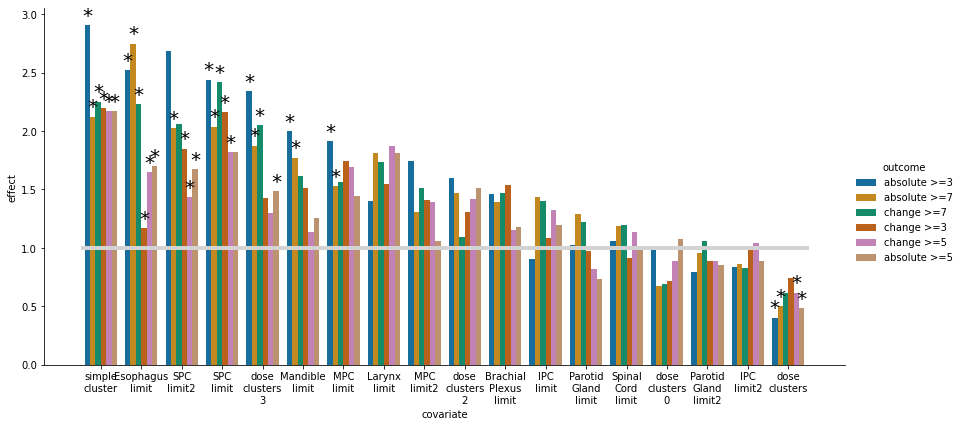

In [634]:
plot_confounder_correlations(ct,use_limits=True,cols=[])